In [1]:
import os


# Import libraries from general conda environment
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from scipy.optimize import linear_sum_assignment
import copy as copy
import pickle
from functools import reduce
from pathlib import Path

# Import libraries from UnitedNet
import sys
import os
from unitednet.interface import UnitedNet
from unitednet.configs import *
from unitednet.data import partitions,save_umap,generate_adata
from unitednet.scripts import ordered_cmat,assignmene_align

# Import for SHAPs
import shap
import torch
import torch.nn as nn
from unitednet.modules import submodel_trans, submodel_clus
from unitednet.data import save_obj, load_obj, type_specific_mean
from unitednet.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature

# Import for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors

# Import for more detailed plotting
import matplotlib as mpl
from  matplotlib.ticker import FuncFormatter

# Import STRINGdb for PPI network models and Networkx for visualisation and potential graph analysis
import stringdb
import networkx as nx
import math
from scipy.spatial import distance
import anndata
import scipy.sparse as sp
from sklearn.model_selection import train_test_split


2025-09-16 07:15:41.884085: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 07:15:41.891383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-16 07:15:41.899323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-16 07:15:41.901718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-16 07:15:41.908640: I tensorflow/core/platform/cpu_feature_guar

In [2]:
adata = sc.read_h5ad('../../Data/perturbmap_stomicsdb/GSM5808054_10x_Visium_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 4992 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [3]:
# Load your CSV file
pheno = pd.read_csv("../../Data/PertMap_metadata/spot_annotation_KP1.csv")

# Ensure barcodes are the index for merging
pheno = pheno.set_index("barcode")

# Add phenotypes to adata.obs (matching on index)
adata.obs["phenotypes"] = adata.obs.index.map(pheno["phenotypes"])
adata.obs['kmeans'] = adata.obs.index.map(pheno["kmeans"])

In [4]:
adata_h5 = adata

In [6]:
class Params:
    def __init__(self):
        self.knn_distanceType = 'euclidean'
        self.k = 15
        self.using_mask = False

params = Params()

In [10]:
import networkx as nx
import numpy as np
import torch
import scipy.sparse as sp
from scipy.spatial import distance
import pandas as pd  # ← you use pd.DataFrame later

# --- missing helper (add this) ---
def sparse_mx_to_torch_sparse_tensor(sparse_mx: sp.spmatrix) -> torch.Tensor:
    """Convert a scipy sparse matrix to a torch.sparse_coo_tensor."""
    coo = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack([coo.row, coo.col]).astype(np.int64))
    values = torch.from_numpy(coo.data)
    shape = torch.Size(coo.shape)
    return torch.sparse_coo_tensor(indices, values, shape)
# ----------------------------------

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0], dtype=adj.dtype, format="coo")
    rowsum = np.array(adj_.sum(1)).flatten()
    # avoid division by zero if there are isolated nodes
    rowsum[rowsum == 0.0] = 1.0
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5))
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return adj_normalized, sparse_mx_to_torch_sparse_tensor(adj_normalized)

def edgeList2edgeDict(edgeList, nodesize):
    graphdict = {}
    tdict = {}
    for edge in edgeList:
        end1 = edge[0]
        end2 = edge[1]
        tdict[end1] = ""
        tdict[end2] = ""
        tmplist = graphdict.get(end1, [])
        tmplist.append(end2)
        graphdict[end1] = tmplist

    # ensure all nodes present
    for i in range(nodesize):
        if i not in tdict:
            graphdict[i] = []
    return graphdict

def graph_computing(adj_coo, cell_num, params):
    edgeList = []
    for node_idx in range(cell_num):
        tmp = adj_coo[node_idx, :].reshape(1, -1)
        distMat = distance.cdist(tmp, adj_coo, getattr(params, "knn_distanceType", "euclidean"))
        res = distMat.argsort(axis=1)[:, :params.k + 1]  # self + k nearest
        tmpdist = distMat[0, res[0][1:params.k + 1]]
        boundary = np.mean(tmpdist) + np.std(tmpdist)
        for j in range(1, params.k + 1):
            w = 1.0 if distMat[0, res[0][j]] <= boundary else 0.0
            edgeList.append((node_idx, int(res[0][j]), w))
    return edgeList

def graph_construction(adj_coo, cell_N, params):
    adata_Adj = graph_computing(adj_coo, cell_N, params)
    graphdict = edgeList2edgeDict(adata_Adj, cell_N)
    G = nx.from_dict_of_lists(graphdict)
    adj_org = nx.adjacency_matrix(G)

    # remove diagonal
    adj_m1 = adj_org - sp.dia_matrix((adj_org.diagonal()[np.newaxis, :], [0]), shape=adj_org.shape)
    adj_m1.eliminate_zeros()

    # normalize + labels
    adj_norm_write, adj_norm_m1 = preprocess_graph(adj_m1)
    adj_label_m1 = adj_m1 + sp.eye(adj_m1.shape[0], format="csr")
    adj_label_m1 = torch.FloatTensor(adj_label_m1.toarray())

    # normalization factor for loss terms (as in typical GCN recipes)
    denom = float((adj_m1.shape[0] * adj_m1.shape[0] - adj_m1.sum()) * 2)
    norm_m1 = (adj_m1.shape[0] * adj_m1.shape[0]) / denom if denom != 0 else 1.0

    graph_dict = {
        "adj_org": adj_org,
        "adj_norm": adj_norm_m1,
        "adj_label": adj_label_m1,
        "norm_value": norm_m1
    }
    if getattr(params, "using_mask", False):
        graph_dict["adj_mask"] = torch.ones(cell_N, cell_N)
    return graph_dict, adj_norm_write

# --- run construction ---
graph_dict, adj_norm_write = graph_construction(adata_h5.obsm['spatial'], adata_h5.n_obs, params)

# --- niche_mrna computation ---
# --- niche_mrna computation (robust to sparse .X) ---
adj_label = graph_dict['adj_label'].cpu().detach().numpy().astype(bool)  # (n_obs, n_obs)
spatial_coo = adata_h5.obsm['spatial']                                   # (n_obs, 2)
n_cells, n_genes = adata_h5.n_obs, adata_h5.n_vars
niche_mrna = np.zeros((n_cells, n_genes), dtype=float)                    # explicit shape

for ind, nbr_mask in enumerate(adj_label):
    # indices of neighbors (incl. self)
    nbr_idx = np.flatnonzero(nbr_mask)
    # distances from ind to neighbors
    distMat = distance.cdist(
        spatial_coo[ind, :].reshape(1, -1),
        spatial_coo[nbr_idx, :],
        metric='euclidean'
    )  # shape (1, k)

    # invert nonzero distances; keep 0 for self
    nz = distMat > 0
    distMat[nz] = 1.0 / distMat[nz]

    s = distMat.sum()
    if s == 0:
        weights = np.ones((1, distMat.shape[1])) / max(1, distMat.shape[1])
    else:
        weights = distMat / s  # shape (1, k)

    # get neighbor expression as dense (k, n_genes)
    X_neighbors = adata_h5.X[nbr_idx, :]
    if hasattr(X_neighbors, "toarray"):  # sparse -> dense
        X_neighbors = X_neighbors.toarray()

    # weighted sum to (1, n_genes) -> (n_genes,)
    niche_mrna[ind, :] = (weights @ X_neighbors).ravel()

mrna = pd.DataFrame(niche_mrna.T, index=adata_h5.var_names, columns=adata_h5.obs_names)
# mrna.to_csv('./niche_mrna.csv')


In [11]:
df = mrna

In [12]:
df = df.T

In [13]:
adata_niche = anndata.AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [2]:
import scanpy as sc

In [3]:
adataa = sc.read('../Data/UnitedNet/input_data/adata_rna_train_perturbmap_KP2_1.h5ad')
adataa

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../Data/UnitedNet/input_data/adata_rna_train_perturbmap_KP2_1.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [8]:
def sparse_mx_to_torch_sparse_tensor(scipy_matrix):
    """Convert a scipy sparse matrix to a PyTorch sparse tensor."""
    # Ensure it's in the correct format (COO format)
    scipy_matrix = scipy_matrix.tocoo()
    
    # Get row, column, and data from the COO matrix
    row = torch.LongTensor(scipy_matrix.row)
    col = torch.LongTensor(scipy_matrix.col)
    data = torch.FloatTensor(scipy_matrix.data)
    
    # Create a sparse tensor in PyTorch
    sparse_tensor = torch.sparse.FloatTensor(torch.stack([row, col]), data, torch.Size(scipy_matrix.shape))
    
    return sparse_tensor

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return adj_normalized, sparse_mx_to_torch_sparse_tensor(adj_normalized)

def edgeList2edgeDict(edgeList, nodesize):
    graphdict = {}
    tdict = {}
    for edge in edgeList:
        end1 = edge[0]
        end2 = edge[1]
        tdict[end1] = ""
        tdict[end2] = ""
        if end1 in graphdict:
            tmplist = graphdict[end1]
        else:
            tmplist = []
        tmplist.append(end2)
        graphdict[end1] = tmplist

    # check and get full matrix
    for i in range(nodesize):
        if i not in tdict:
            graphdict[i] = []

    return graphdict

def graph_computing(adj_coo, cell_num, params):
    edgeList = []
    for node_idx in range(cell_num):
        tmp = adj_coo[node_idx, :].reshape(1, -1)
        distMat = distance.cdist(tmp, adj_coo, params.knn_distanceType)
        res = distMat.argsort()[:params.k + 1]
        tmpdist = distMat[0, res[0][1:params.k + 1]]
        boundary = np.mean(tmpdist) + np.std(tmpdist)
        for j in np.arange(1, params.k + 1):
            if distMat[0, res[0][j]] <= boundary:
                weight = 1.0
            else:
                weight = 0.0
            edgeList.append((node_idx, res[0][j], weight))

    return edgeList

def graph_construction(adj_coo, cell_N, params):
    adata_Adj = graph_computing(adj_coo, cell_N, params)
    graphdict = edgeList2edgeDict(adata_Adj, cell_N)
    adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))

    # Store original adjacency matrix (without diagonal entries) for later
    adj_m1 = adj_org
    adj_m1 = adj_m1 - sp.dia_matrix((adj_m1.diagonal()[np.newaxis, :], [0]), shape=adj_m1.shape)
    adj_m1.eliminate_zeros()

    # Some preprocessing
    adj_norm_write, adj_norm_m1 = preprocess_graph(adj_m1)
    adj_label_m1 = adj_m1 + sp.eye(adj_m1.shape[0])
    adj_label_m1 = torch.FloatTensor(adj_label_m1.toarray())
    norm_m1 = adj_m1.shape[0] * adj_m1.shape[0] / float((adj_m1.shape[0] * adj_m1.shape[0] - adj_m1.sum()) * 2)

    graph_dict = {
        "adj_org": adj_org,
        "adj_norm": adj_norm_m1,
        "adj_label": adj_label_m1,
        "norm_value": norm_m1
    }
    # mask is binary matrix for semi-supervised/multi-dataset (1-valid edge, 0-unknown edge)
    if params.using_mask is True:
        graph_dict["adj_mask"] = torch.ones(cell_N, cell_N)
    return graph_dict, adj_norm_write

In [6]:
graph_dict, adj_norm_write = graph_construction(adata.obsm['spatial'], adata.shape[0], params)

### save niche_mrna
adj_label = graph_dict['adj_label'].cpu().detach().numpy()
spatial_coo=adata.obsm['spatial']
niche_mrna=np.zeros(adata.X.shape)
for ind,i in enumerate(adj_label):
    distMat = distance.cdist(spatial_coo[ind,:].reshape(1,-1), spatial_coo[i.astype(bool),:], metric='euclidean')
    distMat[distMat>0]=1/distMat[distMat>0]
    distMat_normed = distMat / sum(sum(distMat))
    niche_mrna[ind, :] = distMat_normed.dot(adata.X[i.astype(bool), :])
### save niche_mrna
niche_mrna2=pd.DataFrame(niche_mrna.T,index=adata.var_names,columns=adata.obs_names)
# niche_mrna2.to_csv('../Data/perturbmap_stomicsdb/niche_kp12_dc.csv')

torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)


ValueError: could not broadcast input array from shape (16,) into shape (32289,)

In [8]:
import numpy as np
import scipy.sparse as sp
from scipy.spatial import distance

graph_dict, adj_norm_write = graph_construction(adata.obsm['spatial'], adata.shape[0], params)

# --- build niche_mrna safely ---
spatial_coo = adata.obsm['spatial']                               # (N, 2)
X = adata.X                                                        # (N, G) CSR or ndarray
N, G = adata.shape

niche_mrna = np.zeros((N, G), dtype=np.float32)

adj_label = graph_dict['adj_label'].cpu().detach().numpy()         # (N, N) or (N,) per-row iterator

for ind, nbr_mask_or_idx in enumerate(adj_label):
    # If adj_label row is 0/1 mask, turn to boolean mask; if it’s indices, adapt accordingly
    if nbr_mask_or_idx.dtype == bool or set(np.unique(nbr_mask_or_idx)).issubset({0,1}):
        nbr_mask = nbr_mask_or_idx.astype(bool)
    else:
        # treat as index list
        nbr_mask = np.zeros(N, dtype=bool)
        nbr_mask[np.asarray(nbr_mask_or_idx, dtype=int)] = True

    # neighbors (including or excluding self based on adj_label content)
    nbr_coords = spatial_coo[nbr_mask, :]                          # (k, 2)
    k = nbr_coords.shape[0]
    if k == 0:
        continue  # nothing to aggregate

    # distances from ind -> neighbors
    d = distance.cdist(spatial_coo[ind, :][None, :], nbr_coords, metric='euclidean').ravel()  # (k,)
    # inverse distance weights (avoid inf for zero distances)
    with np.errstate(divide='ignore'):
        w = np.where(d > 0, 1.0 / d, 0.0)

    s = w.sum()
    if s == 0:
        # fallback to uniform weights if all distances are zero (all neighbors at the same spot)
        w = np.full(k, 1.0 / k, dtype=np.float32)
    else:
        w = (w / s).astype(np.float32)                              # (k,)

    # neighbor expression matrix: (k, G)
    Xk = X[nbr_mask, :]

    # weighted aggregation to shape (G,)
    if sp.issparse(Xk):
    # (G, k) @ (k,) -> (G,)
        row = (Xk.T @ w).ravel()
    else:
        row = (w @ Xk).ravel()


    niche_mrna[ind, :] = row

# to DataFrame as before
niche_mrna2 = pd.DataFrame(niche_mrna.T, index=adata.var_names, columns=adata.obs_names)
# niche_mrna2.to_csv('../Data/perturbmap_stomicsdb/niche_kp12_dc.csv')


In [9]:
df = niche_mrna2

In [10]:
df = df.T

In [11]:
adata_niche = anndata.AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))

In [14]:
cell_metadata = adata.obs  # Metadata for samples/cells
gene_metadata = adata.var  # Metadata for genes

In [15]:
adata_niche.obs = cell_metadata  # Assign metadata to adata.obs
adata_niche.var = gene_metadata

In [15]:
adata_niche

AnnData object with n_obs × n_vars = 4992 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

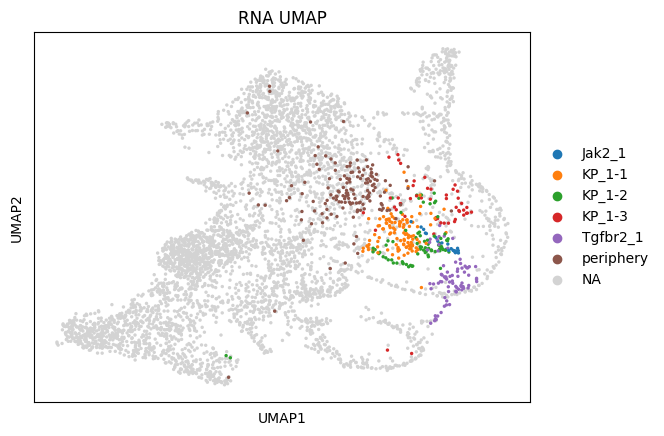

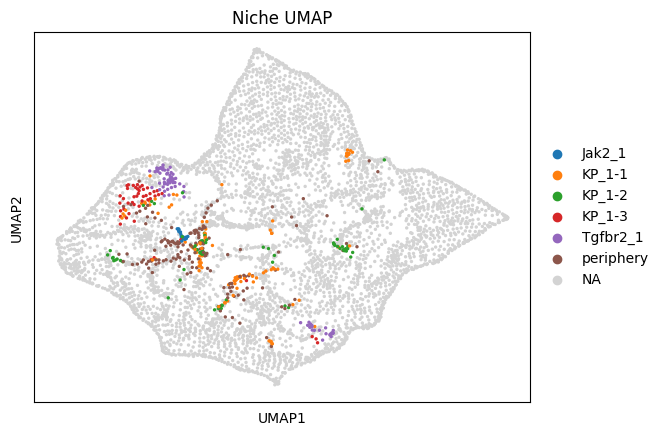

In [20]:
import scanpy as sc
rna = adata
niche_hvg = adata_niche

# RNA UMAP
sc.tl.pca(rna, use_highly_variable=False)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.pl.umap(rna, color="phenotypes", title="RNA UMAP")

# Niche UMAP
niche_tmp = niche_hvg.copy()
sc.tl.pca(niche_tmp, use_highly_variable=False)
sc.pp.neighbors(niche_tmp)
sc.tl.umap(niche_tmp)
sc.pl.umap(niche_tmp, color="phenotypes", title="Niche UMAP")

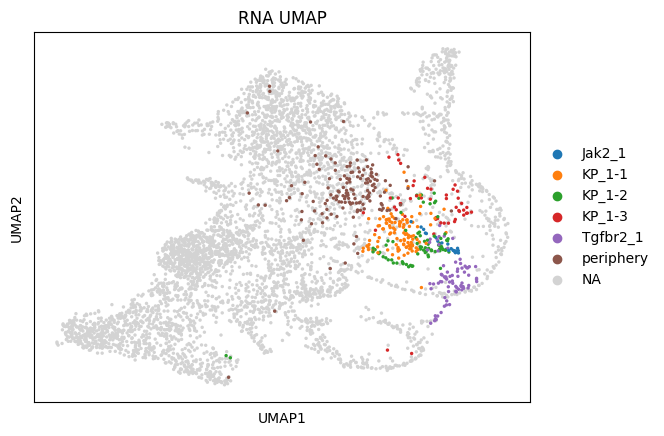

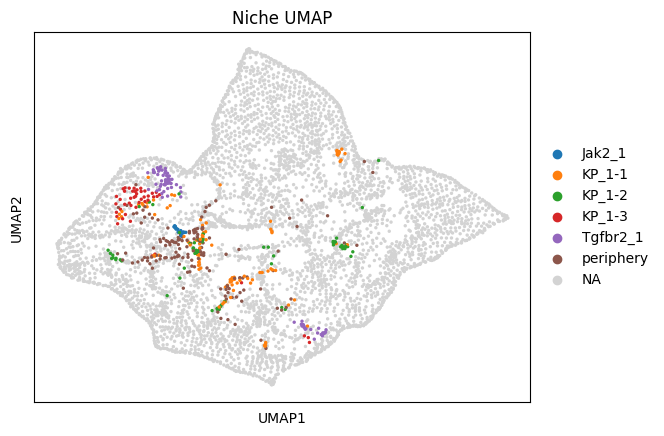

In [16]:
import scanpy as sc
rna = adata
niche_hvg = adata_niche

# RNA UMAP
sc.tl.pca(rna, use_highly_variable=False)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.pl.umap(rna, color="phenotypes", title="RNA UMAP")

# Niche UMAP
niche_tmp = niche_hvg.copy()
sc.tl.pca(niche_tmp, use_highly_variable=False)
sc.pp.neighbors(niche_tmp)
sc.tl.umap(niche_tmp)
sc.pl.umap(niche_tmp, color="phenotypes", title="Niche UMAP")

In [23]:
# Gene-wise correlation between RNA and niche

X_rna   = rna.X.A if hasattr(rna.X, "A") else np.asarray(rna.X)
X_niche = niche_hvg.X.A if hasattr(niche_hvg.X, "A") else np.asarray(niche_hvg.X)

cors = [np.corrcoef(X_rna[:, i], X_niche[:, i])[0,1] for i in range(X_rna.shape[1])]
df_gene_corr = pd.DataFrame({"gene": rna.var_names, "rna_niche_corr": cors})
df_gene_corr = df_gene_corr.sort_values("rna_niche_corr")

print("Most different genes (low RNA–niche correlation):")
print(df_gene_corr.head(15))

invalid value encountered in divide


Most different genes (low RNA–niche correlation):
                gene  rna_niche_corr
30308        Afap1l2       -0.050506
13297  D430042O09Rik       -0.043174
23855           Rft1       -0.040949
23412          Pde4d       -0.040461
21323          Rab15       -0.040040
15510         Plppr2       -0.039782
20985        Prkar2b       -0.038500
27362         Zfp229       -0.038361
3960          Zfp334       -0.038150
27175         Rsph3b       -0.038080
26867          Stx19       -0.038036
15396         Cep295       -0.037678
16281           Ice2       -0.037599
30660          Cul4b       -0.037442
17155          Epm2a       -0.037383


In [24]:
# Variance comparison

rna_var   = X_rna.var(axis=0)
niche_var = X_niche.var(axis=0)

df_var = pd.DataFrame({
    "gene": rna.var_names,
    "rna_var": rna_var,
    "niche_var": niche_var,
    "delta_var": niche_var - rna_var
}).sort_values("delta_var")

print("Genes with largest variance drop (niche smoother):")
print(df_var.head(10))
print("Genes with variance increase (niche highlights gradients):")
print(df_var.tail(10))

Genes with largest variance drop (niche smoother):
         gene   rna_var  niche_var  delta_var
12913  Hbb-bs  0.799637   0.172929  -0.626707
18918  Hba-a2  0.701549   0.150307  -0.551242
18916  Hba-a1  0.656469   0.127491  -0.528978
21832  Ighg2b  1.078118   0.644010  -0.434107
8241   Jchain  0.806676   0.377665  -0.429011
21834   Ighg1  1.096033   0.690639  -0.405394
8427     Spp1  0.720611   0.329782  -0.390828
8171     Hopx  0.583689   0.198761  -0.384928
28309      C3  0.819003   0.438344  -0.380659
3911     Slpi  0.694911   0.320288  -0.374623
Genes with variance increase (niche highlights gradients):
                gene  rna_var  niche_var  delta_var
10402         Dnajb8      0.0        0.0        0.0
22790        Gm16248      0.0        0.0        0.0
10400        Gm38708      0.0        0.0        0.0
10388        Gm43904      0.0        0.0        0.0
10384        Gm44097      0.0        0.0        0.0
10382        Gm34312      0.0        0.0        0.0
10379          Bmp10

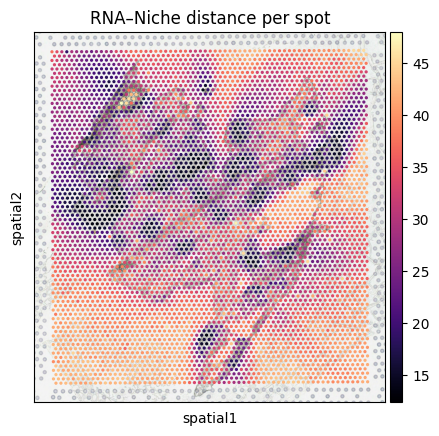

In [25]:
from numpy.linalg import norm

dists = norm(X_rna - X_niche, axis=1)
rna.obs["rna_niche_distance"] = dists

sc.pl.spatial(rna, color="rna_niche_distance", cmap="magma", title="RNA–Niche distance per spot")

In [27]:
# # %% [markdown]
# # # RNA vs Niche Modality: per-gene comparison (uses in-memory AnnData objects)
# # Assumes you already have:
# #   - rna:       AnnData (RNA modality)
# #   - niche_hvg: AnnData (Niche modality, e.g., neighborhood-averaged RNA for HVGs)
# #
# # Outputs:
# #   - CSV with per-gene stats: ./perturbmap_rna_vs_niche_gene_comparison.csv
# #   - PNG figures in ./ (can change output_dir below)

# # %%
# import numpy as np
# import pandas as pd
# import scipy.sparse as sp
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error
# from scipy.stats import pearsonr
# import os

# # --------------------- Config ---------------------
# output_dir = "./"
# min_expr_for_plots = 0.1     # filter low-expression genes for plotting summaries
# top_n = 15                   # how many genes to show in bar charts
# # --------------------------------------------------

# # -------- 0) Basic checks & alignment (genes + cells) --------
# def _to_set(x):
#     # var_names / obs_names can be Index; convert robustly
#     return set(map(str, x))

# # Intersect genes
# common_genes = _to_set(rna.var_names) & _to_set(niche_hvg.var_names)
# if len(common_genes) == 0:
#     raise ValueError("No common genes between `rna` and `niche_hvg`.")

# # Intersect cells (obs)
# common_cells = _to_set(rna.obs_names) & _to_set(niche_hvg.obs_names)
# if len(common_cells) == 0:
#     raise ValueError("No common cells between `rna` and `niche_hvg`.")

# # Subset and order consistently
# common_genes = sorted(list(common_genes))
# common_cells = sorted(list(common_cells))

# rna_sub   = rna[common_cells, common_genes].copy()
# niche_sub = niche_hvg[common_cells, common_genes].copy()

# # Sanity
# assert (rna_sub.var_names == niche_sub.var_names).all(), "Gene order mismatch after subsetting."
# assert (rna_sub.obs_names == niche_sub.obs_names).all(), "Cell order mismatch after subsetting."

# N, G = rna_sub.shape
# print(f"[Aligned] cells={N}, genes={G}")

# # -------- 1) Helper to fetch column i as dense 1D without full densification --------
# def col_as_1d_dense(X, i):
#     col = X[:, i]
#     if sp.issparse(col):
#         # (N,1) sparse -> flat dense
#         return col.toarray().ravel()
#     elif hasattr(col, "A1"):  # just in case it's a matrix-like
#         return col.A1
#     else:
#         col = np.asarray(col)
#         return col.ravel()

# # -------- 2) Compute per-gene metrics --------
# stats = []
# for i, gene in enumerate(rna_sub.var_names):
#     if i % 500 == 0:
#         print(f"  computing metrics for gene {i+1}/{G}")

#     rvals = col_as_1d_dense(rna_sub.X, i)
#     nvals = col_as_1d_dense(niche_sub.X, i)

#     # Skip a gene that is completely zero in both
#     if (rvals == 0).all() and (nvals == 0).all():
#         continue

#     # Means, variances
#     r_mean  = float(rvals.mean())
#     n_mean  = float(nvals.mean())
#     r_var   = float(rvals.var())
#     n_var   = float(nvals.var())
#     mean_diff = n_mean - r_mean
#     var_ratio = n_var / (r_var + 1e-10)  # avoid div-by-zero
#     smoothing_effect = 1.0 - var_ratio   # higher => more smoothed

#     # MSE
#     mse = float(mean_squared_error(rvals, nvals))

#     # Pearson correlation (protect against zero-variance)
#     if rvals.std() > 0 and nvals.std() > 0:
#         corr = float(pearsonr(rvals, nvals)[0])
#     else:
#         corr = 0.0

#     # Mean absolute difference
#     mad = float(np.mean(np.abs(rvals - nvals)))

#     stats.append({
#         "gene": gene,
#         "mean_abs_diff": mad,
#         "mse": mse,
#         "correlation": corr,
#         "rna_mean": r_mean,
#         "niche_mean": n_mean,
#         "mean_diff": mean_diff,
#         "rna_var": r_var,
#         "niche_var": n_var,
#         "var_ratio": var_ratio,
#         "max_expr": max(r_mean, n_mean),
#         "smoothing_effect": smoothing_effect
#     })

# df_stats = pd.DataFrame(stats)
# print(f"Computed statistics for {len(df_stats)} genes.")

# # Save CSV
# csv_path = os.path.join(output_dir, "perturbmap_rna_vs_niche_gene_comparison.csv")
# df_stats.to_csv(csv_path, index=False)
# print(f"Saved per-gene stats -> {csv_path}")

# # -------- 3) Summary + plots (matplotlib only) --------
# df_plot = df_stats[df_stats["max_expr"] > min_expr_for_plots].copy()
# if len(df_plot) == 0:
#     print(f"No genes exceed min_expr_for_plots={min_expr_for_plots}; skipping plots.")
# else:
#     print("\nSummary (filtered for reasonably expressed genes):")
#     print(f"  n_genes: {len(df_plot)}")
#     print(f"  mean(correlation): {df_plot['correlation'].mean():.3f}")
#     print(f"  median(correlation): {df_plot['correlation'].median():.3f}")
#     print(f"  mean(mean_abs_diff): {df_plot['mean_abs_diff'].mean():.3f}")
#     print(f"  mean(smoothing_effect): {df_plot['smoothing_effect'].mean():.3f}")

#     # Figure 1: 2x3 dashboard
#     fig, axes = plt.subplots(2, 3, figsize=(18, 12))
#     fig.suptitle('RNA vs Niche Modality — Gene-wise Differences', fontsize=16, fontweight='bold')

#     # Top by mean_abs_diff
#     top_diff = df_plot.nlargest(top_n, "mean_abs_diff")
#     axes[0,0].barh(range(len(top_diff)), top_diff["mean_abs_diff"])
#     axes[0,0].set_yticks(range(len(top_diff)))
#     axes[0,0].set_yticklabels(top_diff["gene"], fontsize=9)
#     axes[0,0].set_title(f"Top {top_n} by Mean Absolute Difference")
#     axes[0,0].set_xlabel("Mean Abs Diff")

#     # Lowest correlations
#     low_corr = df_plot.nsmallest(top_n, "correlation")
#     axes[0,1].barh(range(len(low_corr)), low_corr["correlation"])
#     axes[0,1].set_yticks(range(len(low_corr)))
#     axes[0,1].set_yticklabels(low_corr["gene"], fontsize=9)
#     axes[0,1].set_title(f"Top {top_n} Lowest Correlations")
#     axes[0,1].set_xlabel("Correlation")

#     # Top MSE
#     top_mse = df_plot.nlargest(top_n, "mse")
#     axes[0,2].barh(range(len(top_mse)), top_mse["mse"])
#     axes[0,2].set_yticks(range(len(top_mse)))
#     axes[0,2].set_yticklabels(top_mse["gene"], fontsize=9)
#     axes[0,2].set_title(f"Top {top_n} by MSE")
#     axes[0,2].set_xlabel("MSE")

#     # Correlation histogram
#     axes[1,0].hist(df_plot["correlation"].dropna(), bins=50, edgecolor='black')
#     axes[1,0].axvline(df_plot["correlation"].mean(), linestyle='--')
#     axes[1,0].set_title("Distribution of Gene Correlations")
#     axes[1,0].set_xlabel("Correlation (RNA vs Niche)")
#     axes[1,0].set_ylabel("Count")

#     # Smoothing effect
#     most_smoothed = df_plot.nlargest(top_n, "smoothing_effect")
#     axes[1,1].barh(range(len(most_smoothed)), most_smoothed["smoothing_effect"])
#     axes[1,1].set_yticks(range(len(most_smoothed)))
#     axes[1,1].set_yticklabels(most_smoothed["gene"], fontsize=9)
#     axes[1,1].set_title(f"Top {top_n} Most Smoothed")
#     axes[1,1].set_xlabel("1 - Var_niche/Var_rna")

#     # Mean diff (niche - rna)
#     mean_diffs = df_plot.copy()
#     mean_diffs["abs_mean_diff"] = np.abs(mean_diffs["mean_diff"])
#     top_mean_diff = mean_diffs.nlargest(top_n, "abs_mean_diff")
#     colors = ["C3" if x > 0 else "C0" for x in top_mean_diff["mean_diff"]]
#     axes[1,2].barh(range(len(top_mean_diff)), top_mean_diff["mean_diff"], color=colors)
#     axes[1,2].set_yticks(range(len(top_mean_diff)))
#     axes[1,2].set_yticklabels(top_mean_diff["gene"], fontsize=9)
#     axes[1,2].axvline(0, color='k', linewidth=1)
#     axes[1,2].set_title(f"Top {top_n} by Mean Expression Change (Niche - RNA)")
#     axes[1,2].set_xlabel("Mean Difference")

#     plt.tight_layout()
#     fig_path = os.path.join(output_dir, "perturbmap_rna_niche_comprehensive_analysis.png")
#     plt.savefig(fig_path, dpi=300, bbox_inches='tight')
#     plt.show()
#     print(f"Saved dashboard figure -> {fig_path}")

#     # Figure 2: overall mean/variance correlations
#     # Means across cells for each gene (sparse-safe)
#     def mean_of_matrix_cols(X):
#         if sp.issparse(X):
#             return np.asarray(X.mean(axis=0)).ravel()
#         return X.mean(axis=0).ravel()

#     def var_of_matrix_cols(X):
#         # Exact variance on sparse can be expensive; use E[X^2] - (E[X])^2
#         if sp.issparse(X):
#             Ex   = np.asarray(X.mean(axis=0)).ravel()
#             Ex2  = np.asarray((X.multiply(X)).mean(axis=0)).ravel()
#             return (Ex2 - Ex**2)
#         X = np.asarray(X)
#         return X.var(axis=0)

#     rna_mean  = mean_of_matrix_cols(rna_sub.X)
#     niche_mean = mean_of_matrix_cols(niche_sub.X)
#     rna_var   = var_of_matrix_cols(rna_sub.X)
#     niche_var  = var_of_matrix_cols(niche_sub.X)

#     # Use the filtered set for plotting readability
#     keep = df_plot["gene"].values
#     gene_to_idx = {g:i for i,g in enumerate(rna_sub.var_names)}
#     idx_keep = np.array([gene_to_idx[g] for g in keep])

#     fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

#     # Means
#     axes2[0].scatter(rna_mean[idx_keep], niche_mean[idx_keep], s=12, alpha=0.6)
#     lim = max(rna_mean[idx_keep].max(), niche_mean[idx_keep].max())
#     axes2[0].plot([0, lim], [0, lim], 'k--', linewidth=1)
#     axes2[0].set_xlabel("RNA mean")
#     axes2[0].set_ylabel("Niche mean")
#     axes2[0].set_title("Gene-wise Mean: RNA vs Niche")

#     from numpy import corrcoef
#     overall_mean_corr = float(corrcoef(rna_mean[idx_keep], niche_mean[idx_keep])[0,1])
#     axes2[0].text(0.05, 0.95, f"r = {overall_mean_corr:.3f}", transform=axes2[0].transAxes,
#                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

#     # Variances
#     axes2[1].scatter(rna_var[idx_keep], niche_var[idx_keep], s=12, alpha=0.6)
#     lim_v = max(rna_var[idx_keep].max(), niche_var[idx_keep].max())
#     axes2[1].plot([0, lim_v], [0, lim_v], 'k--', linewidth=1)
#     axes2[1].set_xlabel("RNA variance")
#     axes2[1].set_ylabel("Niche variance")
#     axes2[1].set_title("Gene-wise Variance: RNA vs Niche")

#     overall_var_corr = float(corrcoef(rna_var[idx_keep], niche_var[idx_keep])[0,1])
#     axes2[1].text(0.05, 0.95, f"r = {overall_var_corr:.3f}", transform=axes2[1].transAxes,
#                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

#     plt.tight_layout()
#     fig2_path = os.path.join(output_dir, "perturbmap_rna_niche_correlation_analysis.png")
#     plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
#     plt.show()
#     print(f"Saved correlation figure -> {fig2_path}")

# # -------- 4) Quick headline numbers --------
# if len(df_plot) > 0:
#     n_low_corr = int((df_plot["correlation"] < 0.5).sum())
#     n_strong_smooth = int((df_plot["smoothing_effect"] > 0.5).sum())
#     print("\n=== HEADLINES ===")
#     print(f"- Overall mean corr (means): {df_plot['correlation'].mean():.3f}")
#     print(f"- Genes with correlation < 0.5: {n_low_corr}")
#     print(f"- Genes with >50% variance reduction (smoothing): {n_strong_smooth}")
#     print(f"- Mean smoothing effect: {df_plot['smoothing_effect'].mean():.3f}")


[Aligned] cells=4992, genes=32289
  computing metrics for gene 1/32289
  computing metrics for gene 501/32289
  computing metrics for gene 1001/32289
  computing metrics for gene 1501/32289
  computing metrics for gene 2001/32289
  computing metrics for gene 2501/32289
  computing metrics for gene 3001/32289
  computing metrics for gene 3501/32289
  computing metrics for gene 4001/32289
  computing metrics for gene 4501/32289
  computing metrics for gene 5001/32289
  computing metrics for gene 5501/32289
  computing metrics for gene 6001/32289
  computing metrics for gene 6501/32289
  computing metrics for gene 7001/32289
  computing metrics for gene 7501/32289
  computing metrics for gene 8001/32289
  computing metrics for gene 8501/32289
  computing metrics for gene 9001/32289
  computing metrics for gene 9501/32289
  computing metrics for gene 10001/32289


KeyboardInterrupt: 

Requested 5000 HVGs; using 5000 genes present in both objects.
[Aligned 5k] cells=4992, genes=5000
  metrics for gene 1/5000
  metrics for gene 501/5000
  metrics for gene 1001/5000
  metrics for gene 1501/5000
  metrics for gene 2001/5000
  metrics for gene 2501/5000
  metrics for gene 3001/5000
  metrics for gene 3501/5000
  metrics for gene 4001/5000
  metrics for gene 4501/5000
Saved per-gene stats -> ./perturbmap_rna_vs_niche_gene_comparison_5k.csv

Summary (5k HVG set, filtered):
  n_genes: 858
  mean(correlation): 0.169
  median(correlation): 0.105
  mean(mean_abs_diff): 0.283
  mean(smoothing_effect): 0.864


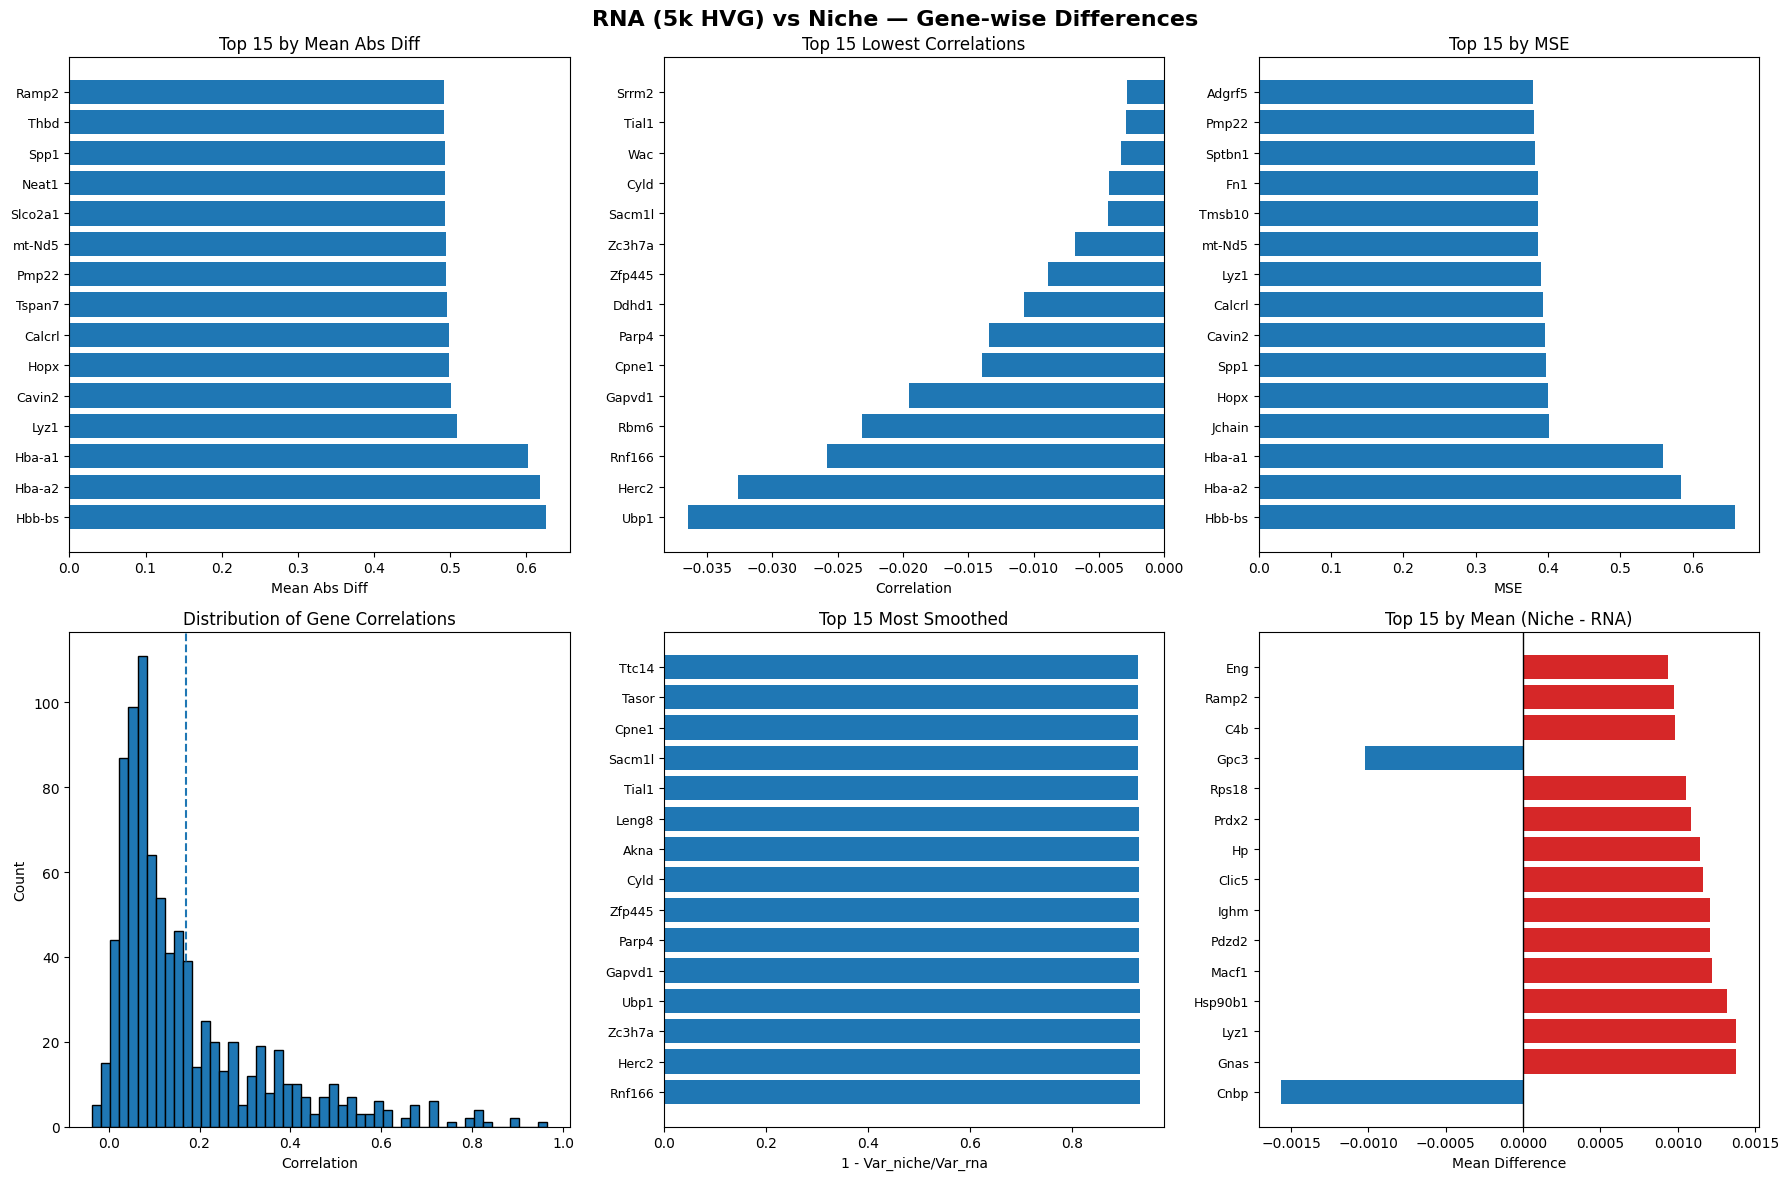

Saved dashboard -> ./perturbmap_rna_niche_comprehensive_analysis_5k.png


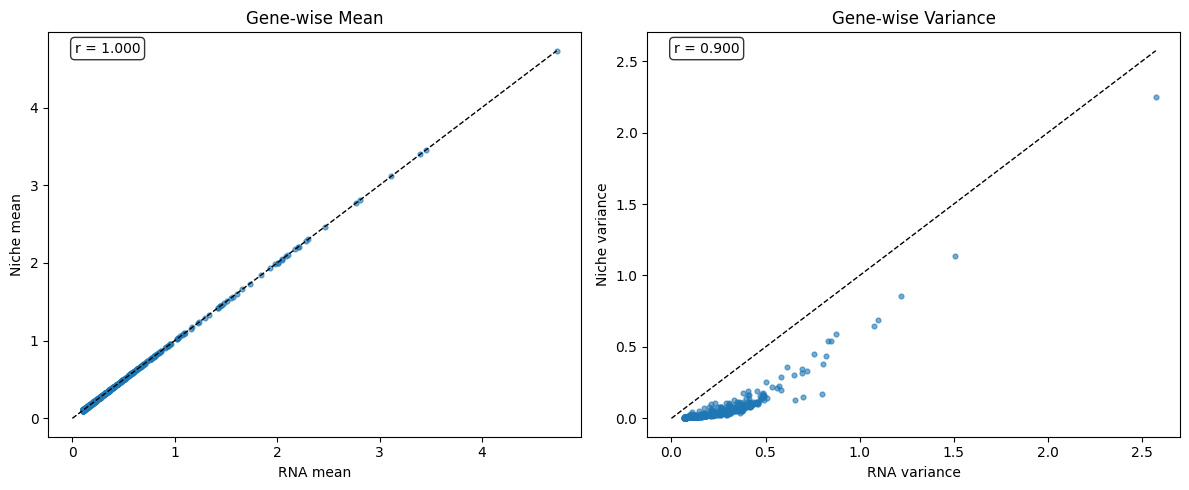

Saved correlation figure -> ./perturbmap_rna_niche_correlation_analysis_5k.png

=== HEADLINES (5k) ===
- Mean corr (gene-level corr avg over filtered): 0.169
- Genes with corr < 0.5: 801
- Genes with >50% variance reduction: 846
- Mean smoothing effect: 0.864


In [31]:
# %% [markdown]
# ## Downsize RNA to 5k HVGs, mirror genes in Niche, then compare
# Requires in memory:
#   rna         : AnnData (RNA modality)
#   niche_hvg   : AnnData (Niche modality)

# %%
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import scanpy as sc
import warnings, os
warnings.filterwarnings("ignore")

TARGET_K = 5000
OUTPUT_DIR = "./"
MIN_EXPR_FOR_PLOTS = 0.1
TOP_N = 15

# -------- helpers --------
def _ensure_unique_varnames(adata):
    if not adata.var_names.is_unique:
        adata.var_names_make_unique()

def _select_hvgs_from_rna(rna, target_k=5000):
    """
    Compute HVGs on a copy of `rna` and return a ranked gene list + top-k.
    Works across scanpy versions (seurat/seurat_v3/cell_ranger flavors).
    """
    _ensure_unique_varnames(rna)
    work = rna.copy()

    # lightweight normalization just for HVG ranking
    import scanpy as sc
    sc.pp.normalize_total(work, target_sum=1e4)
    sc.pp.log1p(work)

    # get per-gene variability metrics for all genes
    sc.pp.highly_variable_genes(work, n_top_genes=None)

    var = work.var
    # Pick the best available scoring column
    score_col = None
    for cand in ["variances_norm", "dispersions_norm", "variances", "dispersions"]:
        if cand in var.columns:
            score_col = cand
            break
    if score_col is None:
        # last resort: use inverse of rank if available
        if "highly_variable_rank" in var.columns:
            var["__score__"] = -var["highly_variable_rank"].fillna(var["highly_variable_rank"].max()+1)
            score_col = "__score__"
        else:
            raise KeyError(
                "Could not find a variability score column (expected one of "
                "'variances_norm','dispersions_norm','variances','dispersions', "
                "or 'highly_variable_rank')."
            )

    rank = var[[score_col]].copy()
    rank["gene"] = work.var_names
    # larger score = more variable (except the inverse-rank fallback already negated)
    rank = rank.sort_values(score_col, ascending=False, kind="mergesort").reset_index(drop=True)
    ranked_genes = rank["gene"].tolist()
    topk = ranked_genes[:target_k]
    return ranked_genes, topk


def _best_effort_match_in_both(ranked, adata_other, target_k):
    """
    From a ranked gene list (RNA HVG ranking), select exactly target_k genes
    that exist in adata_other. If not enough, returns as many as available.
    """
    other_set = set(map(str, adata_other.var_names))
    picked = [g for g in ranked if g in other_set]
    if len(picked) >= target_k:
        return picked[:target_k]
    # Not enough; return whatever we have (warn)
    print(f"[WARN] Only {len(picked)} of the ranked genes exist in the niche object; using all available.")
    return picked

def _align_pair_by_genes_and_cells(a, b, genes, prefer_sorted=True):
    # cells intersection
    cells = sorted(list(set(map(str, a.obs_names)) & set(map(str, b.obs_names)))) if prefer_sorted else \
            list(set(a.obs_names) & set(b.obs_names))
    if len(cells) == 0:
        raise ValueError("No common cells between RNA and niche after alignment.")
    a_sub = a[cells, genes].copy()
    b_sub = b[cells, genes].copy()
    # sanity
    assert (a_sub.var_names == b_sub.var_names).all()
    assert (a_sub.obs_names == b_sub.obs_names).all()
    return a_sub, b_sub

def _col_as_dense(X, i):
    col = X[:, i]
    if sp.issparse(col):
        return col.toarray().ravel()
    return np.asarray(col).ravel()

def _means_sparse_safe(X):
    if sp.issparse(X):
        return np.asarray(X.mean(axis=0)).ravel()
    return X.mean(axis=0).ravel()

def _vars_sparse_safe(X):
    if sp.issparse(X):
        Ex  = np.asarray(X.mean(axis=0)).ravel()
        Ex2 = np.asarray((X.multiply(X)).mean(axis=0)).ravel()
        return Ex2 - Ex**2
    X = np.asarray(X)
    return X.var(axis=0)

# -------- 1) pick 5k HVGs from RNA and mirror in Niche --------
_ensure_unique_varnames(rna)
_ensure_unique_varnames(niche_hvg)

ranked, rna_topk = _select_hvgs_from_rna(rna, target_k=TARGET_K)
genes_5k_in_both = _best_effort_match_in_both(ranked, niche_hvg, TARGET_K)

print(f"Requested {TARGET_K} HVGs; using {len(genes_5k_in_both)} genes present in both objects.")

rna_5k, niche_5k = _align_pair_by_genes_and_cells(rna, niche_hvg, genes_5k_in_both, prefer_sorted=True)
N, G = rna_5k.shape
print(f"[Aligned 5k] cells={N}, genes={G}")

# -------- 2) compute per-gene metrics --------
stats = []
for i, gene in enumerate(rna_5k.var_names):
    if i % 500 == 0:
        print(f"  metrics for gene {i+1}/{G}")
    rvals = _col_as_dense(rna_5k.X, i)
    nvals = _col_as_dense(niche_5k.X, i)

    if (rvals == 0).all() and (nvals == 0).all():
        continue

    r_mean  = float(rvals.mean())
    n_mean  = float(nvals.mean())
    r_var   = float(rvals.var())
    n_var   = float(nvals.var())
    mean_diff = n_mean - r_mean
    var_ratio = n_var / (r_var + 1e-10)
    smoothing_effect = 1.0 - var_ratio
    mse = float(mean_squared_error(rvals, nvals))
    corr = float(pearsonr(rvals, nvals)[0]) if (rvals.std() > 0 and nvals.std() > 0) else 0.0
    mad = float(np.mean(np.abs(rvals - nvals)))

    stats.append({
        "gene": gene,
        "mean_abs_diff": mad,
        "mse": mse,
        "correlation": corr,
        "rna_mean": r_mean,
        "niche_mean": n_mean,
        "mean_diff": mean_diff,
        "rna_var": r_var,
        "niche_var": n_var,
        "var_ratio": var_ratio,
        "max_expr": max(r_mean, n_mean),
        "smoothing_effect": smoothing_effect
    })

df_stats = pd.DataFrame(stats)
csv_path = os.path.join(OUTPUT_DIR, "perturbmap_rna_vs_niche_gene_comparison_5k.csv")
df_stats.to_csv(csv_path, index=False)
print(f"Saved per-gene stats -> {csv_path}")

# -------- 3) plots --------
df_plot = df_stats[df_stats["max_expr"] > MIN_EXPR_FOR_PLOTS].copy()
if len(df_plot) == 0:
    print(f"No genes exceed min_expr={MIN_EXPR_FOR_PLOTS}; skipping plots.")
else:
    print("\nSummary (5k HVG set, filtered):")
    print(f"  n_genes: {len(df_plot)}")
    print(f"  mean(correlation): {df_plot['correlation'].mean():.3f}")
    print(f"  median(correlation): {df_plot['correlation'].median():.3f}")
    print(f"  mean(mean_abs_diff): {df_plot['mean_abs_diff'].mean():.3f}")
    print(f"  mean(smoothing_effect): {df_plot['smoothing_effect'].mean():.3f}")

    # Dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('RNA (5k HVG) vs Niche — Gene-wise Differences', fontsize=16, fontweight='bold')

    top_diff = df_plot.nlargest(TOP_N, "mean_abs_diff")
    axes[0,0].barh(range(len(top_diff)), top_diff["mean_abs_diff"])
    axes[0,0].set_yticks(range(len(top_diff))); axes[0,0].set_yticklabels(top_diff["gene"], fontsize=9)
    axes[0,0].set_title(f"Top {TOP_N} by Mean Abs Diff"); axes[0,0].set_xlabel("Mean Abs Diff")

    low_corr = df_plot.nsmallest(TOP_N, "correlation")
    axes[0,1].barh(range(len(low_corr)), low_corr["correlation"])
    axes[0,1].set_yticks(range(len(low_corr))); axes[0,1].set_yticklabels(low_corr["gene"], fontsize=9)
    axes[0,1].set_title(f"Top {TOP_N} Lowest Correlations"); axes[0,1].set_xlabel("Correlation")

    top_mse = df_plot.nlargest(TOP_N, "mse")
    axes[0,2].barh(range(len(top_mse)), top_mse["mse"])
    axes[0,2].set_yticks(range(len(top_mse))); axes[0,2].set_yticklabels(top_mse["gene"], fontsize=9)
    axes[0,2].set_title(f"Top {TOP_N} by MSE"); axes[0,2].set_xlabel("MSE")

    axes[1,0].hist(df_plot["correlation"].dropna(), bins=50, edgecolor='black')
    axes[1,0].axvline(df_plot["correlation"].mean(), linestyle='--')
    axes[1,0].set_title("Distribution of Gene Correlations"); axes[1,0].set_xlabel("Correlation"); axes[1,0].set_ylabel("Count")

    most_smoothed = df_plot.nlargest(TOP_N, "smoothing_effect")
    axes[1,1].barh(range(len(most_smoothed)), most_smoothed["smoothing_effect"])
    axes[1,1].set_yticks(range(len(most_smoothed))); axes[1,1].set_yticklabels(most_smoothed["gene"], fontsize=9)
    axes[1,1].set_title(f"Top {TOP_N} Most Smoothed"); axes[1,1].set_xlabel("1 - Var_niche/Var_rna")

    mean_diffs = df_plot.copy(); mean_diffs["abs_mean_diff"] = np.abs(mean_diffs["mean_diff"])
    top_mean_diff = mean_diffs.nlargest(TOP_N, "abs_mean_diff")
    colors = ["C3" if x > 0 else "C0" for x in top_mean_diff["mean_diff"]]
    axes[1,2].barh(range(len(top_mean_diff)), top_mean_diff["mean_diff"], color=colors)
    axes[1,2].set_yticks(range(len(top_mean_diff))); axes[1,2].set_yticklabels(top_mean_diff["gene"], fontsize=9)
    axes[1,2].axvline(0, color='k', linewidth=1)
    axes[1,2].set_title(f"Top {TOP_N} by Mean (Niche - RNA)"); axes[1,2].set_xlabel("Mean Difference")

    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "perturbmap_rna_niche_comprehensive_analysis_5k.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight'); plt.show()
    print(f"Saved dashboard -> {fig_path}")

    # Overall mean/variance correlation (use same 5k set)
    rna_mean  = _means_sparse_safe(rna_5k.X)
    niche_mean = _means_sparse_safe(niche_5k.X)
    rna_var   = _vars_sparse_safe(rna_5k.X)
    niche_var  = _vars_sparse_safe(niche_5k.X)

    # limit points to genes in df_plot for readability
    keep = df_plot["gene"].values
    idx = pd.Index(rna_5k.var_names).get_indexer(keep)

    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
    axes2[0].scatter(rna_mean[idx], niche_mean[idx], s=12, alpha=0.6)
    lim = float(max(rna_mean[idx].max(), niche_mean[idx].max()))
    axes2[0].plot([0, lim], [0, lim], 'k--', linewidth=1)
    axes2[0].set_xlabel("RNA mean"); axes2[0].set_ylabel("Niche mean"); axes2[0].set_title("Gene-wise Mean")

    mean_corr = float(np.corrcoef(rna_mean[idx], niche_mean[idx])[0,1])
    axes2[0].text(0.05, 0.95, f"r = {mean_corr:.3f}", transform=axes2[0].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    axes2[1].scatter(rna_var[idx], niche_var[idx], s=12, alpha=0.6)
    limv = float(max(rna_var[idx].max(), niche_var[idx].max()))
    axes2[1].plot([0, limv], [0, limv], 'k--', linewidth=1)
    axes2[1].set_xlabel("RNA variance"); axes2[1].set_ylabel("Niche variance"); axes2[1].set_title("Gene-wise Variance")

    var_corr = float(np.corrcoef(rna_var[idx], niche_var[idx])[0,1])
    axes2[1].text(0.05, 0.95, f"r = {var_corr:.3f}", transform=axes2[1].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    fig2_path = os.path.join(OUTPUT_DIR, "perturbmap_rna_niche_correlation_analysis_5k.png")
    plt.savefig(fig2_path, dpi=300, bbox_inches='tight'); plt.show()
    print(f"Saved correlation figure -> {fig2_path}")

    print("\n=== HEADLINES (5k) ===")
    print(f"- Mean corr (gene-level corr avg over filtered): {df_plot['correlation'].mean():.3f}")
    print(f"- Genes with corr < 0.5: {(df_plot['correlation'] < 0.5).sum()}")
    print(f"- Genes with >50% variance reduction: {(df_plot['smoothing_effect'] > 0.5).sum()}")
    print(f"- Mean smoothing effect: {df_plot['smoothing_effect'].mean():.3f}")


In [18]:
adata_niche

AnnData object with n_obs × n_vars = 4992 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [30]:
import scanpy as sc

# Load reference
adata_ref = sc.read_h5ad("../../Data/perturbmap_stomicsdb/KP1_2_hvg.h5ad")
adata_niche = sc.read('../../Data/processed_data/GSM5808054_niche_modality.h5ad')

# Make sure names are strings
adata_ref.obs_names = adata_ref.obs_names.astype(str)
adata_ref.var_names = adata_ref.var_names.astype(str)
adata_niche.obs_names = adata_niche.obs_names.astype(str)
adata_niche.var_names = adata_niche.var_names.astype(str)

# --- Subset cells (spots) ---
common_cells = adata_ref.obs_names.intersection(adata_niche.obs_names)
print(f"Cells in both: {len(common_cells)}")
adata_niche = adata_niche[common_cells].copy()
adata_ref = adata_ref[common_cells].copy()   # keep same cell order

# --- Subset genes ---
common_genes = adata_ref.var_names.intersection(adata_niche.var_names)
print(f"Genes in both: {len(common_genes)}")
adata_niche = adata_niche[:, common_genes].copy()
adata_ref = adata_ref[:, common_genes].copy()  # keep same gene order

# --- If you want identical order (very important for downstream) ---
adata_niche = adata_niche[adata_ref.obs_names, adata_ref.var_names].copy()

print(adata_ref.shape, adata_niche.shape)


Cells in both: 65
Genes in both: 2001
(65, 2001) (65, 2001)


In [20]:
!pwd

/home/ggavriilidis/Mongoose/Scripts/old_scripts


In [26]:
adata_ref

AnnData object with n_obs × n_vars = 65 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod', 'phenotypes_mod2', 'phenotypes_sub'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distance

In [31]:
adata_niche.write_h5ad('total_niche.h5ad')

In [27]:
rna

AnnData object with n_obs × n_vars = 4992 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'phenotypes_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

Requested 5000 HVGs; using 5000 genes present in both objects.
[Aligned 5k] cells=4992, genes=5000
  metrics for gene 1/5000
  metrics for gene 501/5000
  metrics for gene 1001/5000
  metrics for gene 1501/5000
  metrics for gene 2001/5000
  metrics for gene 2501/5000
  metrics for gene 3001/5000
  metrics for gene 3501/5000
  metrics for gene 4001/5000
  metrics for gene 4501/5000
Saved per-gene stats -> ./perturbmap_rna_vs_niche_gene_comparison_5k.csv

Summary (5k HVG set, filtered):
  n_genes: 858
  mean(correlation): 0.164
  median(correlation): 0.097
  mean(mean_abs_diff): 0.283
  mean(smoothing_effect): 0.845


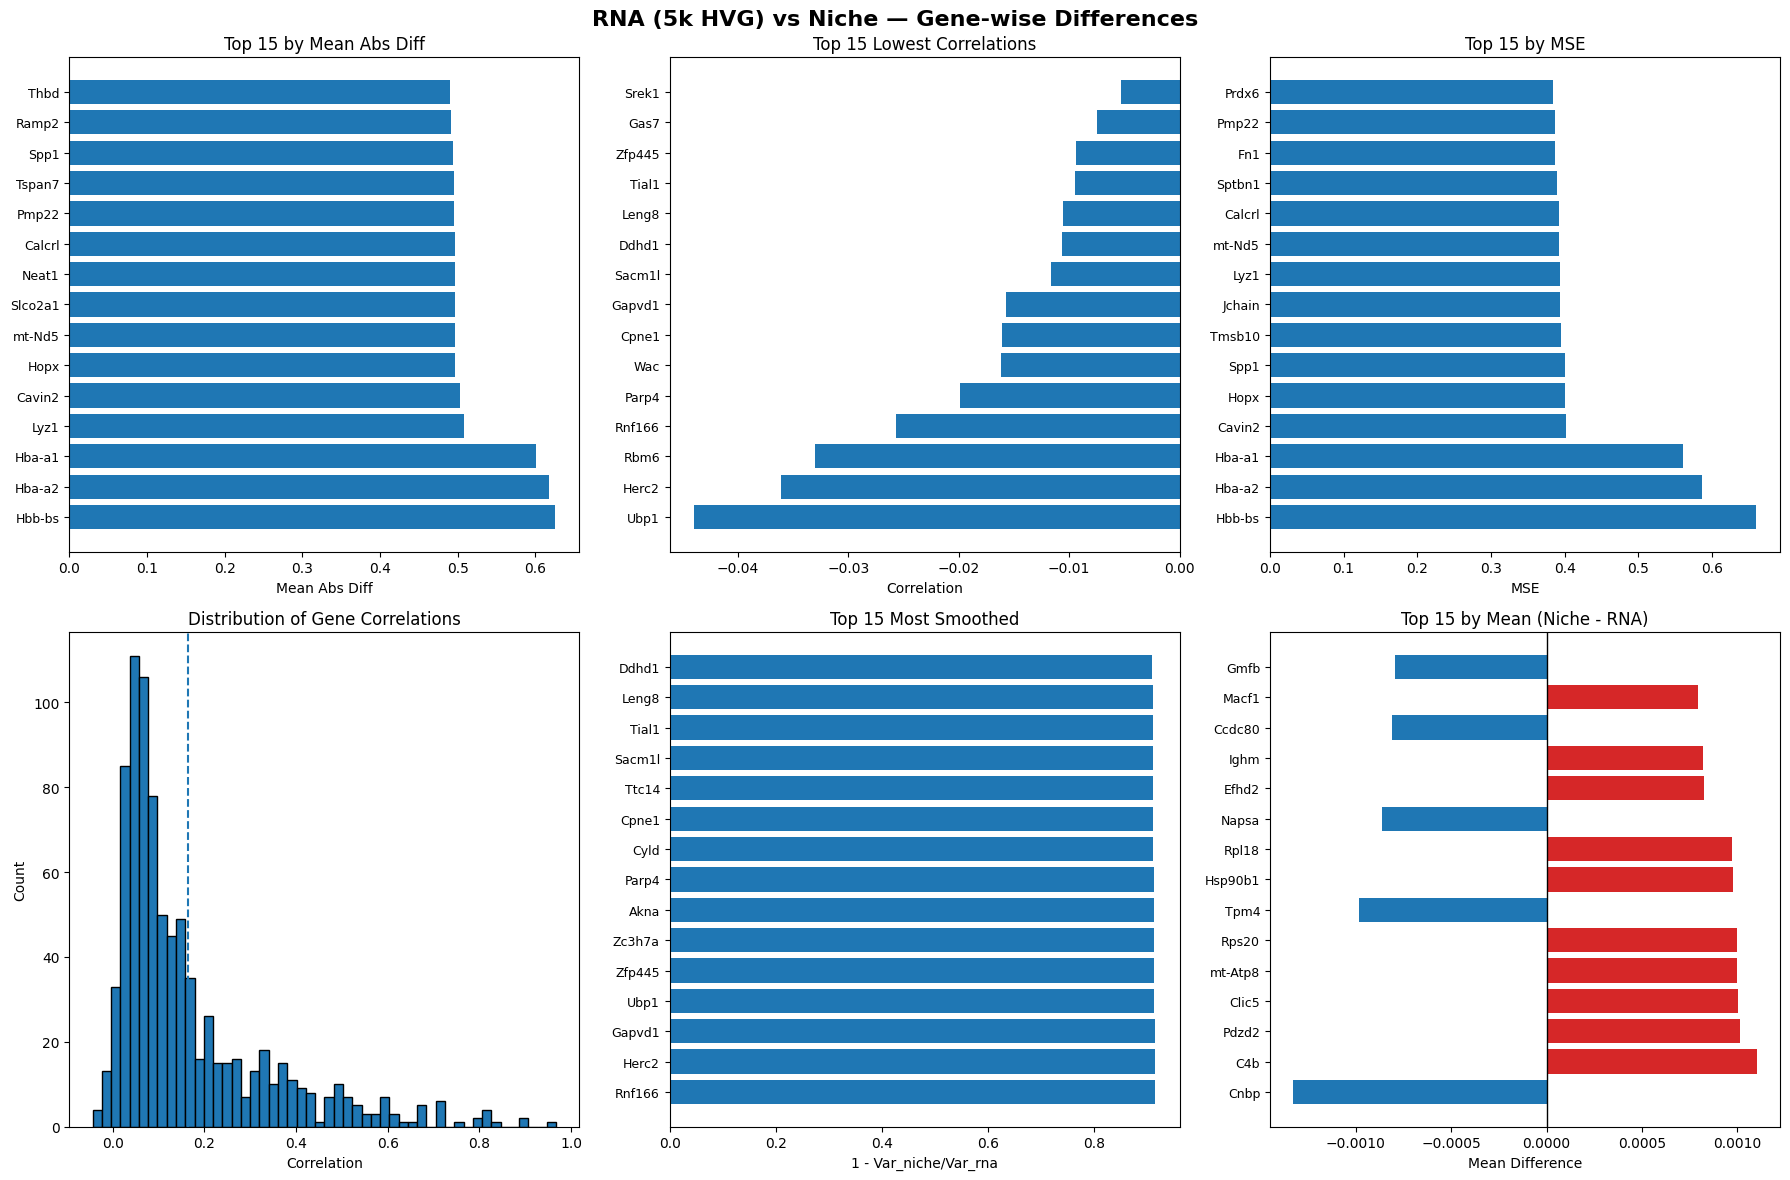

Saved dashboard -> ./perturbmap_rna_niche_comprehensive_analysis_5k.png


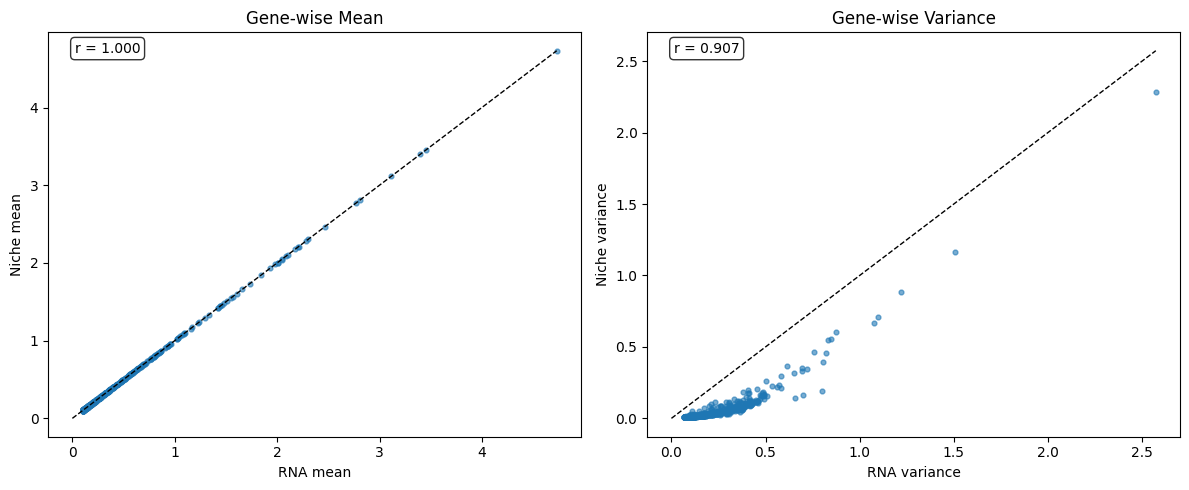

Saved correlation figure -> ./perturbmap_rna_niche_correlation_analysis_5k.png

=== HEADLINES (5k) ===
- Mean corr (gene-level corr avg over filtered): 0.164
- Genes with corr < 0.5: 804
- Genes with >50% variance reduction: 844
- Mean smoothing effect: 0.845


In [29]:
# %% [markdown]
# ## Downsize RNA to 5k HVGs, mirror genes in Niche, then compare
# Requires in memory:

niche_hvg = sc.read('../../Data/processed_data/GSM5808054_niche_modality.h5ad')

# %%
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import scanpy as sc
import warnings, os
warnings.filterwarnings("ignore")

TARGET_K = 5000
OUTPUT_DIR = "./"
MIN_EXPR_FOR_PLOTS = 0.1
TOP_N = 15

# -------- helpers --------
def _ensure_unique_varnames(adata):
    if not adata.var_names.is_unique:
        adata.var_names_make_unique()

def _select_hvgs_from_rna(rna, target_k=5000):
    """
    Compute HVGs on a copy of `rna` and return a ranked gene list + top-k.
    Works across scanpy versions (seurat/seurat_v3/cell_ranger flavors).
    """
    _ensure_unique_varnames(rna)
    work = rna.copy()

    # lightweight normalization just for HVG ranking
    import scanpy as sc
    sc.pp.normalize_total(work, target_sum=1e4)
    sc.pp.log1p(work)

    # get per-gene variability metrics for all genes
    sc.pp.highly_variable_genes(work, n_top_genes=None)

    var = work.var
    # Pick the best available scoring column
    score_col = None
    for cand in ["variances_norm", "dispersions_norm", "variances", "dispersions"]:
        if cand in var.columns:
            score_col = cand
            break
    if score_col is None:
        # last resort: use inverse of rank if available
        if "highly_variable_rank" in var.columns:
            var["__score__"] = -var["highly_variable_rank"].fillna(var["highly_variable_rank"].max()+1)
            score_col = "__score__"
        else:
            raise KeyError(
                "Could not find a variability score column (expected one of "
                "'variances_norm','dispersions_norm','variances','dispersions', "
                "or 'highly_variable_rank')."
            )

    rank = var[[score_col]].copy()
    rank["gene"] = work.var_names
    # larger score = more variable (except the inverse-rank fallback already negated)
    rank = rank.sort_values(score_col, ascending=False, kind="mergesort").reset_index(drop=True)
    ranked_genes = rank["gene"].tolist()
    topk = ranked_genes[:target_k]
    return ranked_genes, topk


def _best_effort_match_in_both(ranked, adata_other, target_k):
    """
    From a ranked gene list (RNA HVG ranking), select exactly target_k genes
    that exist in adata_other. If not enough, returns as many as available.
    """
    other_set = set(map(str, adata_other.var_names))
    picked = [g for g in ranked if g in other_set]
    if len(picked) >= target_k:
        return picked[:target_k]
    # Not enough; return whatever we have (warn)
    print(f"[WARN] Only {len(picked)} of the ranked genes exist in the niche object; using all available.")
    return picked

def _align_pair_by_genes_and_cells(a, b, genes, prefer_sorted=True):
    # cells intersection
    cells = sorted(list(set(map(str, a.obs_names)) & set(map(str, b.obs_names)))) if prefer_sorted else \
            list(set(a.obs_names) & set(b.obs_names))
    if len(cells) == 0:
        raise ValueError("No common cells between RNA and niche after alignment.")
    a_sub = a[cells, genes].copy()
    b_sub = b[cells, genes].copy()
    # sanity
    assert (a_sub.var_names == b_sub.var_names).all()
    assert (a_sub.obs_names == b_sub.obs_names).all()
    return a_sub, b_sub

def _col_as_dense(X, i):
    col = X[:, i]
    if sp.issparse(col):
        return col.toarray().ravel()
    return np.asarray(col).ravel()

def _means_sparse_safe(X):
    if sp.issparse(X):
        return np.asarray(X.mean(axis=0)).ravel()
    return X.mean(axis=0).ravel()

def _vars_sparse_safe(X):
    if sp.issparse(X):
        Ex  = np.asarray(X.mean(axis=0)).ravel()
        Ex2 = np.asarray((X.multiply(X)).mean(axis=0)).ravel()
        return Ex2 - Ex**2
    X = np.asarray(X)
    return X.var(axis=0)

# -------- 1) pick 5k HVGs from RNA and mirror in Niche --------
_ensure_unique_varnames(rna)
_ensure_unique_varnames(niche_hvg)

ranked, rna_topk = _select_hvgs_from_rna(rna, target_k=TARGET_K)
genes_5k_in_both = _best_effort_match_in_both(ranked, niche_hvg, TARGET_K)

print(f"Requested {TARGET_K} HVGs; using {len(genes_5k_in_both)} genes present in both objects.")

rna_5k, niche_5k = _align_pair_by_genes_and_cells(rna, niche_hvg, genes_5k_in_both, prefer_sorted=True)
N, G = rna_5k.shape
print(f"[Aligned 5k] cells={N}, genes={G}")

# -------- 2) compute per-gene metrics --------
stats = []
for i, gene in enumerate(rna_5k.var_names):
    if i % 500 == 0:
        print(f"  metrics for gene {i+1}/{G}")
    rvals = _col_as_dense(rna_5k.X, i)
    nvals = _col_as_dense(niche_5k.X, i)

    if (rvals == 0).all() and (nvals == 0).all():
        continue

    r_mean  = float(rvals.mean())
    n_mean  = float(nvals.mean())
    r_var   = float(rvals.var())
    n_var   = float(nvals.var())
    mean_diff = n_mean - r_mean
    var_ratio = n_var / (r_var + 1e-10)
    smoothing_effect = 1.0 - var_ratio
    mse = float(mean_squared_error(rvals, nvals))
    corr = float(pearsonr(rvals, nvals)[0]) if (rvals.std() > 0 and nvals.std() > 0) else 0.0
    mad = float(np.mean(np.abs(rvals - nvals)))

    stats.append({
        "gene": gene,
        "mean_abs_diff": mad,
        "mse": mse,
        "correlation": corr,
        "rna_mean": r_mean,
        "niche_mean": n_mean,
        "mean_diff": mean_diff,
        "rna_var": r_var,
        "niche_var": n_var,
        "var_ratio": var_ratio,
        "max_expr": max(r_mean, n_mean),
        "smoothing_effect": smoothing_effect
    })

df_stats = pd.DataFrame(stats)
csv_path = os.path.join(OUTPUT_DIR, "perturbmap_rna_vs_niche_gene_comparison_5k.csv")
df_stats.to_csv(csv_path, index=False)
print(f"Saved per-gene stats -> {csv_path}")

# -------- 3) plots --------
df_plot = df_stats[df_stats["max_expr"] > MIN_EXPR_FOR_PLOTS].copy()
if len(df_plot) == 0:
    print(f"No genes exceed min_expr={MIN_EXPR_FOR_PLOTS}; skipping plots.")
else:
    print("\nSummary (5k HVG set, filtered):")
    print(f"  n_genes: {len(df_plot)}")
    print(f"  mean(correlation): {df_plot['correlation'].mean():.3f}")
    print(f"  median(correlation): {df_plot['correlation'].median():.3f}")
    print(f"  mean(mean_abs_diff): {df_plot['mean_abs_diff'].mean():.3f}")
    print(f"  mean(smoothing_effect): {df_plot['smoothing_effect'].mean():.3f}")

    # Dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('RNA (5k HVG) vs Niche — Gene-wise Differences', fontsize=16, fontweight='bold')

    top_diff = df_plot.nlargest(TOP_N, "mean_abs_diff")
    axes[0,0].barh(range(len(top_diff)), top_diff["mean_abs_diff"])
    axes[0,0].set_yticks(range(len(top_diff))); axes[0,0].set_yticklabels(top_diff["gene"], fontsize=9)
    axes[0,0].set_title(f"Top {TOP_N} by Mean Abs Diff"); axes[0,0].set_xlabel("Mean Abs Diff")

    low_corr = df_plot.nsmallest(TOP_N, "correlation")
    axes[0,1].barh(range(len(low_corr)), low_corr["correlation"])
    axes[0,1].set_yticks(range(len(low_corr))); axes[0,1].set_yticklabels(low_corr["gene"], fontsize=9)
    axes[0,1].set_title(f"Top {TOP_N} Lowest Correlations"); axes[0,1].set_xlabel("Correlation")

    top_mse = df_plot.nlargest(TOP_N, "mse")
    axes[0,2].barh(range(len(top_mse)), top_mse["mse"])
    axes[0,2].set_yticks(range(len(top_mse))); axes[0,2].set_yticklabels(top_mse["gene"], fontsize=9)
    axes[0,2].set_title(f"Top {TOP_N} by MSE"); axes[0,2].set_xlabel("MSE")

    axes[1,0].hist(df_plot["correlation"].dropna(), bins=50, edgecolor='black')
    axes[1,0].axvline(df_plot["correlation"].mean(), linestyle='--')
    axes[1,0].set_title("Distribution of Gene Correlations"); axes[1,0].set_xlabel("Correlation"); axes[1,0].set_ylabel("Count")

    most_smoothed = df_plot.nlargest(TOP_N, "smoothing_effect")
    axes[1,1].barh(range(len(most_smoothed)), most_smoothed["smoothing_effect"])
    axes[1,1].set_yticks(range(len(most_smoothed))); axes[1,1].set_yticklabels(most_smoothed["gene"], fontsize=9)
    axes[1,1].set_title(f"Top {TOP_N} Most Smoothed"); axes[1,1].set_xlabel("1 - Var_niche/Var_rna")

    mean_diffs = df_plot.copy(); mean_diffs["abs_mean_diff"] = np.abs(mean_diffs["mean_diff"])
    top_mean_diff = mean_diffs.nlargest(TOP_N, "abs_mean_diff")
    colors = ["C3" if x > 0 else "C0" for x in top_mean_diff["mean_diff"]]
    axes[1,2].barh(range(len(top_mean_diff)), top_mean_diff["mean_diff"], color=colors)
    axes[1,2].set_yticks(range(len(top_mean_diff))); axes[1,2].set_yticklabels(top_mean_diff["gene"], fontsize=9)
    axes[1,2].axvline(0, color='k', linewidth=1)
    axes[1,2].set_title(f"Top {TOP_N} by Mean (Niche - RNA)"); axes[1,2].set_xlabel("Mean Difference")

    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "perturbmap_rna_niche_comprehensive_analysis_5k.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight'); plt.show()
    print(f"Saved dashboard -> {fig_path}")

    # Overall mean/variance correlation (use same 5k set)
    rna_mean  = _means_sparse_safe(rna_5k.X)
    niche_mean = _means_sparse_safe(niche_5k.X)
    rna_var   = _vars_sparse_safe(rna_5k.X)
    niche_var  = _vars_sparse_safe(niche_5k.X)

    # limit points to genes in df_plot for readability
    keep = df_plot["gene"].values
    idx = pd.Index(rna_5k.var_names).get_indexer(keep)

    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
    axes2[0].scatter(rna_mean[idx], niche_mean[idx], s=12, alpha=0.6)
    lim = float(max(rna_mean[idx].max(), niche_mean[idx].max()))
    axes2[0].plot([0, lim], [0, lim], 'k--', linewidth=1)
    axes2[0].set_xlabel("RNA mean"); axes2[0].set_ylabel("Niche mean"); axes2[0].set_title("Gene-wise Mean")

    mean_corr = float(np.corrcoef(rna_mean[idx], niche_mean[idx])[0,1])
    axes2[0].text(0.05, 0.95, f"r = {mean_corr:.3f}", transform=axes2[0].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    axes2[1].scatter(rna_var[idx], niche_var[idx], s=12, alpha=0.6)
    limv = float(max(rna_var[idx].max(), niche_var[idx].max()))
    axes2[1].plot([0, limv], [0, limv], 'k--', linewidth=1)
    axes2[1].set_xlabel("RNA variance"); axes2[1].set_ylabel("Niche variance"); axes2[1].set_title("Gene-wise Variance")

    var_corr = float(np.corrcoef(rna_var[idx], niche_var[idx])[0,1])
    axes2[1].text(0.05, 0.95, f"r = {var_corr:.3f}", transform=axes2[1].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    fig2_path = os.path.join(OUTPUT_DIR, "perturbmap_rna_niche_correlation_analysis_5k.png")
    plt.savefig(fig2_path, dpi=300, bbox_inches='tight'); plt.show()
    print(f"Saved correlation figure -> {fig2_path}")

    print("\n=== HEADLINES (5k) ===")
    print(f"- Mean corr (gene-level corr avg over filtered): {df_plot['correlation'].mean():.3f}")
    print(f"- Genes with corr < 0.5: {(df_plot['correlation'] < 0.5).sum()}")
    print(f"- Genes with >50% variance reduction: {(df_plot['smoothing_effect'] > 0.5).sum()}")
    print(f"- Mean smoothing effect: {df_plot['smoothing_effect'].mean():.3f}")


In [3]:
adata = sc.read('../../Data/processed_data/adata_Tgfbr2_1_hvg.h5ad')
adata

AnnData object with n_obs × n_vars = 25 × 4001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

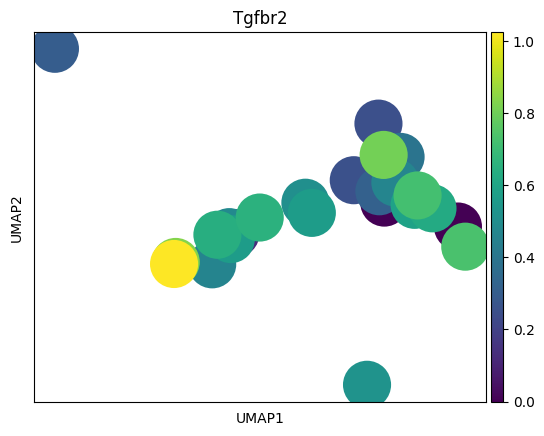

In [4]:
sc.pl.umap(adata, color="Tgfbr2")


In [5]:
adata = sc.read('../../Data/processed_data/adata_KP_1-2_hvg.h5ad')
adata

AnnData object with n_obs × n_vars = 65 × 4001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

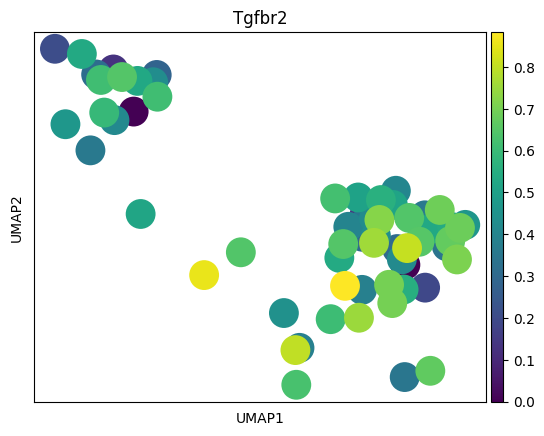

In [6]:
sc.pl.umap(adata, color="Tgfbr2")


In [7]:
adatatest = sc.read('../../Data/UnitedNet/input_data/adata_rna_train_perturbmap_KP2_1.h5ad')
adatatest

AnnData object with n_obs × n_vars = 52 × 4001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [4]:
active = sc.read('../../Data/processed_data/activity_KP12_total.h5ad')
active

AnnData object with n_obs × n_vars = 478 × 4001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'nCount_Spatial', 'nFeature_Spatial', 'leiden_clusters', 'phenotypes_mod'
    var: 'activity_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'hvg_calculation', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'scMINER_info', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [5]:
adata = sc.read('../../Data/processed_data/adata_joint_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 250 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

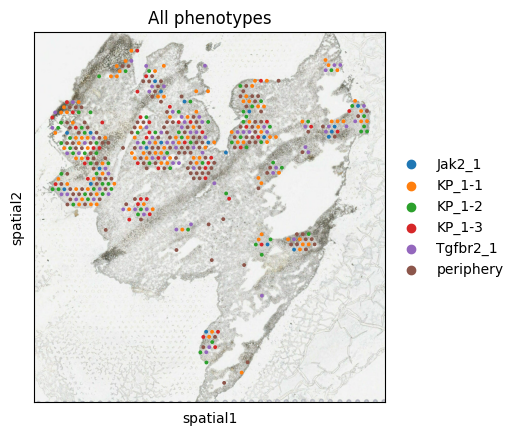

In [6]:
sc.pl.spatial(active, color=["phenotypes"], title=["All phenotypes"])

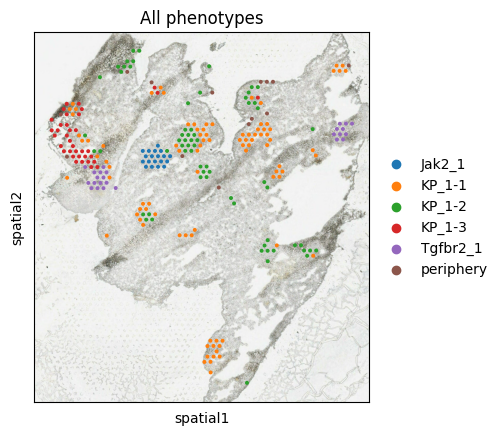

In [7]:
sc.pl.spatial(adata, color=["phenotypes"], title=["All phenotypes"])

Analyzing network connectivity...
NETWORK CONNECTIVITY ANALYSIS
Total GenKI genes: 81
GenKI genes with SHAP connections: 36
Coverage: 44.4%

Top 10 most connected GenKI genes:
  Igkc (Rank 11.0): 18 SHAP connections
  Tff2 (Rank 18.0): 18 SHAP connections
  Ambp (Rank 23.0): 17 SHAP connections
  Retnla (Rank 48.0): 17 SHAP connections
  Mt2 (Rank 49.0): 17 SHAP connections
  Ighg1 (Rank 20.0): 17 SHAP connections
  WPRE (Rank 80.0): 16 SHAP connections
  Sftpa1 (Rank 5.0): 16 SHAP connections
  Gm42418 (Rank 8.0): 16 SHAP connections
  Igha (Rank 10.0): 16 SHAP connections

SHAP Connection Statistics:
Total significant SHAP connections: 537
Unique target genes: 41
Average connections per GenKI gene: 14.9

Creating corrected alluvial plot...
Data loaded successfully!
Final gene list: 99 rows
SHAP connections: 1220 rows

Level 1: TGFBR2 (root)
Level 2: 12 GenKI genes with SHAP connections
Level 3: 33 significant SHAP targets

Total connections: 191
Level 1→2: 12
Level 2→3: 179

Plot sav

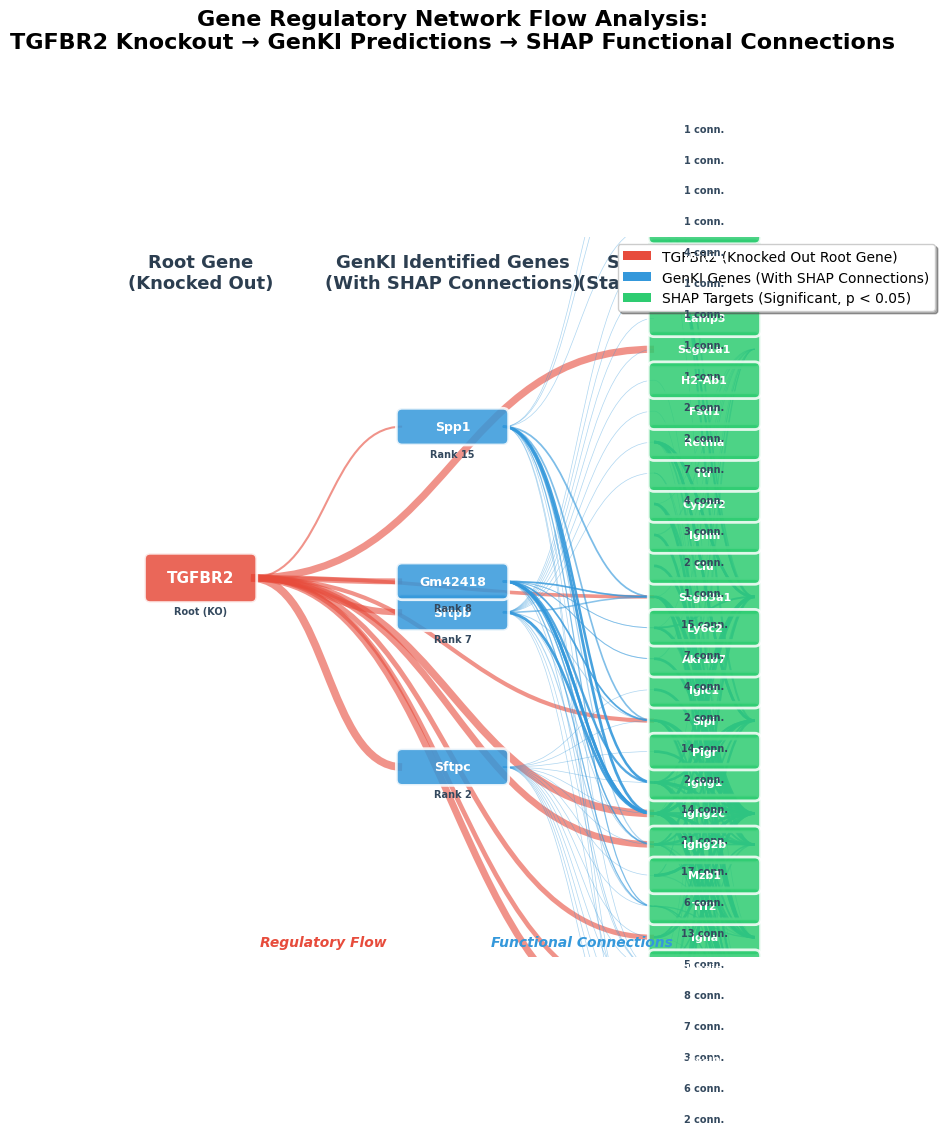


CORRECTED ALLUVIAL PLOT SUMMARY
Root Gene: TGFBR2 (Knockout target)
GenKI Genes with SHAP connections: 12
SHAP Target genes (significant): 33
Total regulatory connections: 191

Level 2 - GenKI Genes (connected to SHAP targets):
  Sftpc (Rank 2, Score: 5.9, 14 SHAP connections)
  Ighg2c (Rank 3, Score: 4.2, 16 SHAP connections)
  Scgb1a1 (Rank 4, Score: 3.6, 12 SHAP connections)
  Sftpa1 (Rank 5, Score: 3.5, 16 SHAP connections)
  Ighg2b (Rank 6, Score: 2.1, 15 SHAP connections)
  Sftpb (Rank 7, Score: 1.7, 15 SHAP connections)
  Gm42418 (Rank 8, Score: 1.7, 16 SHAP connections)
  Igha (Rank 10, Score: 1.1, 16 SHAP connections)
  Igkc (Rank 11, Score: 1.1, 18 SHAP connections)
  Slpi (Rank 12, Score: 0.9, 13 SHAP connections)
  Scgb3a1 (Rank 13, Score: 0.8, 15 SHAP connections)
  Spp1 (Rank 15, Score: 0.7, 13 SHAP connections)

Level 3 - SHAP Target Genes:
  Ighg2c (connected from 21 GenKI genes)
  Ighg2b (connected from 17 GenKI genes)
  Scgb3a1 (connected from 15 GenKI genes)
  Slpi 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.path import Path
import matplotlib.patches as mpatches
import seaborn as sns

def create_alluvial_plot_corrected(final_gene_csv, shap_summary_csv, output_file=None, figsize=(18, 12)):
    """
    Create an alluvial plot showing TGFBR2 → GenKI Genes → SHAP Connections
    Now properly using shap_connections_summary.csv where:
    - gene column = source (GenKI genes)
    - connected_gene column = target (SHAP connections)
    
    Parameters:
    final_gene_csv (str): Path to final_gene_list.csv
    shap_summary_csv (str): Path to shap_connections_summary.csv
    output_file (str): Path to save the plot (optional)
    figsize (tuple): Figure size (width, height)
    """
    
    # Read the data
    final_df = pd.read_csv(final_gene_csv)
    shap_df = pd.read_csv(shap_summary_csv)
    
    print("Data loaded successfully!")
    print(f"Final gene list: {len(final_df)} rows")
    print(f"SHAP connections: {len(shap_df)} rows")
    
    # Process the data
    # Get top 15 GenKI genes (excluding TGFBR2 itself for Level 2)
    genki_genes = final_df[(final_df['source'] == 'GenKI') & 
                          (final_df['genki_rank'] <= 15)].sort_values('genki_rank')
    
    # Filter out TGFBR2 from level 2 (we'll use it only as root in level 1)
    genki_genes_level2 = genki_genes[genki_genes['gene_name'] != 'TGFBR2'].copy()
    
    # Get SHAP connections that are statistically significant
    shap_significant = shap_df[shap_df['is_significant_deg'] == True].copy()
    
    # Find GenKI genes that have SHAP connections
    genki_genes_with_connections = shap_significant['gene'].unique()
    genki_connected = genki_genes_level2[
        genki_genes_level2['gene_name'].isin(genki_genes_with_connections)
    ].copy()
    
    # Get the connected targets (Level 3)
    connected_targets = shap_significant[
        shap_significant['gene'].isin(genki_connected['gene_name'])
    ]['connected_gene'].unique()
    
    print(f"\nLevel 1: TGFBR2 (root)")
    print(f"Level 2: {len(genki_connected)} GenKI genes with SHAP connections")
    print(f"Level 3: {len(connected_targets)} significant SHAP targets")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color scheme
    colors = {
        'root': '#e74c3c',     # Red for TGFBR2
        'genki': '#3498db',    # Blue for GenKI genes
        'shap': '#2ecc71',     # Green for SHAP targets
        'connection': '#95a5a6' # Gray for connections
    }
    
    # Layout parameters
    level_positions = [0.15, 0.5, 0.85]  # x positions for the three levels
    node_height = 0.035
    node_spacing = 0.008
    box_width = 0.14
    
    # Position calculations
    positions = {}
    
    # Level 1: TGFBR2 (centered)
    positions['TGFBR2'] = {
        'x': level_positions[0],
        'y': 0.5,
        'level': 1,
        'height': node_height * 1.5,  # Make root node larger
        'rank': 1
    }
    
    # Level 2: GenKI genes with connections
    total_height_l2 = len(genki_connected) * (node_height + node_spacing) - node_spacing
    start_y_l2 = 0.5 - total_height_l2 / 2
    
    for i, (_, gene) in enumerate(genki_connected.iterrows()):
        positions[gene['gene_name']] = {
            'x': level_positions[1],
            'y': start_y_l2 + i * (node_height + node_spacing),
            'level': 2,
            'height': node_height,
            'rank': gene['genki_rank'],
            'score': gene.get('genki_dis_score', 0)
        }
    
    # Level 3: SHAP targets
    total_height_l3 = len(connected_targets) * (node_height + node_spacing) - node_spacing
    start_y_l3 = 0.5 - total_height_l3 / 2
    
    for i, target in enumerate(connected_targets):
        # Count how many GenKI genes connect to this target
        connection_count = len(shap_significant[
            (shap_significant['connected_gene'] == target) & 
            (shap_significant['gene'].isin(genki_connected['gene_name']))
        ])
        
        positions[target] = {
            'x': level_positions[2],
            'y': start_y_l3 + i * (node_height + node_spacing),
            'level': 3,
            'height': node_height,
            'connection_count': connection_count
        }
    
    # Create connections data
    connections = []
    
    # Level 1 to Level 2: TGFBR2 to GenKI genes with connections
    for _, gene in genki_connected.iterrows():
        # Weight based on GenKI rank (higher rank = lower number = higher weight)
        weight = max(1, 16 - gene['genki_rank'])
        connections.append({
            'source': 'TGFBR2',
            'target': gene['gene_name'],
            'weight': weight,
            'level': 1,
            'type': 'regulatory'
        })
    
    # Level 2 to Level 3: GenKI genes to SHAP targets
    genki_to_shap = shap_significant[
        shap_significant['gene'].isin(genki_connected['gene_name'])
    ].copy()
    
    for _, connection in genki_to_shap.iterrows():
        # Weight based on SHAP value magnitude
        weight = abs(connection.get('shap_value', 1))
        connections.append({
            'source': connection['gene'],
            'target': connection['connected_gene'],
            'weight': weight,
            'level': 2,
            'type': 'functional',
            'direction': connection.get('direction', 'unknown'),
            'shap_value': connection.get('shap_value', 0)
        })
    
    print(f"\nTotal connections: {len(connections)}")
    print(f"Level 1→2: {sum(1 for c in connections if c['level'] == 1)}")
    print(f"Level 2→3: {sum(1 for c in connections if c['level'] == 2)}")
    
    # Draw connections (Bezier curves)
    def draw_bezier_connection(source_pos, target_pos, weight, color, alpha=0.6, connection_info=None):
        """Draw a Bezier curve connection between two nodes"""
        source_x = source_pos['x'] + box_width/2
        source_y = source_pos['y'] + source_pos['height']/2
        target_x = target_pos['x'] - box_width/2
        target_y = target_pos['y'] + target_pos['height']/2
        
        # Control points for Bezier curve
        mid_x = (source_x + target_x) / 2
        ctrl1_x, ctrl1_y = mid_x, source_y
        ctrl2_x, ctrl2_y = mid_x, target_y
        
        # Create path
        verts = [
            (source_x, source_y),           # Start point
            (ctrl1_x, ctrl1_y),             # Control point 1
            (ctrl2_x, ctrl2_y),             # Control point 2
            (target_x, target_y)            # End point
        ]
        
        codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
        path = Path(verts, codes)
        
        # Line width based on weight
        if connection_info and connection_info['level'] == 2:
            # For SHAP connections, use absolute SHAP value for thickness
            line_width = max(0.5, min(8, abs(weight) * 2))
        else:
            # For GenKI connections, use rank-based weight
            line_width = max(1, min(8, np.sqrt(weight) * 1.5))
        
        # Color intensity based on connection strength
        if connection_info and connection_info['level'] == 2:
            # Vary alpha based on SHAP value strength
            alpha = max(0.4, min(0.9, abs(weight) / max(abs(c['shap_value']) for c in connections if 'shap_value' in c)))
        
        patch = mpatches.PathPatch(path, facecolor='none', edgecolor=color, 
                                 linewidth=line_width, alpha=alpha)
        ax.add_patch(patch)
        
        return patch
    
    # Draw all connections
    connection_patches = []
    for conn in connections:
        if conn['source'] in positions and conn['target'] in positions:
            source_pos = positions[conn['source']]
            target_pos = positions[conn['target']]
            
            color = colors['root'] if conn['level'] == 1 else colors['genki']
            patch = draw_bezier_connection(source_pos, target_pos, conn['weight'], color, connection_info=conn)
            connection_patches.append(patch)
    
    # Draw nodes
    node_patches = {}
    
    for name, pos in positions.items():
        # Determine color based on level
        if pos['level'] == 1:
            color = colors['root']
        elif pos['level'] == 2:
            color = colors['genki']
        else:
            color = colors['shap']
        
        # Create rounded rectangle
        box = FancyBboxPatch(
            (pos['x'] - box_width/2, pos['y']),
            box_width, pos['height'],
            boxstyle="round,pad=0.008",
            facecolor=color,
            edgecolor='white',
            linewidth=2,
            alpha=0.85
        )
        ax.add_patch(box)
        node_patches[name] = box
        
        # Add text label with font size adjustment
        font_size = 11 if pos['level'] == 1 else (9 if pos['level'] == 2 else 8)
        font_weight = 'bold' if pos['level'] == 1 else 'semibold'
        
        ax.text(pos['x'], pos['y'] + pos['height']/2, name,
               ha='center', va='center', fontsize=font_size, fontweight=font_weight,
               color='white', zorder=10)
        
        # Add additional information below the node
        info_text = ""
        if pos['level'] == 1:
            info_text = "Root (KO)"
        elif pos['level'] == 2 and 'rank' in pos:
            info_text = f"Rank {int(pos['rank'])}"
        elif pos['level'] == 3 and 'connection_count' in pos:
            info_text = f"{int(pos['connection_count'])} conn."
        
        if info_text:
            ax.text(pos['x'], pos['y'] - 0.02, info_text,
                   ha='center', va='center', fontsize=7,
                   color='#34495e', zorder=10, fontweight='semibold')
    
    # Add level labels
    level_labels = ['Root Gene\n(Knocked Out)', 'GenKI Identified Genes\n(With SHAP Connections)', 'SHAP Target Genes\n(Statistically Significant)']
    for i, label in enumerate(level_labels):
        ax.text(level_positions[i], 0.95, label,
               ha='center', va='center', fontsize=13, fontweight='bold',
               color='#2c3e50')
    
    # Add connection type indicators
    ax.text(0.32, 0.02, 'Regulatory Flow', ha='center', va='center', 
           fontsize=10, color=colors['root'], fontweight='bold', style='italic')
    ax.text(0.68, 0.02, 'Functional Connections', ha='center', va='center', 
           fontsize=10, color=colors['genki'], fontweight='bold', style='italic')
    
    # Create legend
    legend_elements = [
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['root'], 
                          label='TGFBR2 (Knocked Out Root Gene)'),
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['genki'], 
                          label='GenKI Genes (With SHAP Connections)'),
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['shap'], 
                          label='SHAP Targets (Significant, p < 0.05)')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.18, 1), 
             frameon=True, fancybox=True, shadow=True)
    
    # Formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Title
    plt.suptitle('Gene Regulatory Network Flow Analysis:\nTGFBR2 Knockout → GenKI Predictions → SHAP Functional Connections',
                fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"\nPlot saved to {output_file}")
    
    plt.show()
    
    # Print detailed summary statistics
    print("\n" + "="*60)
    print("CORRECTED ALLUVIAL PLOT SUMMARY")
    print("="*60)
    print(f"Root Gene: TGFBR2 (Knockout target)")
    print(f"GenKI Genes with SHAP connections: {len(genki_connected)}")
    print(f"SHAP Target genes (significant): {len(connected_targets)}")
    print(f"Total regulatory connections: {len(connections)}")
    
    print(f"\nLevel 2 - GenKI Genes (connected to SHAP targets):")
    for _, gene in genki_connected.iterrows():
        score = gene.get('genki_dis_score', 0)
        shap_count = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        if pd.notna(score):
            print(f"  {gene['gene_name']} (Rank {int(gene['genki_rank'])}, Score: {score:.1f}, {shap_count} SHAP connections)")
        else:
            print(f"  {gene['gene_name']} (Rank {int(gene['genki_rank'])}, {shap_count} SHAP connections)")
    
    print(f"\nLevel 3 - SHAP Target Genes:")
    target_counts = shap_significant[shap_significant['gene'].isin(genki_connected['gene_name'])]['connected_gene'].value_counts()
    for target, count in target_counts.head(10).items():
        print(f"  {target} (connected from {count} GenKI genes)")
    
    # Analysis of connection types
    print(f"\nConnection Analysis:")
    direction_counts = shap_significant[shap_significant['gene'].isin(genki_connected['gene_name'])]['direction'].value_counts()
    for direction, count in direction_counts.items():
        print(f"  {direction} connections: {count}")
    
    return fig, ax, positions, connections, genki_connected, connected_targets


def create_network_statistics(final_gene_csv, shap_summary_csv):
    """
    Generate detailed statistics about the network connections
    """
    final_df = pd.read_csv(final_gene_csv)
    shap_df = pd.read_csv(shap_summary_csv)
    
    # Get GenKI genes
    genki_genes = final_df[final_df['source'] == 'GenKI'].copy()
    
    # Get significant SHAP connections
    shap_sig = shap_df[shap_df['is_significant_deg'] == True].copy()
    
    print("NETWORK CONNECTIVITY ANALYSIS")
    print("="*50)
    
    # GenKI genes with SHAP connections
    genki_with_shap = set(shap_sig['gene'].unique())
    genki_genes_connected = genki_genes[genki_genes['gene_name'].isin(genki_with_shap)]
    
    print(f"Total GenKI genes: {len(genki_genes)}")
    print(f"GenKI genes with SHAP connections: {len(genki_genes_connected)}")
    print(f"Coverage: {len(genki_genes_connected)/len(genki_genes)*100:.1f}%")
    
    # Top connected GenKI genes
    connection_counts = shap_sig['gene'].value_counts()
    print(f"\nTop 10 most connected GenKI genes:")
    for gene, count in connection_counts.head(10).items():
        rank = genki_genes[genki_genes['gene_name'] == gene]['genki_rank'].iloc[0] if len(genki_genes[genki_genes['gene_name'] == gene]) > 0 else 'N/A'
        print(f"  {gene} (Rank {rank}): {count} SHAP connections")
    
    # SHAP value distribution
    print(f"\nSHAP Connection Statistics:")
    print(f"Total significant SHAP connections: {len(shap_sig)}")
    print(f"Unique target genes: {len(shap_sig['connected_gene'].unique())}")
    print(f"Average connections per GenKI gene: {len(shap_sig)/len(genki_with_shap):.1f}")
    
    return genki_genes_connected, shap_sig


# Example usage
if __name__ == "__main__":
    # Generate network statistics
    print("Analyzing network connectivity...")
    genki_connected, shap_data = create_network_statistics(
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/final_gene_list.csv', 
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/shap_connections_summary.csv'
    )
    
    print("\n" + "="*60)
    
    # Create the corrected matplotlib alluvial plot
    print("Creating corrected alluvial plot...")
    fig, ax, positions, connections, genki_genes, targets = create_alluvial_plot_corrected(
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/final_gene_list.csv', 
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/shap_connections_summary.csv',
        output_file='corrected_alluvial_plot.png'
    )
    
    print("\nDone! The plot now correctly shows:")
    print("- Level 1: TGFBR2 (root knockout gene)")
    print("- Level 2: GenKI genes that have SHAP connections (not including TGFBR2)")
    print("- Level 3: Statistically significant SHAP target genes")
    print("- Connections are based on actual SHAP analysis results")

In [2]:
!pwd

/home/ggavriilidis/Mongoose/Scripts/old_scripts


In [10]:
import pandas as pd
import numpy as np

def create_simplified_plotly_alluvial(final_gene_csv, shap_summary_csv, output_file=None):
    """
    Create a simplified interactive Plotly Sankey diagram showing:
    - TGFBR2 (root)
    - Top 5 GenKI genes with SHAP connections
    - Top 2 most representative SHAP connections for each GenKI gene
    """
    try:
        import plotly.graph_objects as go
        import plotly.offline as pyo
    except ImportError:
        print("ERROR: Plotly not installed. Install with: pip install plotly")
        return None
    
    print("Loading data...")
    # Read and process data
    final_df = pd.read_csv(final_gene_csv)
    shap_df = pd.read_csv(shap_summary_csv)
    
    print(f"Final gene list: {len(final_df)} rows")
    print(f"SHAP connections: {len(shap_df)} rows")
    
    # Get GenKI genes (excluding TGFBR2 from level 2)
    genki_genes = final_df[(final_df['source'] == 'GenKI') & 
                          (final_df['gene_name'] != 'TGFBR2')].sort_values('genki_rank')
    
    # Get significant SHAP connections
    shap_significant = shap_df[shap_df['is_significant_deg'] == True].copy()
    
    print(f"GenKI genes available: {len(genki_genes)}")
    print(f"Significant SHAP connections: {len(shap_significant)}")
    
    # Find top 5 GenKI genes that have SHAP connections
    genki_genes_with_connections = shap_significant['gene'].unique()
    genki_connected = genki_genes[
        genki_genes['gene_name'].isin(genki_genes_with_connections)
    ].head(5).copy()  # Top 5 only
    
    print(f"Top 5 GenKI genes with SHAP connections:")
    for _, gene in genki_connected.iterrows():
        shap_count = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        print(f"  {gene['gene_name']} (Rank {int(gene['genki_rank'])}) - {shap_count} SHAP connections")
    
    # For each of the top 5 GenKI genes, get their top 2 SHAP connections
    selected_shap_connections = []
    for _, genki_gene in genki_connected.iterrows():
        gene_shap_connections = shap_significant[
            shap_significant['gene'] == genki_gene['gene_name']
        ].copy()
        
        # Sort by absolute SHAP value and take top 2
        gene_shap_connections['abs_shap'] = gene_shap_connections['shap_value'].abs()
        top_connections = gene_shap_connections.nlargest(2, 'abs_shap')
        
        for _, conn in top_connections.iterrows():
            selected_shap_connections.append(conn)
    
    selected_shap_df = pd.DataFrame(selected_shap_connections)
    unique_targets = selected_shap_df['connected_gene'].unique()
    
    print(f"\nSelected SHAP targets ({len(unique_targets)} unique):")
    for target in unique_targets[:10]:  # Show first 10
        count = len(selected_shap_df[selected_shap_df['connected_gene'] == target])
        print(f"  {target} (connected from {count} GenKI genes)")
    
    # Create node labels
    genki_labels = [f"{gene} (R{int(rank)})" for gene, rank in 
                   zip(genki_connected['gene_name'], genki_connected['genki_rank'])]
    
    labels = ['TGFBR2 (Root KO)'] + genki_labels + list(unique_targets)
    
    # Create color scheme
    node_colors = (['#e74c3c'] +  # Red for TGFBR2
                   ['#3498db'] * len(genki_connected) +  # Blue for GenKI genes
                   ['#2ecc71'] * len(unique_targets))  # Green for SHAP targets
    
    print(f"\nTotal nodes: {len(labels)}")
    print(f"- Root: 1 (TGFBR2)")
    print(f"- GenKI: {len(genki_connected)}")  
    print(f"- SHAP targets: {len(unique_targets)}")
    
    # Create mappings
    label_to_idx = {}
    label_to_idx['TGFBR2'] = 0
    for i, gene in enumerate(genki_connected['gene_name']):
        label_to_idx[gene] = i + 1
    for i, target in enumerate(unique_targets):
        label_to_idx[target] = i + 1 + len(genki_connected)
    
    # Build connections
    source_list = []
    target_list = []
    value_list = []
    hover_info = []
    
    print("\nBuilding connections...")
    
    # Level 1 to Level 2: TGFBR2 to top 5 GenKI genes
    for _, gene in genki_connected.iterrows():
        source_list.append(0)  # TGFBR2 index
        target_list.append(label_to_idx[gene['gene_name']])
        weight = max(2, 20 - gene['genki_rank'])  # Higher rank = higher value
        value_list.append(weight)
        hover_info.append(f"TGFBR2 → {gene['gene_name']} (GenKI Rank {int(gene['genki_rank'])})")
    
    # Level 2 to Level 3: GenKI genes to their top 2 SHAP connections
    for _, connection in selected_shap_df.iterrows():
        if connection['gene'] in label_to_idx and connection['connected_gene'] in label_to_idx:
            source_list.append(label_to_idx[connection['gene']])
            target_list.append(label_to_idx[connection['connected_gene']])
            # Use SHAP value magnitude for connection strength
            shap_val = abs(connection.get('shap_value', 1))
            value_list.append(shap_val * 10)  # Scale up for visibility
            direction = connection.get('direction', 'unknown')
            hover_info.append(f"{connection['gene']} → {connection['connected_gene']} "
                            f"(SHAP: {shap_val:.3f}, {direction})")
    
    print(f"Total connections: {len(source_list)}")
    print(f"- TGFBR2 → GenKI: {len(genki_connected)}")
    print(f"- GenKI → SHAP: {len(selected_shap_df)}")
    
    # Create custom hover text for nodes
    node_hover = []
    for i, label in enumerate(labels):
        if i == 0:
            node_hover.append("TGFBR2<br>Root gene knocked out in experiment<br>Connects to top 5 GenKI genes")
        elif i <= len(genki_connected):
            gene_name = label.split(' (')[0]
            gene_info = genki_connected[genki_connected['gene_name'] == gene_name].iloc[0]
            total_shap_count = len(shap_significant[shap_significant['gene'] == gene_name])
            score = gene_info.get('genki_dis_score', 0)
            node_hover.append(f"{gene_name}<br>GenKI Rank: {int(gene_info['genki_rank'])}<br>"
                            f"GenKI Score: {score:.2f}<br>"
                            f"Total SHAP Connections: {total_shap_count}<br>"
                            f"Showing: Top 2 connections")
        else:
            target_gene = label
            connection_count = len(selected_shap_df[selected_shap_df['connected_gene'] == target_gene])
            total_connections = len(shap_significant[shap_significant['connected_gene'] == target_gene])
            node_hover.append(f"{target_gene}<br>Connected from {connection_count}/5 top GenKI genes<br>"
                            f"Total connections in dataset: {total_connections}<br>"
                            "Statistically significant SHAP target")
    
    print("\nCreating Plotly Sankey diagram...")
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=30,
            line=dict(color="black", width=1.5),
            label=labels,
            color=node_colors,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=node_hover
        ),
        link=dict(
            source=source_list,
            target=target_list,
            value=value_list,
            color="rgba(128,128,128,0.5)",
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_info
        ),
        arrangement='snap'
    )])
    
    # Update layout
    fig.update_layout(
        title={
            'text': "Simplified Gene Regulatory Network Flow<br>" +
                   "TGFBR2 Knockout → Top 5 GenKI Genes → Representative SHAP Connections<br>" +
                   "<sub>Interactive Sankey Diagram - Hover for details</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        font_size=12,
        width=1500,
        height=800,
        margin=dict(l=80, r=80, t=120, b=60),
        plot_bgcolor='white',
        paper_bgcolor='#fafafa'
    )
    
    # Add level annotations
    fig.add_annotation(
        text="<b>Level 1</b><br>Root Gene<br>(Knockout Target)", 
        x=0.05, y=0.9, xref="paper", yref="paper",
        showarrow=False, font=dict(size=11, color="#e74c3c"),
        bgcolor="rgba(231,76,60,0.1)", bordercolor="#e74c3c", borderwidth=1,
        borderpad=4
    )
    fig.add_annotation(
        text="<b>Level 2</b><br>Top 5 GenKI Genes<br>(Predicted Affected)", 
        x=0.5, y=0.9, xref="paper", yref="paper",
        showarrow=False, font=dict(size=11, color="#3498db"),
        bgcolor="rgba(52,152,219,0.1)", bordercolor="#3498db", borderwidth=1,
        borderpad=4
    )
    fig.add_annotation(
        text="<b>Level 3</b><br>SHAP Target Genes<br>(Functional Connections)", 
        x=0.95, y=0.9, xref="paper", yref="paper",
        showarrow=False, font=dict(size=11, color="#2ecc71"),
        bgcolor="rgba(46,204,113,0.1)", bordercolor="#2ecc71", borderwidth=1,
        borderpad=4
    )
    
    # Add footer note
    fig.add_annotation(
        text="Note: Showing top 2 SHAP connections per GenKI gene for clarity. " +
             "Connection thickness represents relationship strength.",
        x=0.5, y=0.02, xref="paper", yref="paper",
        showarrow=False, font=dict(size=10, color="gray")
    )
    
    # Save if output file specified
    if output_file:
        html_file = output_file if output_file.endswith('.html') else f"{output_file}.html"
        fig.write_html(html_file)
        print(f"\n✅ Interactive Plotly plot saved to: {html_file}")
        
        # Also save as PNG if plotly-kaleido is available
        try:
            png_file = html_file.replace('.html', '.png')
            fig.write_image(png_file, width=1500, height=800, scale=2)
            print(f"✅ High-resolution PNG saved to: {png_file}")
        except:
            print("💡 Install plotly-kaleido for PNG export: pip install plotly-kaleido")
    
    # Show the plot
    print("\n🚀 Displaying interactive plot...")
    fig.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("📊 SIMPLIFIED ALLUVIAL PLOT SUMMARY")
    print("="*70)
    
    print(f"🎯 **Network Overview:**")
    print(f"   • Root Gene: TGFBR2 (knockout target)")
    print(f"   • GenKI Genes: {len(genki_connected)} (top-ranked with SHAP connections)")
    print(f"   • SHAP Targets: {len(unique_targets)} (most representative)")
    print(f"   • Total Connections: {len(source_list)}")
    
    print(f"\n🧬 **GenKI Genes (Level 2):**")
    for _, gene in genki_connected.iterrows():
        total_shap = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        shown_shap = len(selected_shap_df[selected_shap_df['gene'] == gene['gene_name']])
        score = gene.get('genki_dis_score', 0)
        print(f"   • {gene['gene_name']} (Rank {int(gene['genki_rank'])})")
        print(f"     - GenKI Score: {score:.1f}")
        print(f"     - SHAP Connections: {shown_shap}/2 shown (of {total_shap} total)")
    
    print(f"\n🔗 **Top SHAP Target Genes (Level 3):**")
    target_counts = selected_shap_df['connected_gene'].value_counts()
    for target, count in target_counts.head(8).items():
        total_count = len(shap_significant[shap_significant['connected_gene'] == target])
        print(f"   • {target}: Connected from {count}/5 GenKI genes (of {total_count} total)")
    
    return fig


def main():
    """
    Main function to create the simplified Plotly alluvial plot
    """
    print("🔬 Creating Simplified Gene Regulatory Network Visualization")
    print("="*60)
    
    try:
        fig = create_simplified_plotly_alluvial(
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/final_gene_list.csv', 
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/shap_connections_summary.csv',
            output_file='simplified_alluvial_interactive'
        )
        
        if fig:
            print("\n✅ SUCCESS: Interactive visualization created!")
            print("\n📋 **What the plot shows:**")
            print("   🔴 Level 1: TGFBR2 (root knockout gene)")
            print("   🔵 Level 2: Top 5 GenKI genes with SHAP connections")
            print("   🟢 Level 3: Most representative SHAP target genes (top 2 per GenKI gene)")
            print("\n💡 **How to use:**")
            print("   • Hover over nodes and connections for detailed information")
            print("   • Connection thickness shows relationship strength")
            print("   • Colors distinguish the three levels of the regulatory cascade")
        else:
            print("\n❌ FAILED: Could not create visualization")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("📦 Make sure you have the required files:")
        print("   • final_gene_list 1.csv")
        print("   • shap_connections_summary.csv")


# Example usage
if __name__ == "__main__":
    main()

🔬 Creating Simplified Gene Regulatory Network Visualization
Loading data...
Final gene list: 99 rows
SHAP connections: 1220 rows
GenKI genes available: 81
Significant SHAP connections: 537
Top 5 GenKI genes with SHAP connections:
  Sftpc (Rank 2) - 14 SHAP connections
  Ighg2c (Rank 3) - 16 SHAP connections
  Scgb1a1 (Rank 4) - 12 SHAP connections
  Sftpa1 (Rank 5) - 16 SHAP connections
  Ighg2b (Rank 6) - 15 SHAP connections

Selected SHAP targets (7 unique):
  Tff1 (connected from 1 GenKI genes)
  Cxcl9 (connected from 1 GenKI genes)
  Akr1b7 (connected from 2 GenKI genes)
  Ighg1 (connected from 1 GenKI genes)
  Ighm (connected from 1 GenKI genes)
  Ighg2c (connected from 3 GenKI genes)
  Slpi (connected from 1 GenKI genes)

Total nodes: 13
- Root: 1 (TGFBR2)
- GenKI: 5
- SHAP targets: 7

Building connections...
Total connections: 15
- TGFBR2 → GenKI: 5
- GenKI → SHAP: 10

Creating Plotly Sankey diagram...

✅ Interactive Plotly plot saved to: simplified_alluvial_interactive.html
💡 I


📊 SIMPLIFIED ALLUVIAL PLOT SUMMARY
🎯 **Network Overview:**
   • Root Gene: TGFBR2 (knockout target)
   • GenKI Genes: 5 (top-ranked with SHAP connections)
   • SHAP Targets: 7 (most representative)
   • Total Connections: 15

🧬 **GenKI Genes (Level 2):**
   • Sftpc (Rank 2)
     - GenKI Score: 5.9
     - SHAP Connections: 2/2 shown (of 14 total)
   • Ighg2c (Rank 3)
     - GenKI Score: 4.2
     - SHAP Connections: 2/2 shown (of 16 total)
   • Scgb1a1 (Rank 4)
     - GenKI Score: 3.6
     - SHAP Connections: 2/2 shown (of 12 total)
   • Sftpa1 (Rank 5)
     - GenKI Score: 3.5
     - SHAP Connections: 2/2 shown (of 16 total)
   • Ighg2b (Rank 6)
     - GenKI Score: 2.1
     - SHAP Connections: 2/2 shown (of 15 total)

🔗 **Top SHAP Target Genes (Level 3):**
   • Ighg2c: Connected from 3/5 GenKI genes (of 48 total)
   • Akr1b7: Connected from 2/5 GenKI genes (of 11 total)
   • Tff1: Connected from 1/5 GenKI genes (of 7 total)
   • Cxcl9: Connected from 1/5 GenKI genes (of 11 total)
   • I

In [14]:
import pandas as pd
import numpy as np

def create_simplified_plotly_alluvial(final_gene_csv, shap_summary_csv, output_file=None):
    """
    Create a simplified interactive Plotly Sankey diagram showing:
    - TGFBR2 (root)
    - Top 5 GenKI genes with SHAP connections
    - Top 2 most representative SHAP connections for each GenKI gene
    """
    try:
        import plotly.graph_objects as go
        import plotly.offline as pyo
    except ImportError:
        print("ERROR: Plotly not installed. Install with: pip install plotly")
        return None
    
    print("Loading data...")
    # Read and process data
    final_df = pd.read_csv(final_gene_csv)
    shap_df = pd.read_csv(shap_summary_csv)
    
    print(f"Final gene list: {len(final_df)} rows")
    print(f"SHAP connections: {len(shap_df)} rows")
    
    # Get GenKI genes (excluding TGFBR2 from level 2)
    genki_genes = final_df[(final_df['source'] == 'GenKI') & 
                          (final_df['gene_name'] != 'TGFBR2')].sort_values('genki_rank')
    
    # Get significant SHAP connections
    shap_significant = shap_df[shap_df['is_significant_deg'] == True].copy()
    
    print(f"GenKI genes available: {len(genki_genes)}")
    print(f"Significant SHAP connections: {len(shap_significant)}")
    
    # Find top 5 GenKI genes that have SHAP connections
    genki_genes_with_connections = shap_significant['gene'].unique()
    genki_connected = genki_genes[
        genki_genes['gene_name'].isin(genki_genes_with_connections)
    ].head(5).copy()  # Top 5 only
    
    print(f"Top 5 GenKI genes with SHAP connections:")
    for _, gene in genki_connected.iterrows():
        shap_count = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        print(f"  {gene['gene_name']} (Rank {int(gene['genki_rank'])}) - {shap_count} SHAP connections")
    
    # For each of the top 5 GenKI genes, get their top 2 SHAP connections
    selected_shap_connections = []
    for _, genki_gene in genki_connected.iterrows():
        gene_shap_connections = shap_significant[
            shap_significant['gene'] == genki_gene['gene_name']
        ].copy()
        
        # Sort by absolute SHAP value and take top 2
        gene_shap_connections['abs_shap'] = gene_shap_connections['shap_value'].abs()
        top_connections = gene_shap_connections.nlargest(2, 'abs_shap')
        
        for _, conn in top_connections.iterrows():
            selected_shap_connections.append(conn)
    
    selected_shap_df = pd.DataFrame(selected_shap_connections)
    unique_targets = selected_shap_df['connected_gene'].unique()
    
    print(f"\nSelected SHAP targets ({len(unique_targets)} unique):")
    for target in unique_targets[:10]:  # Show first 10
        count = len(selected_shap_df[selected_shap_df['connected_gene'] == target])
        print(f"  {target} (connected from {count} GenKI genes)")
    
    # Create node labels
    genki_labels = [f"{gene} (R{int(rank)})" for gene, rank in 
                   zip(genki_connected['gene_name'], genki_connected['genki_rank'])]
    
    labels = ['TGFBR2 (Root KO)'] + genki_labels + list(unique_targets)
    
    # Create color scheme
    node_colors = (['#e74c3c'] +  # Red for TGFBR2
                   ['#3498db'] * len(genki_connected) +  # Blue for GenKI genes
                   ['#2ecc71'] * len(unique_targets))  # Green for SHAP targets
    
    print(f"\nTotal nodes: {len(labels)}")
    print(f"- Root: 1 (TGFBR2)")
    print(f"- GenKI: {len(genki_connected)}")  
    print(f"- SHAP targets: {len(unique_targets)}")
    
    # Create mappings
    label_to_idx = {}
    label_to_idx['TGFBR2'] = 0
    for i, gene in enumerate(genki_connected['gene_name']):
        label_to_idx[gene] = i + 1
    for i, target in enumerate(unique_targets):
        label_to_idx[target] = i + 1 + len(genki_connected)
    
    # Build connections
    source_list = []
    target_list = []
    value_list = []
    hover_info = []
    
    print("\nBuilding connections...")
    
    # Level 1 to Level 2: TGFBR2 to top 5 GenKI genes
    for _, gene in genki_connected.iterrows():
        source_list.append(0)  # TGFBR2 index
        target_list.append(label_to_idx[gene['gene_name']])
        weight = max(2, 20 - gene['genki_rank'])  # Higher rank = higher value
        value_list.append(weight)
        hover_info.append(f"TGFBR2 → {gene['gene_name']} (GenKI Rank {int(gene['genki_rank'])})")
    
    # Level 2 to Level 3: GenKI genes to their top 2 SHAP connections
    for _, connection in selected_shap_df.iterrows():
        if connection['gene'] in label_to_idx and connection['connected_gene'] in label_to_idx:
            source_list.append(label_to_idx[connection['gene']])
            target_list.append(label_to_idx[connection['connected_gene']])
            # Use SHAP value magnitude for connection strength
            shap_val = abs(connection.get('shap_value', 1))
            value_list.append(shap_val * 10)  # Scale up for visibility
            direction = connection.get('direction', 'unknown')
            hover_info.append(f"{connection['gene']} → {connection['connected_gene']} "
                            f"(SHAP: {shap_val:.3f}, {direction})")
    
    print(f"Total connections: {len(source_list)}")
    print(f"- TGFBR2 → GenKI: {len(genki_connected)}")
    print(f"- GenKI → SHAP: {len(selected_shap_df)}")
    
    # Create custom hover text for nodes
    node_hover = []
    for i, label in enumerate(labels):
        if i == 0:
            node_hover.append("TGFBR2<br>Root gene knocked out in experiment<br>Connects to top 5 GenKI genes")
        elif i <= len(genki_connected):
            gene_name = label.split(' (')[0]
            gene_info = genki_connected[genki_connected['gene_name'] == gene_name].iloc[0]
            total_shap_count = len(shap_significant[shap_significant['gene'] == gene_name])
            score = gene_info.get('genki_dis_score', 0)
            node_hover.append(f"{gene_name}<br>GenKI Rank: {int(gene_info['genki_rank'])}<br>"
                            f"GenKI Score: {score:.2f}<br>"
                            f"Total SHAP Connections: {total_shap_count}<br>"
                            f"Showing: Top 2 connections")
        else:
            target_gene = label
            connection_count = len(selected_shap_df[selected_shap_df['connected_gene'] == target_gene])
            total_connections = len(shap_significant[shap_significant['connected_gene'] == target_gene])
            node_hover.append(f"{target_gene}<br>Connected from {connection_count}/5 top GenKI genes<br>"
                            f"Total connections in dataset: {total_connections}<br>"
                            "Statistically significant SHAP target")
    
    print("\nCreating Plotly Sankey diagram...")
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=30,
            line=dict(color="black", width=1.5),
            label=labels,
            color=node_colors,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=node_hover
        ),
        link=dict(
            source=source_list,
            target=target_list,
            value=value_list,
            color="rgba(128,128,128,0.5)",
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_info
        ),
        arrangement='snap'
    )])
    
    # Update layout
    fig.update_layout(
        title={
            'text': "Simplified Gene Regulatory Network Flow<br>" +
                   "TGFBR2 Knockout → Top 5 GenKI Genes → Representative SHAP Connections<br>" +
                   "<sub>Interactive Sankey Diagram - Hover for details</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        font_size=12,
        width=1500,
        height=800,
        margin=dict(l=80, r=80, t=120, b=60),
        plot_bgcolor='white',
        paper_bgcolor='#fafafa'
    )
    
    # Add level annotations
    fig.add_annotation(
        text="<b>Level 1</b><br>Root Gene<br>(Knockout Target)", 
        x=0.05, y=0.9, xref="paper", yref="paper",
        showarrow=False, font=dict(size=11, color="#e74c3c"),
        bgcolor="rgba(231,76,60,0.1)", bordercolor="#e74c3c", borderwidth=1,
        borderpad=4
    )
    fig.add_annotation(
        text="<b>Level 2</b><br>Top 5 GenKI Genes<br>(Predicted Affected)", 
        x=0.5, y=0.9, xref="paper", yref="paper",
        showarrow=False, font=dict(size=11, color="#3498db"),
        bgcolor="rgba(52,152,219,0.1)", bordercolor="#3498db", borderwidth=1,
        borderpad=4
    )
    fig.add_annotation(
        text="<b>Level 3</b><br>SHAP Target Genes<br>(Functional Connections)", 
        x=0.95, y=0.9, xref="paper", yref="paper",
        showarrow=False, font=dict(size=11, color="#2ecc71"),
        bgcolor="rgba(46,204,113,0.1)", bordercolor="#2ecc71", borderwidth=1,
        borderpad=4
    )
    
    # Add footer note
    # fig.add_annotation(
    #     text="Note: Showing top 2 SHAP connections per GenKI gene for clarity. " +
    #          "Connection thickness represents relationship strength.",
    #     x=0.5, y=0.02, xref="paper", yref="paper",
    #     showarrow=False, font=dict(size=10, color="gray")
    # )
    
    # Save if output file specified
    if output_file:
        html_file = output_file if output_file.endswith('.html') else f"{output_file}.html"
        fig.write_html(html_file)
        print(f"\n✅ Interactive Plotly plot saved to: {html_file}")
        
        # Also save as PNG if plotly-kaleido is available
        try:
            png_file = html_file.replace('.html', '.png')
            fig.write_image(png_file, width=1500, height=800, scale=2)
            print(f"✅ High-resolution PNG saved to: {png_file}")
        except:
            print("💡 Install plotly-kaleido for PNG export: pip install plotly-kaleido")
    
    # Show the plot
    print("\n🚀 Displaying interactive plot...")
    fig.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("📊 SIMPLIFIED ALLUVIAL PLOT SUMMARY")
    print("="*70)
    
    print(f"🎯 **Network Overview:**")
    print(f"   • Root Gene: TGFBR2 (knockout target)")
    print(f"   • GenKI Genes: {len(genki_connected)} (top-ranked with SHAP connections)")
    print(f"   • SHAP Targets: {len(unique_targets)} (most representative)")
    print(f"   • Total Connections: {len(source_list)}")
    
    print(f"\n🧬 **GenKI Genes (Level 2):**")
    for _, gene in genki_connected.iterrows():
        total_shap = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        shown_shap = len(selected_shap_df[selected_shap_df['gene'] == gene['gene_name']])
        score = gene.get('genki_dis_score', 0)
        print(f"   • {gene['gene_name']} (Rank {int(gene['genki_rank'])})")
        print(f"     - GenKI Score: {score:.1f}")
        print(f"     - SHAP Connections: {shown_shap}/2 shown (of {total_shap} total)")
    
    print(f"\n🔗 **Top SHAP Target Genes (Level 3):**")
    target_counts = selected_shap_df['connected_gene'].value_counts()
    for target, count in target_counts.head(8).items():
        total_count = len(shap_significant[shap_significant['connected_gene'] == target])
        print(f"   • {target}: Connected from {count}/5 GenKI genes (of {total_count} total)")
    
    return fig


def main():
    """
    Main function to create the simplified Plotly alluvial plot
    """
    print("🔬 Creating Simplified Gene Regulatory Network Visualization")
    print("="*60)
    
    try:
        fig = create_simplified_plotly_alluvial(
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/final_gene_list.csv', 
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/shap_connections_summary.csv',
            output_file='simplified_alluvial_interactive'
        )
        
        if fig:
            print("\n✅ SUCCESS: Interactive visualization created!")
            print("\n📋 **What the plot shows:**")
            print("   🔴 Level 1: TGFBR2 (root knockout gene)")
            print("   🔵 Level 2: Top 5 GenKI genes with SHAP connections")
            print("   🟢 Level 3: Most representative SHAP target genes (top 2 per GenKI gene)")
            print("\n💡 **How to use:**")
            print("   • Hover over nodes and connections for detailed information")
            print("   • Connection thickness shows relationship strength")
            print("   • Colors distinguish the three levels of the regulatory cascade")
        else:
            print("\n❌ FAILED: Could not create visualization")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("📦 Make sure you have the required files:")
        print("   • final_gene_list 1.csv")
        print("   • shap_connections_summary.csv")


# Example usage
if __name__ == "__main__":
    main()

🔬 Creating Simplified Gene Regulatory Network Visualization
Loading data...
Final gene list: 99 rows
SHAP connections: 1220 rows
GenKI genes available: 81
Significant SHAP connections: 537
Top 5 GenKI genes with SHAP connections:
  Sftpc (Rank 2) - 14 SHAP connections
  Ighg2c (Rank 3) - 16 SHAP connections
  Scgb1a1 (Rank 4) - 12 SHAP connections
  Sftpa1 (Rank 5) - 16 SHAP connections
  Ighg2b (Rank 6) - 15 SHAP connections

Selected SHAP targets (7 unique):
  Tff1 (connected from 1 GenKI genes)
  Cxcl9 (connected from 1 GenKI genes)
  Akr1b7 (connected from 2 GenKI genes)
  Ighg1 (connected from 1 GenKI genes)
  Ighm (connected from 1 GenKI genes)
  Ighg2c (connected from 3 GenKI genes)
  Slpi (connected from 1 GenKI genes)

Total nodes: 13
- Root: 1 (TGFBR2)
- GenKI: 5
- SHAP targets: 7

Building connections...
Total connections: 15
- TGFBR2 → GenKI: 5
- GenKI → SHAP: 10

Creating Plotly Sankey diagram...

✅ Interactive Plotly plot saved to: simplified_alluvial_interactive.html
💡 I


📊 SIMPLIFIED ALLUVIAL PLOT SUMMARY
🎯 **Network Overview:**
   • Root Gene: TGFBR2 (knockout target)
   • GenKI Genes: 5 (top-ranked with SHAP connections)
   • SHAP Targets: 7 (most representative)
   • Total Connections: 15

🧬 **GenKI Genes (Level 2):**
   • Sftpc (Rank 2)
     - GenKI Score: 5.9
     - SHAP Connections: 2/2 shown (of 14 total)
   • Ighg2c (Rank 3)
     - GenKI Score: 4.2
     - SHAP Connections: 2/2 shown (of 16 total)
   • Scgb1a1 (Rank 4)
     - GenKI Score: 3.6
     - SHAP Connections: 2/2 shown (of 12 total)
   • Sftpa1 (Rank 5)
     - GenKI Score: 3.5
     - SHAP Connections: 2/2 shown (of 16 total)
   • Ighg2b (Rank 6)
     - GenKI Score: 2.1
     - SHAP Connections: 2/2 shown (of 15 total)

🔗 **Top SHAP Target Genes (Level 3):**
   • Ighg2c: Connected from 3/5 GenKI genes (of 48 total)
   • Akr1b7: Connected from 2/5 GenKI genes (of 11 total)
   • Tff1: Connected from 1/5 GenKI genes (of 7 total)
   • Cxcl9: Connected from 1/5 GenKI genes (of 11 total)
   • I

In [15]:
import pandas as pd
import numpy as np

def create_simplified_plotly_alluvial(final_gene_csv, shap_summary_csv, output_file=None):
    """
    Create a simplified interactive Plotly Sankey diagram showing:
    - TGFBR2 (root)
    - Top 5 GenKI genes with SHAP connections
    - Top 2 most representative SHAP connections for each GenKI gene
    """
    try:
        import plotly.graph_objects as go
        import plotly.offline as pyo
    except ImportError:
        print("ERROR: Plotly not installed. Install with: pip install plotly")
        return None
    
    print("Loading data...")
    # Read and process data
    final_df = pd.read_csv(final_gene_csv)
    shap_df = pd.read_csv(shap_summary_csv)
    
    print(f"Final gene list: {len(final_df)} rows")
    print(f"SHAP connections: {len(shap_df)} rows")
    
    # Get GenKI genes (excluding TGFBR2 from level 2)
    genki_genes = final_df[(final_df['source'] == 'GenKI') & 
                          (final_df['gene_name'] != 'TGFBR2')].sort_values('genki_rank')
    
    # Get significant SHAP connections
    shap_significant = shap_df[shap_df['is_significant_deg'] == True].copy()
    
    print(f"GenKI genes available: {len(genki_genes)}")
    print(f"Significant SHAP connections: {len(shap_significant)}")
    
    # Find top GenKI genes that have SHAP connections, plus ensure Ldha and Gapdh are included
    genki_genes_with_connections = shap_significant['gene'].unique()
    
    # Get top GenKI genes with connections
    genki_connected_candidates = genki_genes[
        genki_genes['gene_name'].isin(genki_genes_with_connections)
    ].copy()
    
    # Ensure Ldha and Gapdh are included if they exist in the data
    priority_genes = ['Ldha', 'Gapdh']
    priority_genes_found = []
    
    for gene in priority_genes:
        # Check if gene exists in GenKI data and has SHAP connections
        gene_data = genki_genes[genki_genes['gene_name'].str.upper() == gene.upper()]
        if not gene_data.empty and gene_data.iloc[0]['gene_name'] in genki_genes_with_connections:
            priority_genes_found.append(gene_data.iloc[0]['gene_name'])
    
    print(f"Priority genes found with SHAP connections: {priority_genes_found}")
    
    # Start with priority genes, then add top-ranked others to make total of 5-7 genes
    genki_connected = []
    
    # Add priority genes first
    for gene_name in priority_genes_found:
        gene_data = genki_connected_candidates[genki_connected_candidates['gene_name'] == gene_name]
        if not gene_data.empty:
            genki_connected.append(gene_data.iloc[0])
    
    # Add remaining top genes to reach 5-7 total
    remaining_genes = genki_connected_candidates[
        ~genki_connected_candidates['gene_name'].isin(priority_genes_found)
    ].head(5)  # Take top 5 of the remaining
    
    for _, gene in remaining_genes.iterrows():
        genki_connected.append(gene)
    
    # Convert back to DataFrame
    genki_connected = pd.DataFrame(genki_connected).drop_duplicates().reset_index(drop=True)
    
    print(f"Selected GenKI genes ({len(genki_connected)}) with SHAP connections:")
    for _, gene in genki_connected.iterrows():
        shap_count = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        is_priority = gene['gene_name'] in priority_genes_found
        priority_marker = " ⭐" if is_priority else ""
        print(f"  {gene['gene_name']} (Rank {int(gene['genki_rank'])}) - {shap_count} SHAP connections{priority_marker}")
    
    # For each GenKI gene, get a mix of regular and activity SHAP connections
    selected_shap_connections = []
    for _, genki_gene in genki_connected.iterrows():
        gene_regular_shap = regular_shap[regular_shap['gene'] == genki_gene['gene_name']].copy()
        gene_activity_shap = activity_shap[activity_shap['gene'] == genki_gene['gene_name']].copy()
        
        # Sort by absolute SHAP value
        gene_regular_shap['abs_shap'] = gene_regular_shap['shap_value'].abs()
        gene_activity_shap['abs_shap'] = gene_activity_shap['shap_value'].abs()
        
        # Take top 1 regular and top 1 activity connection per gene (if available)
        top_regular = gene_regular_shap.nlargest(1, 'abs_shap')
        top_activity = gene_activity_shap.nlargest(1, 'abs_shap')
        
        # Add to selected connections
        for _, conn in top_regular.iterrows():
            selected_shap_connections.append(conn)
        for _, conn in top_activity.iterrows():
            selected_shap_connections.append(conn)
        
        # If no activity connections, take one more regular connection
        if len(top_activity) == 0 and len(gene_regular_shap) > 1:
            additional_regular = gene_regular_shap.nlargest(2, 'abs_shap').iloc[1:2]
            for _, conn in additional_regular.iterrows():
                selected_shap_connections.append(conn)
    
    selected_shap_df = pd.DataFrame(selected_shap_connections)
    unique_targets = selected_shap_df['connected_gene'].unique()
    
    print(f"\nSelected SHAP targets ({len(unique_targets)} unique):")
    for target in unique_targets[:10]:  # Show first 10
        count = len(selected_shap_df[selected_shap_df['connected_gene'] == target])
        print(f"  {target} (connected from {count} GenKI genes)")
    
    # Create node labels
    genki_labels = [f"{gene} (R{int(rank)})" for gene, rank in 
                   zip(genki_connected['gene_name'], genki_connected['genki_rank'])]
    
    labels = ['TGFBR2 (Root KO)'] + genki_labels + list(unique_targets)
    
    # Create color scheme
    node_colors = (['#e74c3c'] +  # Red for TGFBR2
                   ['#3498db'] * len(genki_connected) +  # Blue for GenKI genes
                   ['#2ecc71'] * len(unique_targets))  # Green for SHAP targets
    
    print(f"\nTotal nodes: {len(labels)}")
    print(f"- Root: 1 (TGFBR2)")
    print(f"- GenKI: {len(genki_connected)}")  
    print(f"- SHAP targets: {len(unique_targets)}")
    
    # Create mappings
    label_to_idx = {}
    label_to_idx['TGFBR2'] = 0
    for i, gene in enumerate(genki_connected['gene_name']):
        label_to_idx[gene] = i + 1
    for i, target in enumerate(unique_targets):
        label_to_idx[target] = i + 1 + len(genki_connected)
    
    # Build connections
    source_list = []
    target_list = []
    value_list = []
    hover_info = []
    
    print("\nBuilding connections...")
    
    # Level 1 to Level 2: TGFBR2 to top 5 GenKI genes
    for _, gene in genki_connected.iterrows():
        source_list.append(0)  # TGFBR2 index
        target_list.append(label_to_idx[gene['gene_name']])
        weight = max(2, 20 - gene['genki_rank'])  # Higher rank = higher value
        value_list.append(weight)
        hover_info.append(f"TGFBR2 → {gene['gene_name']} (GenKI Rank {int(gene['genki_rank'])})")
    
    # Level 2 to Level 3: GenKI genes to their top 2 SHAP connections
    for _, connection in selected_shap_df.iterrows():
        if connection['gene'] in label_to_idx and connection['connected_gene'] in label_to_idx:
            source_list.append(label_to_idx[connection['gene']])
            target_list.append(label_to_idx[connection['connected_gene']])
            # Use SHAP value magnitude for connection strength
            shap_val = abs(connection.get('shap_value', 1))
            value_list.append(shap_val * 10)  # Scale up for visibility
            direction = connection.get('direction', 'unknown')
            hover_info.append(f"{connection['gene']} → {connection['connected_gene']} "
                            f"(SHAP: {shap_val:.3f}, {direction})")
    
    print(f"Total connections: {len(source_list)}")
    print(f"- TGFBR2 → GenKI: {len(genki_connected)}")
    print(f"- GenKI → SHAP: {len(selected_shap_df)}")
    
    # Create custom hover text for nodes
    node_hover = []
    for i, label in enumerate(labels):
        if i == 0:
            node_hover.append("TGFBR2<br>Root gene knocked out in experiment<br>Connects to top 5 GenKI genes")
        elif i <= len(genki_connected):
            gene_name = label.split(' (')[0]
            gene_info = genki_connected[genki_connected['gene_name'] == gene_name].iloc[0]
            total_shap_count = len(shap_significant[shap_significant['gene'] == gene_name])
            score = gene_info.get('genki_dis_score', 0)
            node_hover.append(f"{gene_name}<br>GenKI Rank: {int(gene_info['genki_rank'])}<br>"
                            f"GenKI Score: {score:.2f}<br>"
                            f"Total SHAP Connections: {total_shap_count}<br>"
                            f"Showing: Top 2 connections")
        else:
            target_gene = label
            connection_count = len(selected_shap_df[selected_shap_df['connected_gene'] == target_gene])
            total_connections = len(shap_significant[shap_significant['connected_gene'] == target_gene])
            node_hover.append(f"{target_gene}<br>Connected from {connection_count}/5 top GenKI genes<br>"
                            f"Total connections in dataset: {total_connections}<br>"
                            "Statistically significant SHAP target")
    
    print("\nCreating Plotly Sankey diagram...")
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=30,
            line=dict(color="black", width=1.5),
            label=labels,
            color=node_colors,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=node_hover
        ),
        link=dict(
            source=source_list,
            target=target_list,
            value=value_list,
            color="rgba(128,128,128,0.5)",
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_info
        ),
        arrangement='snap'
    )])
    
    # Update layout
    fig.update_layout(
        title={
            'text': "Gene Regulatory Network Flow<br>" +
                   "TGFBR2 Knockout → GenKI Genes (including Ldha & Gapdh) → SHAP Connections<br>" +
                   "<sub>Interactive Sankey Diagram - Hover for details</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        font_size=12,
        width=1500,
        height=800,
        margin=dict(l=80, r=80, t=120, b=60),
        plot_bgcolor='white',
        paper_bgcolor='#fafafa'
    )
    
    # Add level annotations - REMOVED AS REQUESTED
    # fig.add_annotation(
    #     text="<b>Level 1</b><br>Root Gene<br>(Knockout Target)", 
    #     x=0.05, y=0.9, xref="paper", yref="paper",
    #     showarrow=False, font=dict(size=11, color="#e74c3c"),
    #     bgcolor="rgba(231,76,60,0.1)", bordercolor="#e74c3c", borderwidth=1,
    #     borderpad=4
    # )
    # fig.add_annotation(
    #     text="<b>Level 2</b><br>Top 5 GenKI Genes<br>(Predicted Affected)", 
    #     x=0.5, y=0.9, xref="paper", yref="paper",
    #     showarrow=False, font=dict(size=11, color="#3498db"),
    #     bgcolor="rgba(52,152,219,0.1)", bordercolor="#3498db", borderwidth=1,
    #     borderpad=4
    # )
    # fig.add_annotation(
    #     text="<b>Level 3</b><br>SHAP Target Genes<br>(Functional Connections)", 
    #     x=0.95, y=0.9, xref="paper", yref="paper",
    #     showarrow=False, font=dict(size=11, color="#2ecc71"),
    #     bgcolor="rgba(46,204,113,0.1)", bordercolor="#2ecc71", borderwidth=1,
    #     borderpad=4
    # )
    
    # Footer note removed as requested
    
    # Save if output file specified
    if output_file:
        html_file = output_file if output_file.endswith('.html') else f"{output_file}.html"
        fig.write_html(html_file)
        print(f"\n✅ Interactive Plotly plot saved to: {html_file}")
        
        # Also save as PNG if plotly-kaleido is available
        try:
            png_file = html_file.replace('.html', '.png')
            fig.write_image(png_file, width=1500, height=800, scale=2)
            print(f"✅ High-resolution PNG saved to: {png_file}")
        except:
            print("💡 Install plotly-kaleido for PNG export: pip install plotly-kaleido")
    
    # Show the plot
    print("\n🚀 Displaying interactive plot...")
    fig.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("📊 SIMPLIFIED ALLUVIAL PLOT SUMMARY")
    print("="*70)
    
    print(f"🎯 **Network Overview:**")
    print(f"   • Root Gene: TGFBR2 (knockout target)")
    print(f"   • GenKI Genes: {len(genki_connected)} (top-ranked with SHAP connections)")
    print(f"   • SHAP Targets: {len(unique_targets)} (most representative)")
    print(f"   • Total Connections: {len(source_list)}")
    
    print(f"\n🧬 **GenKI Genes (Level 2):**")
    for _, gene in genki_connected.iterrows():
        total_shap = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        shown_shap = len(selected_shap_df[selected_shap_df['gene'] == gene['gene_name']])
        score = gene.get('genki_dis_score', 0)
        print(f"   • {gene['gene_name']} (Rank {int(gene['genki_rank'])})")
        print(f"     - GenKI Score: {score:.1f}")
        print(f"     - SHAP Connections: {shown_shap}/2 shown (of {total_shap} total)")
    
    print(f"\n🔗 **Top SHAP Target Genes (Level 3):**")
    target_counts = selected_shap_df['connected_gene'].value_counts()
    for target, count in target_counts.head(8).items():
        total_count = len(shap_significant[shap_significant['connected_gene'] == target])
        print(f"   • {target}: Connected from {count}/5 GenKI genes (of {total_count} total)")
    
    return fig


def main():
    """
    Main function to create the simplified Plotly alluvial plot
    """
    print("🔬 Creating Simplified Gene Regulatory Network Visualization")
    print("="*60)
    
    try:
        fig = create_simplified_plotly_alluvial(
      '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/final_gene_list.csv', 
        '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/shap_connections_summary.csv',
            output_file='simplified_alluvial_interactive'
        )
        
        if fig:
            print("\n✅ SUCCESS: Interactive visualization created!")
            print("\n📋 **What the plot shows:**")
            print("   🔴 TGFBR2 (root knockout gene)")
            print("   🔵 GenKI genes with SHAP connections (including Ldha & Gapdh ⭐)")
            print("   🟢 Most representative SHAP target genes (top 2 per GenKI gene)")
            print("\n💡 **How to use:**")
            print("   • Hover over nodes and connections for detailed information")
            print("   • Connection thickness shows relationship strength")
            print("   • Colors distinguish the three levels of the regulatory cascade")
        else:
            print("\n❌ FAILED: Could not create visualization")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("📦 Make sure you have the required files:")
        print("   • final_gene_list 1.csv")
        print("   • shap_connections_summary.csv")


# Example usage
if __name__ == "__main__":
    main()

🔬 Creating Simplified Gene Regulatory Network Visualization
Loading data...
Final gene list: 99 rows
SHAP connections: 1220 rows
GenKI genes available: 81
Significant SHAP connections: 537
Priority genes found with SHAP connections: []
Selected GenKI genes (5) with SHAP connections:
  Sftpc (Rank 2) - 14 SHAP connections
  Ighg2c (Rank 3) - 16 SHAP connections
  Scgb1a1 (Rank 4) - 12 SHAP connections
  Sftpa1 (Rank 5) - 16 SHAP connections
  Ighg2b (Rank 6) - 15 SHAP connections

❌ ERROR: name 'regular_shap' is not defined
📦 Make sure you have the required files:
   • final_gene_list 1.csv
   • shap_connections_summary.csv


In [17]:
import pandas as pd
import numpy as np

def create_simplified_plotly_alluvial(final_gene_csv, shap_summary_csv, output_file=None):
    """
    Create a simplified interactive Plotly Sankey diagram showing:
    - TGFBR2 (root)
    - GenKI genes with SHAP connections (including Gapdh)
    - Mix of regular and activity SHAP connections
    """
    try:
        import plotly.graph_objects as go
        import plotly.offline as pyo
    except ImportError:
        print("ERROR: Plotly not installed. Install with: pip install plotly")
        return None
    
    print("Loading data...")
    # Read and process data
    final_df = pd.read_csv(final_gene_csv)
    shap_df = pd.read_csv(shap_summary_csv)
    
    print(f"Final gene list: {len(final_df)} rows")
    print(f"SHAP connections: {len(shap_df)} rows")
    
    # Get GenKI genes (excluding TGFBR2 from level 2)
    genki_genes = final_df[(final_df['source'] == 'GenKI') & 
                          (final_df['gene_name'] != 'TGFBR2')].sort_values('genki_rank')
    
    # Get significant SHAP connections - include both regular and activity modality (_SIG)
    shap_significant = shap_df[shap_df['is_significant_deg'] == True].copy()
    
    # Separate regular connections and activity modality connections
    regular_shap = shap_significant[~shap_significant['connected_gene'].str.contains('_SIG', na=False)]
    activity_shap = shap_significant[shap_significant['connected_gene'].str.contains('_SIG', na=False)]
    
    print(f"GenKI genes available: {len(genki_genes)}")
    print(f"Regular SHAP connections: {len(regular_shap)}")
    print(f"Activity modality (_SIG) connections: {len(activity_shap)}")
    print(f"Total significant SHAP connections: {len(shap_significant)}")
    
    # Find GenKI genes that have SHAP connections
    genki_genes_with_connections = shap_significant['gene'].unique()
    
    # Get top GenKI genes with connections
    genki_connected_candidates = genki_genes[
        genki_genes['gene_name'].isin(genki_genes_with_connections)
    ].copy()
    
    # Force include Gapdh if it exists anywhere in the data
    gapdh_found = False
    
    print("Searching for Gapdh...")
    
    # Search for Gapdh in GenKI genes first
    gapdh_matches = genki_genes[genki_genes['gene_name'].str.upper() == 'GAPDH']
    if not gapdh_matches.empty:
        gapdh_gene = gapdh_matches.iloc[0]
        print(f"  Found Gapdh in GenKI genes: {gapdh_gene['gene_name']} (Rank {gapdh_gene['genki_rank']})")
        
        # Check if it has SHAP connections
        if gapdh_gene['gene_name'] in genki_genes_with_connections:
            print(f"    ✓ Gapdh has SHAP connections")
            gapdh_found = True
        else:
            print(f"    ⚠ Gapdh has NO SHAP connections")
            
    # If not found in top genes, search in all final gene list
    if not gapdh_found:
        all_gapdh_matches = final_df[(final_df['gene_name'].str.upper() == 'GAPDH') & 
                                    (final_df['source'] == 'GenKI')]
        if not all_gapdh_matches.empty:
            gapdh_gene = all_gapdh_matches.iloc[0]
            print(f"  Found Gapdh in extended GenKI list: {gapdh_gene['gene_name']} (Rank {gapdh_gene['genki_rank']})")
            
            # Check SHAP connections
            if gapdh_gene['gene_name'] in genki_genes_with_connections:
                print(f"    ✓ Adding Gapdh with SHAP connections")
                genki_connected_candidates = pd.concat([genki_connected_candidates, all_gapdh_matches])
                gapdh_found = True
            else:
                print(f"    ⚠ Gapdh found but has NO SHAP connections")
                
    if not gapdh_found:
        print("  ❌ Gapdh not found or has no SHAP connections")
    
    # Select final genes: top 4 + Gapdh (if found)
    final_genki_genes = []
    
    # Add Gapdh first if found
    if gapdh_found:
        gapdh_rows = genki_connected_candidates[genki_connected_candidates['gene_name'].str.upper() == 'GAPDH']
        if not gapdh_rows.empty:
            final_genki_genes.append(gapdh_rows.iloc[0])
    
    # Add top 4 others (excluding Gapdh if already added)
    other_genes = genki_connected_candidates[genki_connected_candidates['gene_name'].str.upper() != 'GAPDH']
    top_others = other_genes.head(4)
    
    for _, gene in top_others.iterrows():
        final_genki_genes.append(gene)
    
    # Convert back to DataFrame
    genki_connected = pd.DataFrame(final_genki_genes).drop_duplicates().reset_index(drop=True)
    
    print(f"Selected GenKI genes ({len(genki_connected)}) with SHAP connections:")
    for _, gene in genki_connected.iterrows():
        shap_count = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        is_gapdh = gene['gene_name'].upper() == 'GAPDH'
        priority_marker = " ⭐" if is_gapdh else ""
        print(f"  {gene['gene_name']} (Rank {int(gene['genki_rank'])}) - {shap_count} SHAP connections{priority_marker}")
    
    # For each GenKI gene, get a mix of regular and activity SHAP connections
    selected_shap_connections = []
    for _, genki_gene in genki_connected.iterrows():
        gene_regular_shap = regular_shap[regular_shap['gene'] == genki_gene['gene_name']].copy()
        gene_activity_shap = activity_shap[activity_shap['gene'] == genki_gene['gene_name']].copy()
        
        # Sort by absolute SHAP value
        if not gene_regular_shap.empty:
            gene_regular_shap['abs_shap'] = gene_regular_shap['shap_value'].abs()
        if not gene_activity_shap.empty:
            gene_activity_shap['abs_shap'] = gene_activity_shap['shap_value'].abs()
        
        # Take top 1 regular and top 1 activity connection per gene (if available)
        top_regular = gene_regular_shap.nlargest(1, 'abs_shap') if not gene_regular_shap.empty else pd.DataFrame()
        top_activity = gene_activity_shap.nlargest(1, 'abs_shap') if not gene_activity_shap.empty else pd.DataFrame()
        
        # Add to selected connections
        for _, conn in top_regular.iterrows():
            selected_shap_connections.append(conn)
        for _, conn in top_activity.iterrows():
            selected_shap_connections.append(conn)
        
        # If no activity connections, take one more regular connection
        if len(top_activity) == 0 and len(gene_regular_shap) > 1:
            additional_regular = gene_regular_shap.nlargest(2, 'abs_shap').iloc[1:2]
            for _, conn in additional_regular.iterrows():
                selected_shap_connections.append(conn)
    
    selected_shap_df = pd.DataFrame(selected_shap_connections)
    unique_targets = selected_shap_df['connected_gene'].unique()
    
    # Separate target types
    regular_targets = [t for t in unique_targets if '_SIG' not in str(t)]
    activity_targets = [t for t in unique_targets if '_SIG' in str(t)]
    
    print(f"\nSelected SHAP targets:")
    print(f"  Regular targets: {len(regular_targets)}")
    print(f"  Activity targets (_SIG): {len(activity_targets)}")
    print(f"  Total unique targets: {len(unique_targets)}")
    
    if len(regular_targets) > 0:
        print(f"Sample regular targets: {regular_targets[:5]}")
    if len(activity_targets) > 0:
        print(f"Sample activity targets: {activity_targets[:3]}")
    
    # Create node labels with special formatting for Gapdh
    genki_labels = []
    for gene, rank in zip(genki_connected['gene_name'], genki_connected['genki_rank']):
        is_gapdh = gene.upper() == 'GAPDH'
        priority_marker = " ⭐" if is_gapdh else ""
        genki_labels.append(f"{gene} (R{int(rank)}){priority_marker}")
    
    # Format target labels
    target_labels = []
    for target in unique_targets:
        if '_SIG' in str(target):
            # Clean up activity target names
            clean_name = str(target).replace('_SIG', ' (Activity)')
            target_labels.append(clean_name)
        else:
            target_labels.append(str(target))
    
    labels = ['TGFBR2 (Root KO)'] + genki_labels + target_labels
    
    # Create color scheme with different shades for activity targets
    regular_target_color = '#2ecc71'  # Green for regular targets
    activity_target_color = '#27ae60'  # Darker green for activity targets
    
    node_colors = (['#e74c3c'] +  # Red for TGFBR2
                   ['#3498db'] * len(genki_connected) +  # Blue for GenKI genes
                   [activity_target_color if '_SIG' in str(target) else regular_target_color 
                    for target in unique_targets])  # Different greens for targets
    
    print(f"\nTotal nodes: {len(labels)}")
    print(f"- Root: 1 (TGFBR2)")
    print(f"- GenKI: {len(genki_connected)}")  
    print(f"- SHAP targets: {len(unique_targets)}")
    
    # Create mappings
    label_to_idx = {}
    label_to_idx['TGFBR2'] = 0
    for i, gene in enumerate(genki_connected['gene_name']):
        label_to_idx[gene] = i + 1
    for i, target in enumerate(unique_targets):
        label_to_idx[target] = i + 1 + len(genki_connected)
    
    # Build connections
    source_list = []
    target_list = []
    value_list = []
    hover_info = []
    
    print("\nBuilding connections...")
    
    # Level 1 to Level 2: TGFBR2 to GenKI genes
    for _, gene in genki_connected.iterrows():
        source_list.append(0)  # TGFBR2 index
        target_list.append(label_to_idx[gene['gene_name']])
        weight = max(2, 20 - gene['genki_rank'])  # Higher rank = higher value
        value_list.append(weight)
        hover_info.append(f"TGFBR2 → {gene['gene_name']} (GenKI Rank {int(gene['genki_rank'])})")
    
    # Level 2 to Level 3: GenKI genes to their SHAP connections
    for _, connection in selected_shap_df.iterrows():
        if connection['gene'] in label_to_idx and connection['connected_gene'] in label_to_idx:
            source_list.append(label_to_idx[connection['gene']])
            target_list.append(label_to_idx[connection['connected_gene']])
            # Use SHAP value magnitude for connection strength
            shap_val = abs(connection.get('shap_value', 1))
            value_list.append(shap_val * 10)  # Scale up for visibility
            direction = connection.get('direction', 'unknown')
            hover_info.append(f"{connection['gene']} → {connection['connected_gene']} "
                            f"(SHAP: {shap_val:.3f}, {direction})")
    
    print(f"Total connections: {len(source_list)}")
    print(f"- TGFBR2 → GenKI: {len(genki_connected)}")
    print(f"- GenKI → SHAP: {len(selected_shap_df)}")
    
    # Create custom hover text for nodes
    node_hover = []
    for i, label in enumerate(labels):
        if i == 0:
            node_hover.append("TGFBR2<br>Root gene knocked out in experiment<br>Connects to GenKI genes including Gapdh")
        elif i <= len(genki_connected):
            # Extract gene name (remove rank and star)
            gene_name = label.split(' (')[0]
            gene_info = genki_connected[genki_connected['gene_name'] == gene_name].iloc[0]
            total_regular_shap = len(regular_shap[regular_shap['gene'] == gene_name])
            total_activity_shap = len(activity_shap[activity_shap['gene'] == gene_name])
            score = gene_info.get('genki_dis_score', 0)
            is_gapdh = "⭐ Key Metabolic Gene<br>" if gene_name.upper() == 'GAPDH' else ""
            node_hover.append(f"{is_gapdh}{gene_name}<br>GenKI Rank: {int(gene_info['genki_rank'])}<br>"
                            f"GenKI Score: {score:.2f}<br>"
                            f"Regular SHAP: {total_regular_shap}<br>"
                            f"Activity SHAP: {total_activity_shap}<br>"
                            f"Showing: Top connections from each type")
        else:
            # Target gene
            original_target = unique_targets[i - 1 - len(genki_connected)]
            connection_count = len(selected_shap_df[selected_shap_df['connected_gene'] == original_target])
            total_connections = len(shap_significant[shap_significant['connected_gene'] == original_target])
            
            if '_SIG' in str(original_target):
                node_hover.append(f"{original_target}<br>Activity Modality Connection<br>"
                                f"Connected from {connection_count} GenKI genes<br>"
                                f"Total dataset connections: {total_connections}<br>"
                                "Represents electrophysiological/functional activity")
            else:
                node_hover.append(f"{original_target}<br>Regular Gene Connection<br>"
                                f"Connected from {connection_count} GenKI genes<br>"
                                f"Total dataset connections: {total_connections}<br>"
                                "Statistically significant SHAP target")
    
    print("\nCreating Plotly Sankey diagram...")
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=30,
            line=dict(color="black", width=1.5),
            label=labels,
            color=node_colors,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=node_hover
        ),
        link=dict(
            source=source_list,
            target=target_list,
            value=value_list,
            color="rgba(128,128,128,0.5)",
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_info
        ),
        arrangement='snap'
    )])
    
    # Update layout
    fig.update_layout(
        title={
            'text': "Gene Regulatory Network Flow<br>" +
                   "TGFBR2 Knockout → GenKI Genes → SHAP Connections (Regular + Activity)<br>" +
                   "<sub>Interactive Sankey Diagram - Hover for details</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        font_size=12,
        width=1500,
        height=800,
        margin=dict(l=80, r=80, t=120, b=60),
        plot_bgcolor='white',
        paper_bgcolor='#fafafa'
    )
    
    # Save if output file specified
    if output_file:
        html_file = output_file if output_file.endswith('.html') else f"{output_file}.html"
        fig.write_html(html_file)
        print(f"\n✅ Interactive Plotly plot saved to: {html_file}")
        
        # Also save as PNG if plotly-kaleido is available
        try:
            png_file = html_file.replace('.html', '.png')
            fig.write_image(png_file, width=1500, height=800, scale=2)
            print(f"✅ High-resolution PNG saved to: {png_file}")
        except:
            print("💡 Install plotly-kaleido for PNG export: pip install plotly-kaleido")
    
    # Show the plot
    print("\n🚀 Displaying interactive plot...")
    fig.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("📊 SIMPLIFIED ALLUVIAL PLOT SUMMARY")
    print("="*70)
    
    print(f"🎯 **Network Overview:**")
    print(f"   • Root Gene: TGFBR2 (knockout target)")
    print(f"   • GenKI Genes: {len(genki_connected)} (including Gapdh if found)")
    print(f"   • SHAP Targets: {len(unique_targets)} (regular + activity)")
    print(f"   • Total Connections: {len(source_list)}")
    
    print(f"\n🧬 **GenKI Genes:**")
    for _, gene in genki_connected.iterrows():
        total_shap = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        shown_shap = len(selected_shap_df[selected_shap_df['gene'] == gene['gene_name']])
        score = gene.get('genki_dis_score', 0)
        is_gapdh = " ⭐" if gene['gene_name'].upper() == 'GAPDH' else ""
        print(f"   • {gene['gene_name']} (Rank {int(gene['genki_rank'])}){is_gapdh}")
        print(f"     - GenKI Score: {score:.1f}")
        print(f"     - SHAP Connections: {shown_shap} shown (of {total_shap} total)")
    
    print(f"\n🔗 **SHAP Target Genes:**")
    target_counts = selected_shap_df['connected_gene'].value_counts()
    for target, count in target_counts.head(8).items():
        total_count = len(shap_significant[shap_significant['connected_gene'] == target])
        target_type = "(Activity)" if '_SIG' in str(target) else "(Regular)"
        print(f"   • {target} {target_type}: From {count} GenKI genes (of {total_count} total)")
    
    return fig


def main():
    """
    Main function to create the simplified Plotly alluvial plot
    """
    print("🔬 Creating Gene Regulatory Network Visualization")
    print("="*60)
    
    try:
        fig = create_simplified_plotly_alluvial(
            '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/final_gene_list.csv', 
            '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/shap_connections_summary.csv',
            output_file='simplified_alluvial_interactive'
        )
        
        if fig:
            print("\n✅ SUCCESS: Interactive visualization created!")
            print("\n📋 **What the plot shows:**")
            print("   🔴 TGFBR2 (root knockout gene)")
            print("   🔵 GenKI genes with SHAP connections (including Gapdh ⭐)")
            print("   🟢 Regular gene connections (SHAP targets)")
            print("   🌿 Activity modality connections (_SIG features)")
            print("\n💡 **Connection types:**")
            print("   • Regular SHAP: Gene-to-gene functional connections")
            print("   • Activity SHAP: Gene-to-activity feature connections")
            print("   • Shows top connection from each type per GenKI gene")
            print("\n💡 **How to use:**")
            print("   • Hover over nodes and connections for detailed information")
            print("   • Connection thickness shows relationship strength")
            print("   • Colors distinguish the different connection types")
        else:
            print("\n❌ FAILED: Could not create visualization")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("📦 Make sure you have the required files and plotly installed:")
        print("   • pip install plotly")
        print("   • Check file paths are correct")


# Example usage
if __name__ == "__main__":
    main()

🔬 Creating Gene Regulatory Network Visualization
Loading data...
Final gene list: 99 rows
SHAP connections: 1220 rows
GenKI genes available: 81
Regular SHAP connections: 537
Activity modality (_SIG) connections: 0
Total significant SHAP connections: 537
Searching for Gapdh...
  ❌ Gapdh not found or has no SHAP connections
Selected GenKI genes (4) with SHAP connections:
  Sftpc (Rank 2) - 14 SHAP connections
  Ighg2c (Rank 3) - 16 SHAP connections
  Scgb1a1 (Rank 4) - 12 SHAP connections
  Sftpa1 (Rank 5) - 16 SHAP connections

Selected SHAP targets:
  Regular targets: 7
  Activity targets (_SIG): 0
  Total unique targets: 7
Sample regular targets: ['Tff1', 'Cxcl9', 'Akr1b7', 'Ighg1', 'Ighm']

Total nodes: 12
- Root: 1 (TGFBR2)
- GenKI: 4
- SHAP targets: 7

Building connections...
Total connections: 12
- TGFBR2 → GenKI: 4
- GenKI → SHAP: 8

Creating Plotly Sankey diagram...

✅ Interactive Plotly plot saved to: simplified_alluvial_interactive.html
💡 Install plotly-kaleido for PNG export:


📊 SIMPLIFIED ALLUVIAL PLOT SUMMARY
🎯 **Network Overview:**
   • Root Gene: TGFBR2 (knockout target)
   • GenKI Genes: 4 (including Gapdh if found)
   • SHAP Targets: 7 (regular + activity)
   • Total Connections: 12

🧬 **GenKI Genes:**
   • Sftpc (Rank 2)
     - GenKI Score: 5.9
     - SHAP Connections: 2 shown (of 14 total)
   • Ighg2c (Rank 3)
     - GenKI Score: 4.2
     - SHAP Connections: 2 shown (of 16 total)
   • Scgb1a1 (Rank 4)
     - GenKI Score: 3.6
     - SHAP Connections: 2 shown (of 12 total)
   • Sftpa1 (Rank 5)
     - GenKI Score: 3.5
     - SHAP Connections: 2 shown (of 16 total)

🔗 **SHAP Target Genes:**
   • Akr1b7 (Regular): From 2 GenKI genes (of 11 total)
   • Tff1 (Regular): From 1 GenKI genes (of 7 total)
   • Cxcl9 (Regular): From 1 GenKI genes (of 11 total)
   • Ighg1 (Regular): From 1 GenKI genes (of 33 total)
   • Ighm (Regular): From 1 GenKI genes (of 12 total)
   • Ighg2c (Regular): From 1 GenKI genes (of 48 total)
   • Slpi (Regular): From 1 GenKI genes 

In [20]:
import pandas as pd
import numpy as np

def create_simplified_plotly_alluvial(final_gene_csv, shap_summary_csv, output_file=None):
    """
    Create a simplified interactive Plotly Sankey diagram showing:
    - TGFBR2 (root)
    - GenKI genes with SHAP connections (including SPP1, CLDN2)
    - SHAP targets (including GAPDH, PKM)
    """
    try:
        import plotly.graph_objects as go
        import plotly.offline as pyo
    except ImportError:
        print("ERROR: Plotly not installed. Install with: pip install plotly")
        return None
    
    print("Loading data...")
    # Read and process data
    final_df = pd.read_csv(final_gene_csv)
    shap_df = pd.read_csv(shap_summary_csv)
    
    print(f"Final gene list: {len(final_df)} rows")
    print(f"SHAP connections: {len(shap_df)} rows")
    
    # Get GenKI genes (excluding TGFBR2 from level 2)
    genki_genes = final_df[(final_df['source'] == 'GenKI') & 
                          (final_df['gene_name'] != 'TGFBR2')].sort_values('genki_rank')
    
    # Get significant SHAP connections - include both regular and activity modality (_SIG)
    shap_significant = shap_df[shap_df['is_significant_deg'] == True].copy()
    
    # Separate regular connections and activity modality connections
    regular_shap = shap_significant[~shap_significant['connected_gene'].str.contains('_SIG', na=False)]
    activity_shap = shap_significant[shap_significant['connected_gene'].str.contains('_SIG', na=False)]
    
    print(f"GenKI genes available: {len(genki_genes)}")
    print(f"Regular SHAP connections: {len(regular_shap)}")
    print(f"Activity modality (_SIG) connections: {len(activity_shap)}")
    print(f"Total significant SHAP connections: {len(shap_significant)}")
    
    # Find GenKI genes that have SHAP connections
    genki_genes_with_connections = shap_significant['gene'].unique()
    
    # Get top GenKI genes with connections
    genki_connected_candidates = genki_genes[
        genki_genes['gene_name'].isin(genki_genes_with_connections)
    ].copy()
    
    # Priority GenKI genes to include in Level 2
    priority_genki_genes = ['SPP1', 'CLDN2']
    # Priority SHAP targets to include in Level 3
    priority_shap_targets = ['GAPDH', 'PKM']
    
    priority_genki_found = []
    
    print("Searching for priority GenKI genes (SPP1, CLDN2)...")
    
    for priority_gene in priority_genki_genes:
        gene_found = False
        
        # Search for gene in GenKI genes first
        gene_matches = genki_genes[genki_genes['gene_name'].str.upper() == priority_gene.upper()]
        if not gene_matches.empty:
            found_gene = gene_matches.iloc[0]
            print(f"  Found {found_gene['gene_name']} in GenKI genes (Rank {found_gene['genki_rank']})")
            
            # Check if it has SHAP connections
            if found_gene['gene_name'] in genki_genes_with_connections:
                print(f"    ✓ {found_gene['gene_name']} has SHAP connections")
                priority_genki_found.append(found_gene['gene_name'])
                gene_found = True
            else:
                print(f"    ⚠ {found_gene['gene_name']} has NO SHAP connections")
                
        # If not found in top genes, search in all final gene list
        if not gene_found:
            all_gene_matches = final_df[(final_df['gene_name'].str.upper() == priority_gene.upper()) & 
                                       (final_df['source'] == 'GenKI')]
            if not all_gene_matches.empty:
                found_gene = all_gene_matches.iloc[0]
                print(f"  Found {found_gene['gene_name']} in extended GenKI list (Rank {found_gene['genki_rank']})")
                
                # Check SHAP connections
                if found_gene['gene_name'] in genki_genes_with_connections:
                    print(f"    ✓ Adding {found_gene['gene_name']} with SHAP connections")
                    genki_connected_candidates = pd.concat([genki_connected_candidates, all_gene_matches])
                    priority_genki_found.append(found_gene['gene_name'])
                    gene_found = True
                else:
                    print(f"    ⚠ {found_gene['gene_name']} found but has NO SHAP connections")
                    
        if not gene_found:
            print(f"  ❌ {priority_gene} not found or has no SHAP connections")
    
    print(f"Priority GenKI genes found: {priority_genki_found}")
    
    # Select final GenKI genes: priority genes + top others to make 5-6 total
    final_genki_genes = []
    
    # Add all priority GenKI genes first (if found)
    for priority_gene_name in priority_genki_found:
        priority_rows = genki_connected_candidates[
            genki_connected_candidates['gene_name'].str.upper() == priority_gene_name.upper()
        ]
        if not priority_rows.empty:
            final_genki_genes.append(priority_rows.iloc[0])
    
    # Add top others (excluding priority genes already added)
    priority_names_upper = [p.upper() for p in priority_genki_found]
    other_genes = genki_connected_candidates[
        ~genki_connected_candidates['gene_name'].str.upper().isin(priority_names_upper)
    ]
    
    # Add top 3-4 others to reach total of 5-6 genes
    remaining_slots = 5 - len(priority_genki_found)
    top_others = other_genes.head(max(3, remaining_slots))
    
    for _, gene in top_others.iterrows():
        final_genki_genes.append(gene)
    
    # Convert back to DataFrame
    genki_connected = pd.DataFrame(final_genki_genes).drop_duplicates().reset_index(drop=True)
    
    print(f"Selected GenKI genes ({len(genki_connected)}) with SHAP connections:")
    for _, gene in genki_connected.iterrows():
        shap_count = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        is_priority = gene['gene_name'] in priority_genki_found
        priority_marker = " ⭐" if is_priority else ""
        print(f"  {gene['gene_name']} (Rank {int(gene['genki_rank'])}) - {shap_count} SHAP connections{priority_marker}")
    
    # For each GenKI gene, get a mix of regular and activity SHAP connections
    # BUT prioritize connections to GAPDH and PKM if they exist
    selected_shap_connections = []
    
    print(f"\nSearching for priority SHAP targets (GAPDH, PKM)...")
    
    for _, genki_gene in genki_connected.iterrows():
        gene_regular_shap = regular_shap[regular_shap['gene'] == genki_gene['gene_name']].copy()
        gene_activity_shap = activity_shap[activity_shap['gene'] == genki_gene['gene_name']].copy()
        
        # Sort by absolute SHAP value
        if not gene_regular_shap.empty:
            gene_regular_shap['abs_shap'] = gene_regular_shap['shap_value'].abs()
        if not gene_activity_shap.empty:
            gene_activity_shap['abs_shap'] = gene_activity_shap['shap_value'].abs()
        
        # First, check for priority SHAP targets (GAPDH, PKM)
        priority_connections_added = 0
        for priority_target in priority_shap_targets:
            # Check regular connections
            priority_regular = gene_regular_shap[
                gene_regular_shap['connected_gene'].str.upper() == priority_target.upper()
            ]
            if not priority_regular.empty:
                best_priority = priority_regular.nlargest(1, 'abs_shap').iloc[0]
                selected_shap_connections.append(best_priority)
                priority_connections_added += 1
                print(f"  Found {genki_gene['gene_name']} → {best_priority['connected_gene']} (priority target)")
            
            # Check activity connections
            priority_activity = gene_activity_shap[
                gene_activity_shap['connected_gene'].str.upper() == priority_target.upper()
            ]
            if not priority_activity.empty:
                best_priority = priority_activity.nlargest(1, 'abs_shap').iloc[0]
                selected_shap_connections.append(best_priority)
                priority_connections_added += 1
                print(f"  Found {genki_gene['gene_name']} → {best_priority['connected_gene']} (priority activity target)")
        
        # Then add other top connections to reach 2 per gene
        connections_needed = 2 - priority_connections_added
        
        if connections_needed > 0:
            # Get top regular connection (excluding already added priority targets)
            remaining_regular = gene_regular_shap[
                ~gene_regular_shap['connected_gene'].str.upper().isin([p.upper() for p in priority_shap_targets])
            ]
            if not remaining_regular.empty and connections_needed > 0:
                top_regular = remaining_regular.nlargest(1, 'abs_shap')
                for _, conn in top_regular.iterrows():
                    selected_shap_connections.append(conn)
                    connections_needed -= 1
            
            # Get top activity connection if still needed
            if connections_needed > 0:
                remaining_activity = gene_activity_shap[
                    ~gene_activity_shap['connected_gene'].str.upper().isin([p.upper() for p in priority_shap_targets])
                ]
                if not remaining_activity.empty:
                    top_activity = remaining_activity.nlargest(1, 'abs_shap')
                    for _, conn in top_activity.iterrows():
                        selected_shap_connections.append(conn)
    
    selected_shap_df = pd.DataFrame(selected_shap_connections)
    unique_targets = selected_shap_df['connected_gene'].unique()
    
    # Check which priority targets were found
    priority_targets_found = []
    for target in unique_targets:
        if target.upper() in [p.upper() for p in priority_shap_targets]:
            priority_targets_found.append(target)
    
    print(f"Priority SHAP targets found: {priority_targets_found}")
    
    # Separate target types and identify priority targets
    regular_targets = [t for t in unique_targets if '_SIG' not in str(t)]
    activity_targets = [t for t in unique_targets if '_SIG' in str(t)]
    
    print(f"\nSelected SHAP targets:")
    print(f"  Regular targets: {len(regular_targets)} (including {len(priority_targets_found)} priority)")
    print(f"  Activity targets (_SIG): {len(activity_targets)}")
    print(f"  Total unique targets: {len(unique_targets)}")
    
    if len(regular_targets) > 0:
        priority_in_regular = [t for t in regular_targets if t in priority_targets_found]
        other_regular = [t for t in regular_targets if t not in priority_targets_found]
        if priority_in_regular:
            print(f"Priority regular targets: {priority_in_regular}")
        if other_regular:
            print(f"Other regular targets: {other_regular[:5]}")
    if len(activity_targets) > 0:
        print(f"Activity targets: {activity_targets[:3]}")
    
    # Create node labels with special formatting for priority genes and targets
    genki_labels = []
    for gene, rank in zip(genki_connected['gene_name'], genki_connected['genki_rank']):
        is_priority = gene in priority_genki_found
        priority_marker = " ⭐" if is_priority else ""
        genki_labels.append(f"{gene} (R{int(rank)}){priority_marker}")
    
    # Format target labels with priority markers
    target_labels = []
    for target in unique_targets:
        is_priority_target = target in priority_targets_found
        if '_SIG' in str(target):
            # Clean up activity target names
            clean_name = str(target).replace('_SIG', ' (Activity)')
            priority_marker = " ⭐" if is_priority_target else ""
            target_labels.append(f"{clean_name}{priority_marker}")
        else:
            priority_marker = " ⭐" if is_priority_target else ""
            target_labels.append(f"{str(target)}{priority_marker}")
    
    labels = ['TGFBR2 (Root KO)'] + genki_labels + target_labels
    
    # Create color scheme with different shades for activity targets
    regular_target_color = '#2ecc71'  # Green for regular targets
    activity_target_color = '#27ae60'  # Darker green for activity targets
    
    node_colors = (['#e74c3c'] +  # Red for TGFBR2
                   ['#3498db'] * len(genki_connected) +  # Blue for GenKI genes
                   [activity_target_color if '_SIG' in str(target) else regular_target_color 
                    for target in unique_targets])  # Different greens for targets
    
    print(f"\nTotal nodes: {len(labels)}")
    print(f"- Root: 1 (TGFBR2)")
    print(f"- GenKI: {len(genki_connected)}")  
    print(f"- SHAP targets: {len(unique_targets)}")
    
    # Create mappings
    label_to_idx = {}
    label_to_idx['TGFBR2'] = 0
    for i, gene in enumerate(genki_connected['gene_name']):
        label_to_idx[gene] = i + 1
    for i, target in enumerate(unique_targets):
        label_to_idx[target] = i + 1 + len(genki_connected)
    
    # Build connections
    source_list = []
    target_list = []
    value_list = []
    hover_info = []
    
    print("\nBuilding connections...")
    
    # Level 1 to Level 2: TGFBR2 to GenKI genes
    for _, gene in genki_connected.iterrows():
        source_list.append(0)  # TGFBR2 index
        target_list.append(label_to_idx[gene['gene_name']])
        weight = max(2, 20 - gene['genki_rank'])  # Higher rank = higher value
        value_list.append(weight)
        hover_info.append(f"TGFBR2 → {gene['gene_name']} (GenKI Rank {int(gene['genki_rank'])})")
    
    # Level 2 to Level 3: GenKI genes to their SHAP connections
    for _, connection in selected_shap_df.iterrows():
        if connection['gene'] in label_to_idx and connection['connected_gene'] in label_to_idx:
            source_list.append(label_to_idx[connection['gene']])
            target_list.append(label_to_idx[connection['connected_gene']])
            # Use SHAP value magnitude for connection strength
            shap_val = abs(connection.get('shap_value', 1))
            value_list.append(shap_val * 10)  # Scale up for visibility
            direction = connection.get('direction', 'unknown')
            hover_info.append(f"{connection['gene']} → {connection['connected_gene']} "
                            f"(SHAP: {shap_val:.3f}, {direction})")
    
    print(f"Total connections: {len(source_list)}")
    print(f"- TGFBR2 → GenKI: {len(genki_connected)}")
    print(f"- GenKI → SHAP: {len(selected_shap_df)}")
    
    # Create custom hover text for nodes
    node_hover = []
    for i, label in enumerate(labels):
        if i == 0:
            node_hover.append("TGFBR2<br>Root gene knocked out in experiment<br>Connects to GenKI genes including SPP1 & CLDN2")
        elif i <= len(genki_connected):
            # Extract gene name (remove rank and star)
            gene_name = label.split(' (')[0]
            gene_info = genki_connected[genki_connected['gene_name'] == gene_name].iloc[0]
            total_regular_shap = len(regular_shap[regular_shap['gene'] == gene_name])
            total_activity_shap = len(activity_shap[activity_shap['gene'] == gene_name])
            score = gene_info.get('genki_dis_score', 0)
            is_priority = "⭐ Priority GenKI Gene<br>" if gene_name in priority_genki_found else ""
            node_hover.append(f"{is_priority}{gene_name}<br>GenKI Rank: {int(gene_info['genki_rank'])}<br>"
                            f"GenKI Score: {score:.2f}<br>"
                            f"Regular SHAP: {total_regular_shap}<br>"
                            f"Activity SHAP: {total_activity_shap}<br>"
                            f"Showing: Priority + top connections")
        else:
            # Target gene - need to extract original target name
            target_label = label
            # Remove priority marker and activity indicator to get original name
            original_target = target_label.replace(' ⭐', '').replace(' (Activity)', '_SIG')
            
            connection_count = len(selected_shap_df[selected_shap_df['connected_gene'] == original_target])
            total_connections = len(shap_significant[shap_significant['connected_gene'] == original_target])
            
            is_priority_target = "⭐ Priority Target<br>" if original_target in priority_targets_found else ""
            
            if '_SIG' in original_target:
                node_hover.append(f"{is_priority_target}{original_target}<br>Activity Modality Connection<br>"
                                f"Connected from {connection_count} GenKI genes<br>"
                                f"Total dataset connections: {total_connections}<br>"
                                "Represents electrophysiological/functional activity")
            else:
                node_hover.append(f"{is_priority_target}{original_target}<br>Gene Connection<br>"
                                f"Connected from {connection_count} GenKI genes<br>"
                                f"Total dataset connections: {total_connections}<br>"
                                "Statistically significant SHAP target")
    
    print("\nCreating Plotly Sankey diagram...")
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=30,
            line=dict(color="black", width=1.5),
            label=labels,
            color=node_colors,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=node_hover
        ),
        link=dict(
            source=source_list,
            target=target_list,
            value=value_list,
            color="rgba(128,128,128,0.5)",
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_info
        ),
        arrangement='snap'
    )])
    
    # Update layout
    fig.update_layout(
        title={
            'text': "Gene Regulatory Network Flow<br>" +
                   "TGFBR2 → GenKI Genes (SPP1, CLDN2) → SHAP Targets (GAPDH, PKM)<br>" +
                   "<sub>Interactive Sankey Diagram - Hover for details</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        font_size=12,
        width=1500,
        height=800,
        margin=dict(l=80, r=80, t=120, b=60),
        plot_bgcolor='white',
        paper_bgcolor='#fafafa'
    )
    
    # Save if output file specified
    if output_file:
        html_file = output_file if output_file.endswith('.html') else f"{output_file}.html"
        fig.write_html(html_file)
        print(f"\n✅ Interactive Plotly plot saved to: {html_file}")
        
        # Also save as PNG if plotly-kaleido is available
        try:
            png_file = html_file.replace('.html', '.png')
            fig.write_image(png_file, width=1500, height=800, scale=2)
            print(f"✅ High-resolution PNG saved to: {png_file}")
        except:
            print("💡 Install plotly-kaleido for PNG export: pip install plotly-kaleido")
    
    # Show the plot
    print("\n🚀 Displaying interactive plot...")
    fig.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("📊 GENE REGULATORY NETWORK ANALYSIS")
    print("="*70)
    
    print(f"🎯 **Network Overview:**")
    print(f"   • Root Gene: TGFBR2 (knockout target)")
    print(f"   • GenKI Genes: {len(genki_connected)} (including SPP1, CLDN2 if found)")
    print(f"   • SHAP Targets: {len(unique_targets)} (including GAPDH, PKM if found)")
    print(f"   • Total Connections: {len(source_list)}")
    
    print(f"\n🧬 **GenKI Genes (Level 2):**")
    for _, gene in genki_connected.iterrows():
        total_shap = len(shap_significant[shap_significant['gene'] == gene['gene_name']])
        shown_shap = len(selected_shap_df[selected_shap_df['gene'] == gene['gene_name']])
        score = gene.get('genki_dis_score', 0)
        is_priority = " ⭐" if gene['gene_name'] in priority_genki_found else ""
        print(f"   • {gene['gene_name']} (Rank {int(gene['genki_rank'])}){is_priority}")
        print(f"     - GenKI Score: {score:.1f}")
        print(f"     - SHAP Connections: {shown_shap} shown (of {total_shap} total)")
    
    print(f"\n🔗 **SHAP Target Genes (Level 3):**")
    target_counts = selected_shap_df['connected_gene'].value_counts()
    for target, count in target_counts.head(8).items():
        total_count = len(shap_significant[shap_significant['connected_gene'] == target])
        is_priority = " ⭐" if target in priority_targets_found else ""
        target_type = "(Activity)" if '_SIG' in str(target) else "(Gene)"
        print(f"   • {target} {target_type}{is_priority}: From {count} GenKI genes (of {total_count} total)")
    
    return fig


def main():
    """
    Main function to create the gene regulatory network visualization
    """
    print("🔬 Creating Gene Regulatory Network Visualization")
    print("="*60)
    
    try:
        fig = create_simplified_plotly_alluvial(
            '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/final_gene_list.csv', 
            '../../Mongoose_post_hoc/perturbmap_analysis_20250914_084239/shap_connections_summary.csv',
            output_file='priority_gene_alluvial_interactive'
        )
        
        if fig:
            print("\n✅ SUCCESS: Interactive visualization created!")
            print("\n📋 **What the plot shows:**")
            print("   🔴 TGFBR2 (root knockout gene)")
            print("   🔵 GenKI genes including SPP1 & CLDN2 ⭐ (predicted affected)")
            print("   🟢 SHAP target genes including GAPDH & PKM ⭐ (functional connections)")
            print("   🌿 Activity modality connections (_SIG features)")
            print("\n💡 **Priority genes highlighted:**")
            print("   • SPP1 & CLDN2: Key GenKI genes (Level 2)")
            print("   • GAPDH & PKM: Key metabolic targets (Level 3)")
            print("   • All priority genes marked with ⭐")
            print("\n💡 **Connection types:**")
            print("   • Regulatory: TGFBR2 → GenKI genes")
            print("   • Functional: GenKI genes → SHAP targets") 
            print("   • Mixed: Regular gene + activity feature connections")
            print("\n💡 **How to use:**")
            print("   • Hover over nodes and connections for detailed information")
            print("   • Connection thickness shows relationship strength")
            print("   • Colors distinguish the different levels and connection types")
        else:
            print("\n❌ FAILED: Could not create visualization")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("📦 Make sure you have the required files and plotly installed:")
        print("   • pip install plotly")
        print("   • Check file paths are correct")


# Run the visualization
if __name__ == "__main__":
    main()

🔬 Creating Gene Regulatory Network Visualization
Loading data...
Final gene list: 99 rows
SHAP connections: 1220 rows
GenKI genes available: 81
Regular SHAP connections: 537
Activity modality (_SIG) connections: 0
Total significant SHAP connections: 537
Searching for priority GenKI genes (SPP1, CLDN2)...
  Found Spp1 in GenKI genes (Rank 15.0)
    ✓ Spp1 has SHAP connections
  Found Cldn2 in GenKI genes (Rank 39.0)
    ✓ Cldn2 has SHAP connections
Priority GenKI genes found: ['Spp1', 'Cldn2']
Selected GenKI genes (5) with SHAP connections:
  Spp1 (Rank 15) - 13 SHAP connections ⭐
  Cldn2 (Rank 39) - 14 SHAP connections ⭐
  Sftpc (Rank 2) - 14 SHAP connections
  Ighg2c (Rank 3) - 16 SHAP connections
  Scgb1a1 (Rank 4) - 12 SHAP connections

Searching for priority SHAP targets (GAPDH, PKM)...
  Found Spp1 → Gapdh (priority target)
  Found Cldn2 → Pkm (priority target)
Priority SHAP targets found: ['Gapdh', 'Pkm']

Selected SHAP targets:
  Regular targets: 7 (including 2 priority)
  Activ


📊 GENE REGULATORY NETWORK ANALYSIS
🎯 **Network Overview:**
   • Root Gene: TGFBR2 (knockout target)
   • GenKI Genes: 5 (including SPP1, CLDN2 if found)
   • SHAP Targets: 7 (including GAPDH, PKM if found)
   • Total Connections: 12

🧬 **GenKI Genes (Level 2):**
   • Spp1 (Rank 15) ⭐
     - GenKI Score: 0.7
     - SHAP Connections: 2 shown (of 13 total)
   • Cldn2 (Rank 39) ⭐
     - GenKI Score: 0.3
     - SHAP Connections: 2 shown (of 14 total)
   • Sftpc (Rank 2)
     - GenKI Score: 5.9
     - SHAP Connections: 1 shown (of 14 total)
   • Ighg2c (Rank 3)
     - GenKI Score: 4.2
     - SHAP Connections: 1 shown (of 16 total)
   • Scgb1a1 (Rank 4)
     - GenKI Score: 3.6
     - SHAP Connections: 1 shown (of 12 total)

🔗 **SHAP Target Genes (Level 3):**
   • Gapdh (Gene) ⭐: From 1 GenKI genes (of 3 total)
   • Ighg2c (Gene): From 1 GenKI genes (of 48 total)
   • Pkm (Gene) ⭐: From 1 GenKI genes (of 3 total)
   • Ighg1 (Gene): From 1 GenKI genes (of 33 total)
   • Tff1 (Gene): From 1 Gen

🔬 Creating SIX2 Knockout Network Visualization
Loading SIX2 knockout data...
Top 10 responsive genes: 10 rows
SIX2 KO connections: 18 rows
Top10 columns: ['Unnamed: 0', 'dis', 'rank']
First few rows of top10:
  Unnamed: 0           dis  rank
0       Six2  14760.662902     1
1     Col3a1    159.537468     2
2       Rbp1     68.743439     3
Using column 'Unnamed: 0' as gene names

Root gene: SIX2 (Rank 1)
Other responsive genes: 9

Top 9 GenKI responsive genes:
  Col3a1 (Rank 2, Score: 159.5)
  Rbp1 (Rank 3, Score: 68.7)
  Vcan (Rank 4, Score: 52.7)
  Ptprz1 (Rank 5, Score: 51.8)
  Col1a2 (Rank 6, Score: 45.4)
  Fbn2 (Rank 7, Score: 44.6)
  Hbb-y (Rank 8, Score: 41.0)
  Cnn2 (Rank 9, Score: 36.0)
  Hba-a2 (Rank 10, Score: 35.7)

SIX2 KO connections analysis:
Unique sources: ['Fbn2' 'Six2' 'Vcan']
Unique targets: 16 targets
Connection directions: ['RNA -> Protein' 'RNA -> Niche']
Relevant connections: 18
Unique connection targets: 16
  CD201.EPCR
  CD63
  NK.1.1.KLRB1
  PanendothelialCell

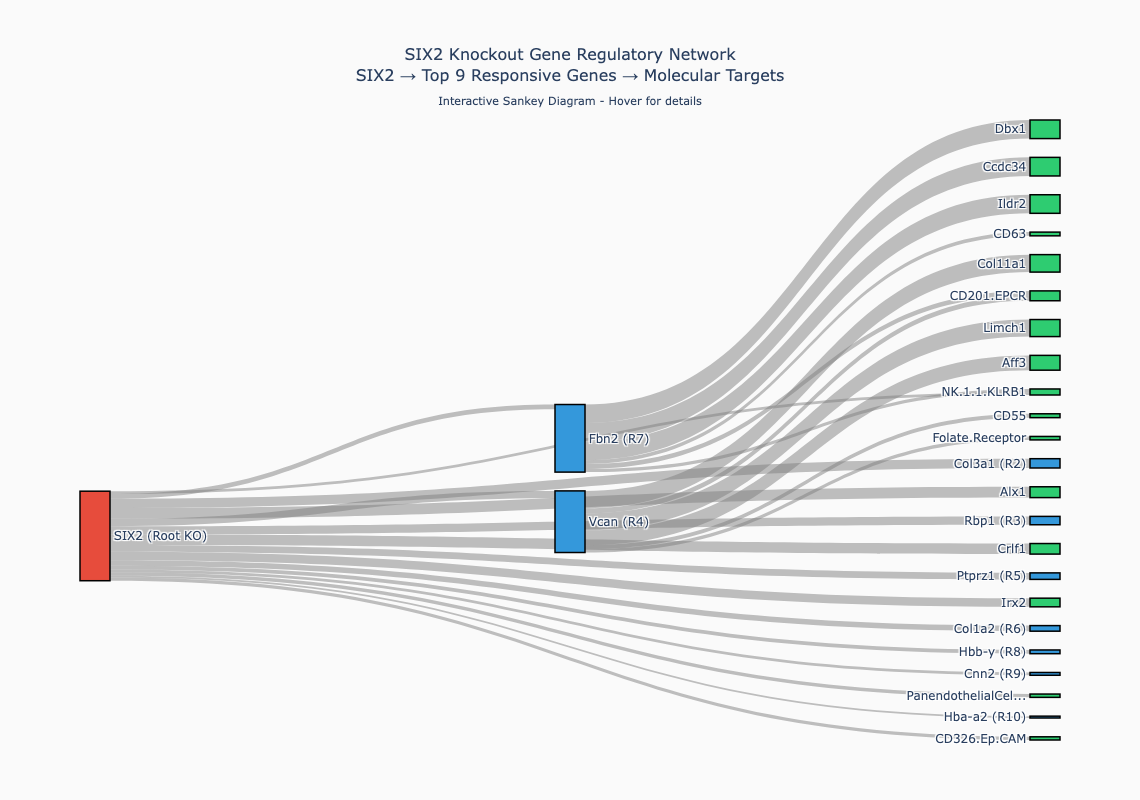


📊 SIX2 KNOCKOUT NETWORK ANALYSIS
🎯 **Network Overview:**
   • Root Gene: SIX2 (knockout target)
   • Responsive Genes: 9 (top GenKI predictions)
   • Connection Targets: 16 (from SIX2 KO analysis)
   • Total Connections: 27

🧬 **GenKI Responsive Genes (Level 2):**
   • Col3a1 (Rank 2)
     - GenKI Score: 159.5
     - Connections: 0
   • Rbp1 (Rank 3)
     - GenKI Score: 68.7
     - Connections: 0
   • Vcan (Rank 4)
     - GenKI Score: 52.7
     - Connections: 6
   • Ptprz1 (Rank 5)
     - GenKI Score: 51.8
     - Connections: 0
   • Col1a2 (Rank 6)
     - GenKI Score: 45.4
     - Connections: 0
   • Fbn2 (Rank 7)
     - GenKI Score: 44.6
     - Connections: 6
   • Hbb-y (Rank 8)
     - GenKI Score: 41.0
     - Connections: 0
   • Cnn2 (Rank 9)
     - GenKI Score: 36.0
     - Connections: 0
   • Hba-a2 (Rank 10)
     - GenKI Score: 35.7
     - Connections: 0

🔗 **Connection Targets (Level 3):**
   • CD201.EPCR: From 2 gene(s) (RNA -> Protein)
   • NK.1.1.KLRB1: From 2 gene(s) (RNA -> P

In [4]:
import pandas as pd
import numpy as np

def create_six2_alluvial_plot(top10_csv, six2_ko_csv, output_file=None):
    """
    Create an alluvial plot for SIX2 knockout data showing:
    - SIX2 (root knockout gene)
    - Top 9 responsive GenKI genes (blue level)
    - Target connections from SIX2 KO analysis
    """
    try:
        import plotly.graph_objects as go
        import plotly.offline as pyo
    except ImportError:
        print("ERROR: Plotly not installed. Install with: pip install plotly")
        return None
    
    print("Loading SIX2 knockout data...")
    
    # Read the data files
    top10_df = pd.read_csv(top10_csv)
    six2_ko_df = pd.read_csv(six2_ko_csv)
    
    print(f"Top 10 responsive genes: {len(top10_df)} rows")
    print(f"SIX2 KO connections: {len(six2_ko_df)} rows")
    
    # Debug: Check the actual column names
    print(f"Top10 columns: {list(top10_df.columns)}")
    print(f"First few rows of top10:")
    print(top10_df.head(3))
    
    # Handle the gene names column - it might be the first column regardless of name
    gene_col = top10_df.columns[0]  # Use first column as gene names
    print(f"Using column '{gene_col}' as gene names")
    
    # Get SIX2 as root and top 9 other responsive genes
    six2_gene = top10_df[top10_df[gene_col] == 'Six2']
    six2_gene = six2_gene.iloc[0] if len(six2_gene) > 0 else None
    
    other_genes = top10_df[top10_df[gene_col] != 'Six2'].head(9).copy()
    
    print(f"\nRoot gene: SIX2 (Rank {six2_gene['rank'] if six2_gene is not None else 'N/A'})")
    print(f"Other responsive genes: {len(other_genes)}")
    
    print(f"\nTop 9 GenKI responsive genes:")
    for _, gene in other_genes.iterrows():
        print(f"  {gene[gene_col]} (Rank {gene['rank']}, Score: {gene['dis']:.1f})")
    
    # Analyze SIX2 KO connections
    print(f"\nSIX2 KO connections analysis:")
    print(f"Unique sources: {six2_ko_df['source'].unique()}")
    print(f"Unique targets: {six2_ko_df['target'].nunique()} targets")
    print(f"Connection directions: {six2_ko_df['direction'].unique()}")
    
    # Get connections - prioritize those from our GenKI genes
    genki_gene_names = list(other_genes[gene_col]) + ['Six2']
    
    # Filter connections that come from our GenKI genes
    relevant_connections = six2_ko_df[
        six2_ko_df['source'].isin(genki_gene_names)
    ].copy()
    
    # If no direct connections from GenKI genes, take all connections
    if len(relevant_connections) == 0:
        print("  No direct connections from GenKI genes found, using all SIX2 KO connections")
        relevant_connections = six2_ko_df.copy()
    
    print(f"Relevant connections: {len(relevant_connections)}")
    
    # Get unique targets from connections
    unique_targets = relevant_connections['target'].unique()
    
    print(f"Unique connection targets: {len(unique_targets)}")
    for target in unique_targets[:10]:  # Show first 10
        print(f"  {target}")
    
    # Create node labels
    # Level 1: SIX2 (root)
    level1_labels = ['SIX2 (Root KO)']
    
    # Level 2: Top 9 other GenKI genes
    level2_labels = []
    for _, gene in other_genes.iterrows():
        level2_labels.append(f"{gene[gene_col]} (R{gene['rank']})")
    
    # Level 3: Connection targets
    level3_labels = []
    for target in unique_targets:
        # Clean up target names if they're too long
        clean_target = str(target)
        if len(clean_target) > 20:
            clean_target = clean_target[:17] + "..."
        level3_labels.append(clean_target)
    
    # Combine all labels
    all_labels = level1_labels + level2_labels + level3_labels
    
    # Create color scheme
    node_colors = (['#e74c3c'] +  # Red for SIX2
                   ['#3498db'] * len(level2_labels) +  # Blue for GenKI genes
                   ['#2ecc71'] * len(level3_labels))  # Green for targets
    
    print(f"\nTotal nodes: {len(all_labels)}")
    print(f"- Root: 1 (SIX2)")
    print(f"- GenKI genes: {len(level2_labels)}")
    print(f"- Connection targets: {len(level3_labels)}")
    
    # Create node index mappings
    label_to_idx = {label.split(' (')[0].replace('SIX2', 'Six2'): idx for idx, label in enumerate(all_labels)}
    # Special handling for SIX2
    label_to_idx['Six2'] = 0
    label_to_idx['SIX2'] = 0
    
    # Add GenKI gene mappings using the correct column
    for i, gene_name in enumerate(other_genes[gene_col]):
        label_to_idx[gene_name] = i + 1
    
    # Add target mappings
    for i, target in enumerate(unique_targets):
        label_to_idx[target] = i + 1 + len(level2_labels)
    
    # Build connections
    source_list = []
    target_list = []
    value_list = []
    hover_info = []
    
    print("\nBuilding connections...")
    
    # Level 1 to Level 2: SIX2 to other GenKI genes
    # Use rank-based weights (higher rank = lower number = higher weight)
    for _, gene in other_genes.iterrows():
        source_list.append(0)  # SIX2 index
        target_list.append(label_to_idx[gene[gene_col]])
        # Weight based on rank (lower rank number = higher weight)
        weight = max(2, 12 - gene['rank'])  # Ensures positive weights
        value_list.append(weight)
        hover_info.append(f"SIX2 → {gene[gene_col]} (Rank {gene['rank']}, Score: {gene['dis']:.1f})")
    
    # Level 2 to Level 3: GenKI genes to targets (from SIX2 KO connections)
    for _, connection in relevant_connections.iterrows():
        source_gene = connection['source']
        target_gene = connection['target']
        
        if source_gene in label_to_idx and target_gene in label_to_idx:
            source_list.append(label_to_idx[source_gene])
            target_list.append(label_to_idx[target_gene])
            
            # Use the connection value from the data
            connection_value = abs(connection.get('value', 1)) * 20  # Scale up for visibility
            value_list.append(connection_value)
            
            direction = connection.get('direction', 'Unknown')
            cluster = connection.get('cluster', 'N/A')
            hover_info.append(f"{source_gene} → {target_gene}<br>"
                            f"Value: {connection.get('value', 0):.3f}<br>"
                            f"Direction: {direction}<br>"
                            f"Cluster: {cluster}")
    
    print(f"Total connections built: {len(source_list)}")
    print(f"- SIX2 → GenKI genes: {len(other_genes)}")
    print(f"- GenKI → Targets: {len(relevant_connections)}")
    
    # Create hover text for nodes
    node_hover = []
    for i, label in enumerate(all_labels):
        if i == 0:
            # SIX2 root
            six2_score = six2_gene['dis'] if six2_gene is not None else 0
            node_hover.append(f"SIX2<br>Root knockout gene<br>"
                            f"GenKI Score: {six2_score:.1f}<br>"
                            f"Connects to top 9 responsive genes")
        elif i <= len(level2_labels):
            # GenKI genes
            gene_name = label.split(' (')[0]
            gene_info = other_genes[other_genes[gene_col] == gene_name]
            
            if len(gene_info) > 0:
                gene_info = gene_info.iloc[0]
                # Count connections from this gene
                connection_count = len(relevant_connections[relevant_connections['source'] == gene_name])
                
                node_hover.append(f"{gene_name}<br>"
                                f"GenKI Rank: {gene_info['rank']}<br>"
                                f"GenKI Score: {gene_info['dis']:.1f}<br>"
                                f"Connections: {connection_count}")
            else:
                node_hover.append(f"{gene_name}<br>GenKI gene<br>No details available")
        else:
            # Target genes
            target_name = unique_targets[i - 1 - len(level2_labels)]
            
            # Count how many GenKI genes connect to this target
            source_count = len(relevant_connections[relevant_connections['target'] == target_name])
            
            # Get connection details
            target_connections = relevant_connections[relevant_connections['target'] == target_name]
            directions = target_connections['direction'].unique()
            clusters = target_connections['cluster'].unique()
            
            node_hover.append(f"{target_name}<br>"
                            f"Connected from {source_count} gene(s)<br>"
                            f"Directions: {', '.join(directions)}<br>"
                            f"Clusters: {', '.join([str(c) for c in clusters])}")
    
    print("\nCreating SIX2 Plotly Sankey diagram...")
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=30,
            line=dict(color="black", width=1.5),
            label=all_labels,
            color=node_colors,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=node_hover
        ),
        link=dict(
            source=source_list,
            target=target_list,
            value=value_list,
            color="rgba(128,128,128,0.5)",
            hovertemplate='%{customdata}<extra></extra>',
            customdata=hover_info
        ),
        arrangement='snap'
    )])
    
    # Update layout
    fig.update_layout(
        title={
            'text': "SIX2 Knockout Gene Regulatory Network<br>" +
                   "SIX2 → Top 9 Responsive Genes → Molecular Targets<br>" +
                   "<sub>Interactive Sankey Diagram - Hover for details</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        font_size=12,
        width=1500,
        height=800,
        margin=dict(l=80, r=80, t=120, b=60),
        plot_bgcolor='white',
        paper_bgcolor='#fafafa'
    )
    
    # Save if output file specified
    if output_file:
        html_file = output_file if output_file.endswith('.html') else f"{output_file}.html"
        fig.write_html(html_file)
        print(f"\n✅ Interactive Plotly plot saved to: {html_file}")
        
        # Also save as PNG if plotly-kaleido is available
        try:
            png_file = html_file.replace('.html', '.png')
            fig.write_image(png_file, width=1500, height=800, scale=2)
            print(f"✅ High-resolution PNG saved to: {png_file}")
        except:
            print("💡 Install plotly-kaleido for PNG export: pip install plotly-kaleido")
    
    # Show the plot
    print("\n🚀 Displaying interactive SIX2 plot...")
    fig.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("📊 SIX2 KNOCKOUT NETWORK ANALYSIS")
    print("="*70)
    
    print(f"🎯 **Network Overview:**")
    print(f"   • Root Gene: SIX2 (knockout target)")
    print(f"   • Responsive Genes: {len(other_genes)} (top GenKI predictions)")
    print(f"   • Connection Targets: {len(unique_targets)} (from SIX2 KO analysis)")
    print(f"   • Total Connections: {len(source_list)}")
    
    print(f"\n🧬 **GenKI Responsive Genes (Level 2):**")
    for _, gene in other_genes.iterrows():
        connection_count = len(relevant_connections[relevant_connections['source'] == gene[gene_col]])
        print(f"   • {gene[gene_col]} (Rank {gene['rank']})")
        print(f"     - GenKI Score: {gene['dis']:.1f}")
        print(f"     - Connections: {connection_count}")
    
    print(f"\n🔗 **Connection Targets (Level 3):**")
    target_counts = relevant_connections['target'].value_counts()
    for target, count in target_counts.head(8).items():
        directions = relevant_connections[relevant_connections['target'] == target]['direction'].unique()
        print(f"   • {target}: From {count} gene(s) ({', '.join(directions)})")
    
    print(f"\n📈 **Connection Analysis:**")
    direction_counts = relevant_connections['direction'].value_counts()
    for direction, count in direction_counts.items():
        print(f"   • {direction}: {count} connections")
    
    return fig


def main():
    """
    Main function to create the SIX2 alluvial plot
    """
    print("🔬 Creating SIX2 Knockout Network Visualization")
    print("="*60)
    
    try:
        fig = create_six2_alluvial_plot(
  '../../Mongoose_post_hoc/DBiTseq/Top10_Responsive_Genes_Six2.csv',
            '../../Mongoose_post_hoc/DBiTseq/SIX2_KO_rows.csv',
            output_file='six2_knockout_alluvial'
        )
        
        if fig:
            print("\n✅ SUCCESS: SIX2 visualization created!")
            print("\n📋 **What the plot shows:**")
            print("   🔴 SIX2 (root knockout gene)")
            print("   🔵 Top 9 GenKI responsive genes")
            print("   🟢 Molecular connection targets")
            print("\n💡 **Connection types:**")
            print("   • RNA → Protein: Gene expression to protein level")
            print("   • RNA → Niche: Gene expression to niche/environment")
            print("   • Connection thickness represents relationship strength")
            print("\n💡 **How to use:**")
            print("   • Hover over nodes for detailed gene information")
            print("   • Hover over connections for interaction details")
            print("   • Colors distinguish the three network levels")
        else:
            print("\n❌ FAILED: Could not create visualization")
            
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("📦 Make sure you have the required files:")
        print("   • Top10_Responsive_Genes_Six2.csv")
        print("   • SIX2_KO_rows.csv")


# Run the SIX2 visualization
if __name__ == "__main__":
    main()

In [ ]:
   '../../Mongoose_post_hoc/DBiTseq/Top10_Responsive_Genes_Six2.csv',
            '../../Mongoose_post_hoc/DBiTseq/SIX2_KO_rows.csv',